# Final Project Submission

Please fill out:
* Student name: Peder Norr
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:

# Introduction

Real estate continues to be one of the most lucrative and secure investment vehicles available. This proposal contains an analysis of Minnesota home value time series data in order to provide a real estate investment firm the identification of the best locations to invest in Minnesota. Initial analysis of the data shows that there are 5 zip codes that provide the biggest opportunity for return on investment. The real estate investment firm can use this analysis to make their entry in the Minnesotan market more effective and profitable.

# Business Problem

Due to the booming housing market in the state, a real estate investment firm has decided to invest in property in Minnesota. However, they are unfamiliar with the state. They want to identify the top 5 best zip codes in the state in which to invest. This proposal will identify the top 5 zip codes for investment by calculating future potential return on investment after 24 months.

# Data Understanding

The data used in this analysis come from [Zillow Research](https://www.zillow.com/research/data/) which aggregates housing data. The data set contains 6 variables describing property sale including zip code, city, state, metro area, size rank It includes 14,723 individual entries recorded daily from 1996-2018.

In [1]:
#Import necessary packages

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as missingno

%matplotlib inline

import statsmodels.tsa.api as tsa
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


#!pip install pmdarima
import pmdarima as pmd


In [2]:
#Set pandas and seaborn options

pd.set_option('display.max_columns',0)
plt.style.use('seaborn-notebook')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
#Import dataset
df = pd.read_csv('data/zillow_data.csv')
df.head()

RegionID  RegionName      City State  ...  2018-01  2018-02  2018-03  2018-04
0     84654       60657   Chicago    IL  ...  1024400  1030700  1033800  1030600
1     90668       75070  McKinney    TX  ...   318100   319600   321100   321800
2     91982       77494      Katy    TX  ...   321200   323000   326900   329900
3     84616       60614   Chicago    IL  ...  1302700  1306400  1308500  1307000
4     93144       79936   El Paso    TX  ...   120300   120500   121000   121500

[5 rows x 272 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [5]:
df.describe()

RegionID  RegionName  ...       2018-03       2018-04
count  14723.0000  14723.0000  ...    14723.0000    14723.0000
mean   81075.0101  48222.3487  ...   286511.3768   288039.9443
std    31934.1185  29359.3254  ...   372461.2347   372054.3969
min    58196.0000   1001.0000  ...    13800.0000    13800.0000
25%    67174.5000  22101.5000  ...   131950.0000   132400.0000
50%    78007.0000  46106.0000  ...   196700.0000   198100.0000
75%    90920.5000  75205.5000  ...   318850.0000   321100.0000
max   753844.0000  99901.0000  ... 18337700.0000 17894900.0000

[8 rows x 268 columns]

In [6]:
#Narrow down to Minnesota zipcodes
minnesota_df = df.loc[df['State']== 'MN'].reset_index()
display(minnesota_df.head())
print(f'Number of zipcodes: {len(minnesota_df)}')

index  RegionID  RegionName  ... 2018-02 2018-03 2018-04
0    291     82474       55901  ...  212800  213800  214400
1    500     82125       55124  ...  265600  268400  270800
2    686     82547       56001  ...  188900  188800  189100
3    745     82189       55337  ...  261200  263900  266600
4    859     82063       55044  ...  333700  338000  341700

[5 rows x 273 columns]

Number of zipcodes: 375


# Data Preprocessing

In [7]:
#Rename RegionName as ZipCode
minnesota_df.rename({'RegionName': 'ZipCode'}, axis=1, inplace=True)
minnesota_df.head()

index  RegionID  ZipCode          City  ... 2018-01 2018-02 2018-03  2018-04
0    291     82474    55901     Rochester  ...  211500  212800  213800   214400
1    500     82125    55124  Apple Valley  ...  264200  265600  268400   270800
2    686     82547    56001       Mankato  ...  189000  188900  188800   189100
3    745     82189    55337    Burnsville  ...  260000  261200  263900   266600
4    859     82063    55044     Lakeville  ...  331300  333700  338000   341700

[5 rows x 273 columns]

In [8]:
#Drop unnecessary columns
minnesota_df.drop(['index', 'RegionID', 'State', 'CountyName'], axis=1, inplace=True)
minnesota_df.head()

ZipCode          City                Metro  ...  2018-02  2018-03  2018-04
0    55901     Rochester            Rochester  ...   212800   213800   214400
1    55124  Apple Valley  Minneapolis-St Paul  ...   265600   268400   270800
2    56001       Mankato              Mankato  ...   188900   188800   189100
3    55337    Burnsville  Minneapolis-St Paul  ...   261200   263900   266600
4    55044     Lakeville  Minneapolis-St Paul  ...   333700   338000   341700

[5 rows x 269 columns]

In [9]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[4:], format='%Y-%m')

In [10]:
get_datetimes(minnesota_df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [11]:
#Change ZipCode dtype to 'str'
minnesota_df['ZipCode'] = minnesota_df['ZipCode'].astype(str)
minnesota_df.dtypes

ZipCode      object
City         object
Metro        object
SizeRank      int64
1996-04     float64
             ...   
2017-12       int64
2018-01       int64
2018-02       int64
2018-03       int64
2018-04       int64
Length: 269, dtype: object

In [12]:
#Calculate ROI percentages since 2010
minnesota_df['ROI'] = round(((minnesota_df['2018-04'] - minnesota_df['2010-04'])/ minnesota_df['2010-04'])*100,4)
minnesota_df.head()

ZipCode          City                Metro  ...  2018-03  2018-04     ROI
0   55901     Rochester            Rochester  ...   213800   214400 34.5044
1   55124  Apple Valley  Minneapolis-St Paul  ...   268400   270800 29.0138
2   56001       Mankato              Mankato  ...   188800   189100 21.7643
3   55337    Burnsville  Minneapolis-St Paul  ...   263900   266600 32.3077
4   55044     Lakeville  Minneapolis-St Paul  ...   338000   341700 34.3689

[5 rows x 270 columns]

<AxesSubplot:xlabel='ROI', ylabel='Count'>

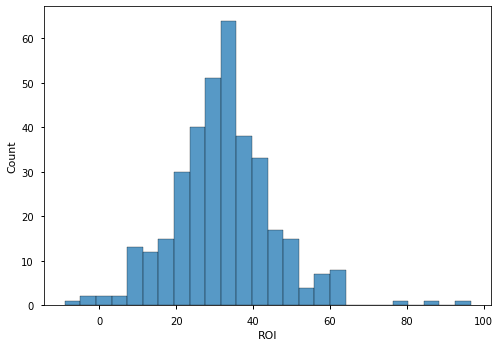

In [13]:
#Create histogram to show distribution of zip codes by historical ROI
sns.histplot(minnesota_df['ROI'])

In [14]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'Metro', 'SizeRank', 'ROI'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#.groupby('time').aggregate({'value':'mean'})

In [15]:
#Reshape dataset from Wide to Long Format
melted_minnesota_df = melt_data(minnesota_df)
display(melted_minnesota_df.head())
display(melted_minnesota_df.info())

ZipCode          City                Metro  ...     ROI       time       value
0   55901     Rochester            Rochester  ... 34.5044 1996-04-01  91300.0000
1   55124  Apple Valley  Minneapolis-St Paul  ... 29.0138 1996-04-01 122400.0000
2   56001       Mankato              Mankato  ... 21.7643 1996-04-01  85600.0000
3   55337    Burnsville  Minneapolis-St Paul  ... 32.3077 1996-04-01 123200.0000
4   55044     Lakeville  Minneapolis-St Paul  ... 34.3689 1996-04-01 138800.0000

[5 rows x 7 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94384 entries, 0 to 99374
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ZipCode   94384 non-null  object        
 1   City      94384 non-null  object        
 2   Metro     85345 non-null  object        
 3   SizeRank  94384 non-null  int64         
 4   ROI       92932 non-null  float64       
 5   time      94384 non-null  datetime64[ns]
 6   value     94384 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 5.8+ MB


None

In [16]:
#Set 'time' column as index to create time series
melted_minnesota_df.set_index('time', inplace=True)

In [17]:
display(melted_minnesota_df.head())
display(melted_minnesota_df.tail())
display(melted_minnesota_df.info())
melted_minnesota_df.index

ZipCode          City  ...     ROI       value
time                              ...                    
1996-04-01   55901     Rochester  ... 34.5044  91300.0000
1996-04-01   55124  Apple Valley  ... 29.0138 122400.0000
1996-04-01   56001       Mankato  ... 21.7643  85600.0000
1996-04-01   55337    Burnsville  ... 32.3077 123200.0000
1996-04-01   55044     Lakeville  ... 34.3689 138800.0000

[5 rows x 6 columns]

ZipCode         City  ...     ROI       value
time                             ...                    
2018-04-01   56314       Bowlus  ... 47.8992 211200.0000
2018-04-01   56010        Amboy  ... 15.8668 118300.0000
2018-04-01   55065     Randolph  ... 28.9302 277200.0000
2018-04-01   56578      Rochert  ... 45.1317 237000.0000
2018-04-01   56120  Butterfield  ... 87.6404 133600.0000

[5 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94384 entries, 1996-04-01 to 2018-04-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ZipCode   94384 non-null  object 
 1   City      94384 non-null  object 
 2   Metro     85345 non-null  object 
 3   SizeRank  94384 non-null  int64  
 4   ROI       92932 non-null  float64
 5   value     94384 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 5.0+ MB


None

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=94384, freq=None)

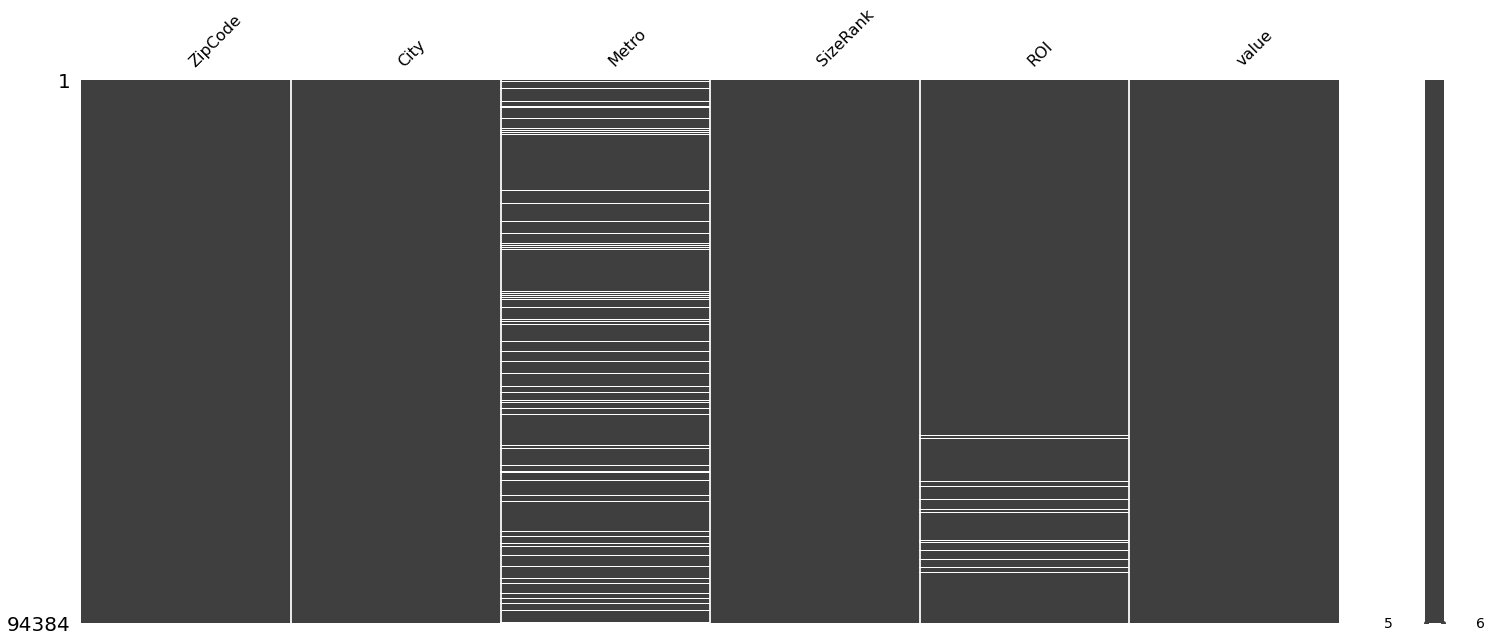

#null  %null
ZipCode       0 0.0000
City          0 0.0000
Metro      9039 9.5800
SizeRank      0 0.0000
ROI        1452 1.5400
value         0 0.0000

In [18]:
#Check for null values

#Original source https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_3/topic_30_ensemble_methods/topic_30_ensemble_methods-SG.ipynb

missingno.matrix(melted_minnesota_df)
plt.show()
null_check = pd.DataFrame({
    '#null':melted_minnesota_df.isna().sum(),
    '%null':round(melted_minnesota_df.isna().sum()/len(melted_minnesota_df)*100,2)
})
null_check

In [19]:
#Fill 'Metro' nulls with 'Missing'
melted_minnesota_df['Metro'].fillna('Missing', inplace = True)

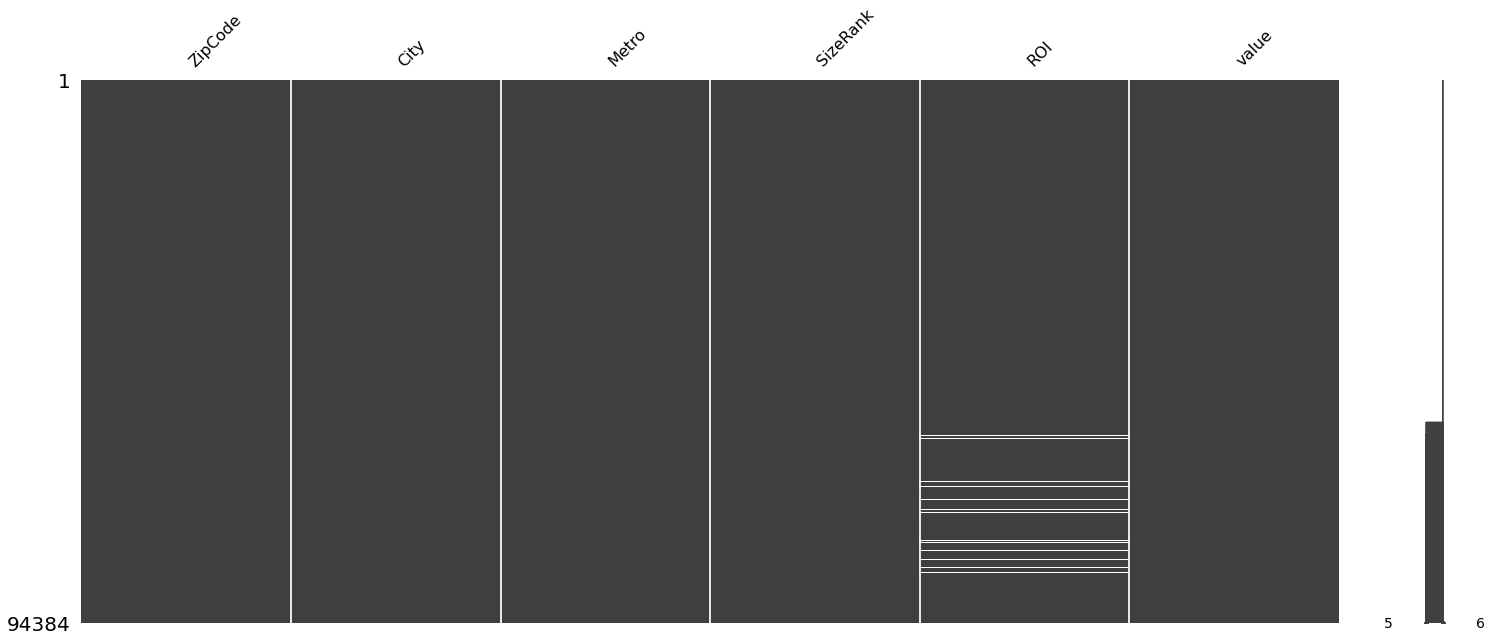

#null  %null
ZipCode       0 0.0000
City          0 0.0000
Metro         0 0.0000
SizeRank      0 0.0000
ROI        1452 1.5400
value         0 0.0000

In [20]:
missingno.matrix(melted_minnesota_df)
plt.show()
null_check = pd.DataFrame({
    '#null':melted_minnesota_df.isna().sum(),
    '%null':round(melted_minnesota_df.isna().sum()/len(melted_minnesota_df)*100,2)
})
null_check

In [21]:
display(melted_minnesota_df['ZipCode'].unique())
melted_minnesota_df['ZipCode'].nunique()

array(['55901', '55124', '56001', '55337', '55044', '55106', '55303',
       '55104', '55113', '55112', '56560', '55408', '55416', '55125',
       '55117', '55406', '55304', '55379', '55110', '55119', '55423',
       '55407', '55330', '55369', '55987', '55082', '55414', '56601',
       '55433', '55418', '55122', '55109', '56401', '55311', '55404',
       '55432', '55118', '55343', '55422', '56308', '55372', '56301',
       '55016', '55116', '55443', '55421', '55426', '55060', '55428',
       '55912', '55024', '55128', '55033', '56303', '55021', '55403',
       '55904', '55105', '55434', '55347', '55126', '55417', '55811',
       '55419', '55448', '55318', '55429', '55449', '55902', '55068',
       '55427', '55378', '55305', '55102', '55014', '55411', '56201',
       '55025', '55420', '55123', '55446', '55744', '55076', '55313',
       '55345', '55447', '55316', '55410', '55412', '56501', '55437',
       '55075', '55431', '55057', '55038', '55066', '55317', '55746',
       '55430', '554

375

# EDA and Visualization

<AxesSubplot:xlabel='time'>

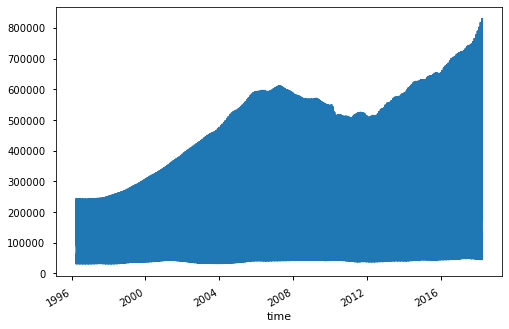

In [22]:
melted_minnesota_df['value'].plot()

In [23]:
#Select the top 2.5% performing Zip Codes based on calculated historical ROI
quantile975 = melted_minnesota_df['ROI'].quantile(q=0.975)
top_zipcodes = melted_minnesota_df.loc[melted_minnesota_df['ROI']>=quantile975]
top_zipcodes.head()

ZipCode             City  ...     ROI      value
time                                 ...                   
1996-04-01   55411      Minneapolis  ... 78.9531 48700.0000
1996-04-01   55412      Minneapolis  ... 60.6307 56400.0000
1996-04-01   55430  Brooklyn Center  ... 62.6002 77300.0000
1996-04-01   55413      Minneapolis  ... 61.7928 66100.0000
1996-04-01   55130       Saint Paul  ... 62.9213 66700.0000

[5 rows x 6 columns]

In [24]:
#Drop more irrelevant columns
top_zipcodes.drop(['Metro', 'SizeRank'], axis=1, inplace=True)
top_zipcodes.head()

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ZipCode             City     ROI      value
time                                                  
1996-04-01   55411      Minneapolis 78.9531 48700.0000
1996-04-01   55412      Minneapolis 60.6307 56400.0000
1996-04-01   55430  Brooklyn Center 62.6002 77300.0000
1996-04-01   55413      Minneapolis 61.7928 66100.0000
1996-04-01   55130       Saint Paul 62.9213 66700.0000

In [25]:
top_zipcodes['ZipCode'].nunique()

11

In [26]:
#Create list of top zipcodes
top_zipcodes_list = top_zipcodes['ZipCode'].unique().tolist()
top_zipcodes_list

['55411',
 '55412',
 '55430',
 '55413',
 '55130',
 '55319',
 '56672',
 '56050',
 '56081',
 '56062',
 '56120']

In [27]:
#Create Time Series DataFrames for each ZipCode
all_time_series = {}
for zipcode in top_zipcodes_list:
    zipcode_df = top_zipcodes.groupby('ZipCode').get_group(zipcode).sort_index()['value']
    all_time_series[zipcode] = zipcode_df

In [28]:
all_time_series.keys()

dict_keys(['55411', '55412', '55430', '55413', '55130', '55319', '56672', '56050', '56081', '56062', '56120'])

In [29]:
all_time_series_df = pd.DataFrame(all_time_series)
all_time_series_df.head()

55411      55412      55430  ...  56081  56062  56120
time                                         ...                     
1996-04-01 48700.0000 56400.0000 77300.0000  ...    nan    nan    nan
1996-05-01 48700.0000 56600.0000 77200.0000  ...    nan    nan    nan
1996-06-01 48800.0000 56900.0000 77000.0000  ...    nan    nan    nan
1996-07-01 49000.0000 57200.0000 76900.0000  ...    nan    nan    nan
1996-08-01 49100.0000 57500.0000 76800.0000  ...    nan    nan    nan

[5 rows x 11 columns]

In [30]:
all_time_series_df.tail()

55411       55412  ...       56062       56120
time                                ...                        
2017-12-01 155500.0000 150200.0000  ... 157800.0000 132600.0000
2018-01-01 157900.0000 151800.0000  ... 158400.0000 131100.0000
2018-02-01 159800.0000 153500.0000  ... 158200.0000 132900.0000
2018-03-01 162200.0000 156000.0000  ... 158300.0000 133900.0000
2018-04-01 164100.0000 157900.0000  ... 158600.0000 133600.0000

[5 rows x 11 columns]

In [31]:
#Resample timeseries as Monthly
all_time_series_df = all_time_series_df.resample('MS').asfreq()
all_time_series_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=265, freq='MS')

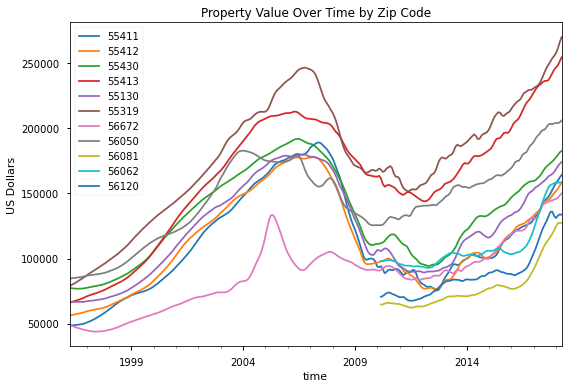

In [32]:
#Create plot to show value by zip code over time
all_time_series_df.plot()
plt.title('Property Value Over Time by Zip Code')
plt.ylabel('US Dollars')
plt.tight_layout()
plt.savefig('images/all_zipcodes.png')

Due to the aberrations caused by the 2008 housing crash, I will be using the data from 2010-2018 for modeling.

In [33]:
all_time_series_df = all_time_series_df.loc['2010':]
display(all_time_series_df.info())
all_time_series_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2010-01-01 to 2018-04-01
Freq: MS
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   55411   100 non-null    float64
 1   55412   100 non-null    float64
 2   55430   100 non-null    float64
 3   55413   100 non-null    float64
 4   55130   100 non-null    float64
 5   55319   100 non-null    float64
 6   56672   100 non-null    float64
 7   56050   100 non-null    float64
 8   56081   98 non-null     float64
 9   56062   98 non-null     float64
 10  56120   98 non-null     float64
dtypes: float64(11)
memory usage: 9.4 KB


None

55411      55412       55430  ...      56081      56062      56120
time                                          ...                                 
2010-01-01 93800.0000 96900.0000 111200.0000  ...        nan        nan        nan
2010-02-01 93400.0000 97300.0000 111400.0000  ...        nan        nan        nan
2010-03-01 94100.0000 97900.0000 111800.0000  ... 64600.0000 97900.0000 70600.0000
2010-04-01 91700.0000 98300.0000 112300.0000  ... 64800.0000 98000.0000 71200.0000
2010-05-01 88700.0000 98700.0000 113500.0000  ... 65300.0000 98200.0000 72300.0000

[5 rows x 11 columns]

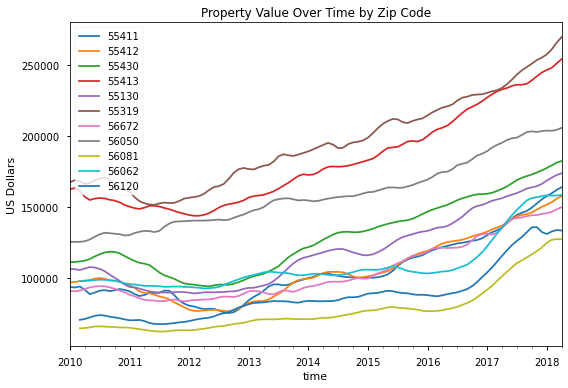

In [34]:
all_time_series_df.plot()
plt.title('Property Value Over Time by Zip Code')
plt.ylabel('US Dollars')
plt.tight_layout()
plt.savefig('images/top_zipcodes.png')

# SARIMA Modeling

In order to forecast property values, I will use SARIMA time series models. Below I fit models for each of the top 9 zip codes by ROI and make forecasts for future property values in each zip code.

## Zipcode 55411

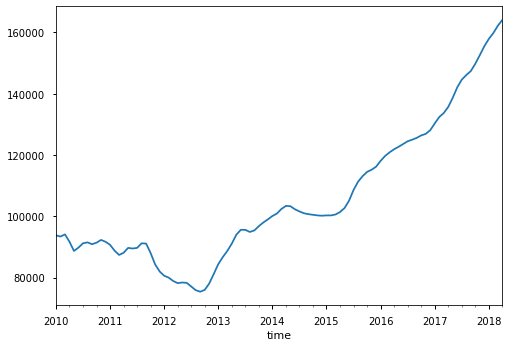

In [35]:
#Create and visualize time series for zipcode 5549
ts = all_time_series_df['55411']
ts.plot();

In [36]:
#Create train test split cutoff
def train_test_split(ts, steps=24):
    
    #tts_cutoff = round(len(ts)*0.80)
    tts_cutoff = -1*steps
    display(tts_cutoff)

    ## Use the tts cutoff to do Train test split and plot
    train = ts.iloc[:tts_cutoff]
    test = ts.iloc[tts_cutoff:]
    
    return train, test

In [37]:
train, test = train_test_split(ts)

-24

In [38]:
#Create function to plot train test split for the time series
def plot_train_test_split(train, test):
    
    ## Plot
    ax = train.plot(label='train')
    test.plot(label='test')
    ax.legend()
    
    return ax

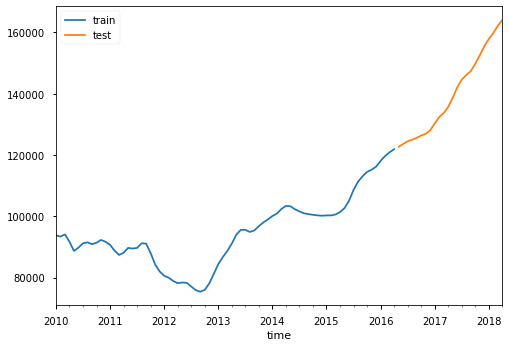

In [39]:
plot_train_test_split(train, test);

In [40]:
#Create Dickey Fuller Test test function
def adfuller_test_df(ts,index=['AD Fuller Results']):
    
    """Adapted from https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_4/topic_38_time_series_models/ts_functions.py
    Returns the AD Fuller Test Results and p-values for the null hypothesis
    that there the data is non-stationary (that there is a unit root in the data)"""
    
    df_res = tsa.stattools.adfuller(ts)

    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,df_res[:4]))
    
    res['p<.05'] = res['p-value']<.05
    res['Stationary?'] = res['p<.05']
    
    if isinstance(index,str):
        index = [index]
    res_df = pd.DataFrame(res,index=index)
    res_df = res_df[['Test Statistic','#Lags Used',
                     '# of Observations Used','p-value','p<.05',
                    'Stationary?']]
    return res_df

In [41]:
#Create Stationarity evaluation function
def stationarity_check(TS,window=4,plot=True,index=['AD Fuller Results']):
    """Adapted from https://github.com/learn-co-curriculum/dsc-removing-trends-lab/tree/solution"""
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=window, center=False).mean()
    roll_std = TS.rolling(window=window, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller_test_df(TS,index=index)
    
    if plot:
        
        ## Building in contingency if not a series with a freq
        try: 
            freq = TS.index.freq
        except:
            freq = 'N/A'
            
        # Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        plt.plot(TS, color='blue',label=f'Original (freq={freq}')
        plt.plot(roll_mean, color='red', label=f'Rolling Mean (window={window})')
        plt.plot(roll_std, color='black', label = f'Rolling Std (window={window})')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        display(dftest)
        plt.show(block=False)
        
    return dftest

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -0.3210          10  ...  False        False

[1 rows x 6 columns]

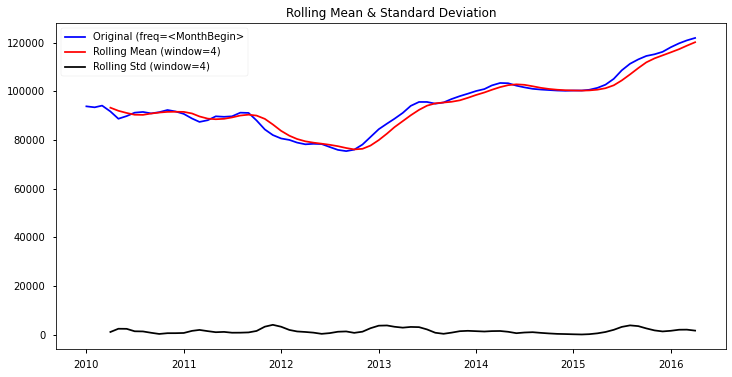

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -0.3210          10  ...  False        False

[1 rows x 6 columns]

In [42]:
#Check time series for stationarity
stationarity_check(train)

From the high p value shown above, we can conclude that the time series is not stationary and will require transformation.

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.8922           9  ...  False        False

[1 rows x 6 columns]

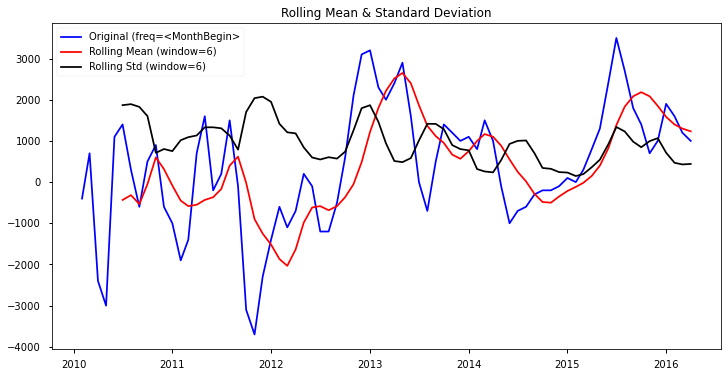

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.8922           9  ...  False        False

[1 rows x 6 columns]

In [43]:
#Check if differencing time series will result in stationarity
stationarity_check(train.diff().dropna(), window=6)

From the high p value shown above, we can conclude that the time series is not stationary and will require transformation.

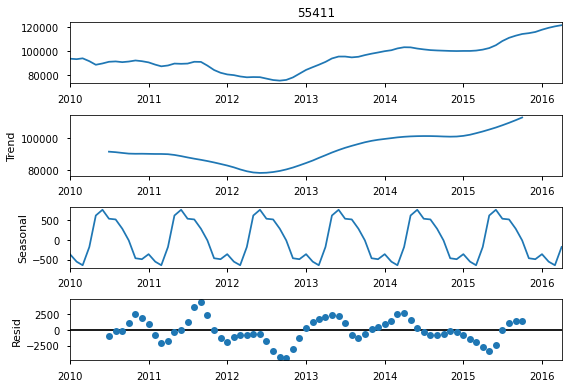

In [44]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot();

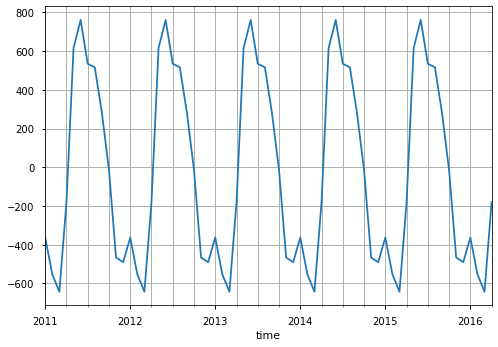

In [45]:
#Zoom in on shorter time period
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

From the figures above, we can determine that there is some seasonality in the data

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=1245.351, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=1237.531, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=1238.603, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=1246.908, Time=0.01 sec
 ARIMA(1,2,0)(2,0,0)[4]             : AIC=1236.843, Time=0.02 sec
 ARIMA(1,2,0)(2,0,1)[4]             : AIC=1238.839, Time=0.06 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=1237.656, Time=0.04 sec
 ARIMA(0,2,0)(2,0,0)[4]             : AIC=1234.734, Time=0.02 sec
 ARIMA(0,2,0)(1,0,0)[4]             : AIC=1235.255, Time=0.04 sec
 ARIMA(0,2,0)(2,0,1)[4]             : AIC=1236.722, Time=0.04 sec
 ARIMA(0,2,0)(1,0,1)[4]             : AIC=1235.678, Time=0.03 sec
 ARIMA(0,2,1)(2,0,0)[4]             : AIC=1235.639, Time=0.07 sec
 ARIMA(1,2,1)(2,0,0)[4]             : AIC=1230.158, Time=0.08 sec
 ARIMA(1,2,1)(1,0,0)[4]             : AIC=1236.442, Time=0.04 sec
 ARIMA(1,2,1)(2,0,1)[4]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   76
Model:             SARIMAX(1, 2, 2)x(2, 0, [], 4)   Log Likelihood                -607.946
Date:                            Thu, 01 Jul 2021   AIC                           1227.893
Time:                                    09:50:00   BIC                           1241.717
Sample:                                         0   HQIC                          1233.407
                                             - 76                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7778      0.117     -6.638      0.000      -1.007      -0.548
ma.L1          0.7754      0.124      6.266      0.000       0.533       1.018
ma.L2          0.0558      0.051      1.089      0.276      -0.045       0.156
ar.S.L4       -0.1609      0.062     -2.584      0.010      -0.283      -0.039
ar.S.L8       -0.0732      0.063     -1.163      0.245      -0.196       0.050
sigma2      8.714e+05   1.27e+05      6.843      0.000    6.22e+05    1.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.92   Jarque-Bera (JB):                11.20
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

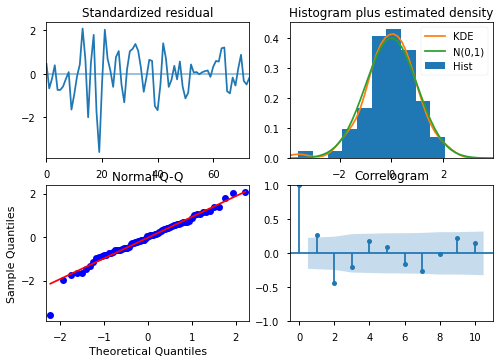

In [46]:
#Create first ARIMA model using auto arima to gridsearch for parameters
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=4, trace=True)
display(model.summary())
model.plot_diagnostics();

The above SARIMAX model performed well as shown by significant p values and an AIC of 1227.893. The diagnostics plots also look acceptable. The optimal order was (1,2,2)(2,0,0).

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=1205.591, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4]             : AIC=1202.297, Time=0.03 sec
 ARIMA(0,2,1)(0,1,1)[4]             : AIC=1201.842, Time=0.03 sec
 ARIMA(0,2,1)(0,1,0)[4]             : AIC=1211.052, Time=0.01 sec
 ARIMA(0,2,1)(1,1,1)[4]             : AIC=1197.506, Time=0.06 sec
 ARIMA(0,2,1)(1,1,0)[4]             : AIC=1203.208, Time=0.02 sec
 ARIMA(0,2,1)(2,1,1)[4]             : AIC=1198.614, Time=0.08 sec
 ARIMA(0,2,1)(1,1,2)[4]             : AIC=1198.757, Time=0.10 sec
 ARIMA(0,2,1)(0,1,2)[4]             : AIC=1197.937, Time=0.07 sec
 ARIMA(0,2,1)(2,1,0)[4]             : AIC=1199.916, Time=0.03 sec
 ARIMA(0,2,1)(2,1,2)[4]             : AIC=1200.507, Time=0.17 sec
 ARIMA(0,2,0)(1,1,1)[4]             : AIC=1195.507, Time=0.08 sec
 ARIMA(0,2,0)(0,1,1)[4]             : AIC=1199.676, Time=0.02 sec
 ARIMA(0,2,0)(1,1,0)[4]             : AIC=1200.418, Time=0.03 sec
 ARIMA(0,2,0)(2,1,1)[4]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   76
Model:             SARIMAX(3, 2, 3)x(4, 1, [], 4)   Log Likelihood                -577.079
Date:                            Thu, 01 Jul 2021   AIC                           1176.157
Time:                                    09:50:18   BIC                           1200.891
Sample:                                         0   HQIC                          1185.982
                                             - 76                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6733      0.045     14.995      0.000       0.585       0.761
ar.L2          0.4748      0.072      6.609      0.000       0.334       0.616
ar.L3         -0.8910      0.045    -19.623      0.000      -0.980      -0.802
ma.L1         -0.7223      0.063    -11.476      0.000      -0.846      -0.599
ma.L2         -0.3990      0.098     -4.089      0.000      -0.590      -0.208
ma.L3          0.8110      0.060     13.510      0.000       0.693       0.929
ar.S.L4       -0.2398      0.048     -5.016      0.000      -0.333      -0.146
ar.S.L8       -0.2300      0.034     -6.792      0.000      -0.296      -0.164
ar.S.L12      -0.1515      0.035     -4.384      0.000      -0.219      -0.084
ar.S.L16      -0.0513      0.030     -1.727      0.084      -0.110       0.007
sigma2      5.614e+05   5.65e-08   9.94e+12      0.000    5.61e+05    5.61e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.62   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.01   Prob(JB):                         0.60
Heteroskedasticity (H):               0.64   Skew:                             0.16
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+29. Standard errors may be unstable.
"""

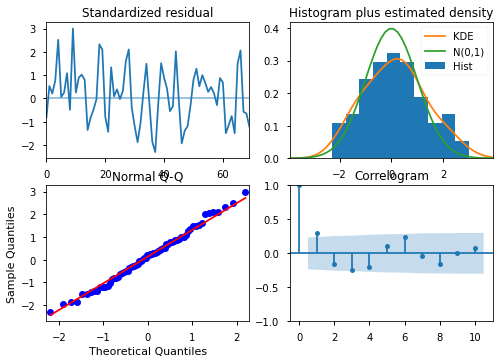

In [47]:
#Create new model and expand parameter search
model = pmd.auto_arima(train, 
                       start_p=0, max_p=5,
                       start_P=0, max_P=5,
                       start_q=0, max_q=5,
                       start_Q=0, max_Q=5,
                       d=2, D=1,
                       m=4,
                       trace=True)
display(model.summary())
model.plot_diagnostics();

The above model performed well as shown by significant p values and an AIC of 1176.157. The diagnostics plots also look improved. The best model order was (3,2,3)(4,1,0).

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              55411   No. Observations:                   76
Model:             SARIMAX(3, 2, 3)x(4, 1, [], 4)   Log Likelihood                -577.079
Date:                            Thu, 01 Jul 2021   AIC                           1176.157
Time:                                    09:50:20   BIC                           1200.891
Sample:                                01-01-2010   HQIC                          1185.982
                                     - 04-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6733      0.045     14.995      0.000       0.585       0.761
ar.L2          0.4748      0.072      6.609      0.000       0.334       0.616
ar.L3         -0.8910      0.045    -19.623      0.000      -0.980      -0.802
ma.L1         -0.7223      0.063    -11.476      0.000      -0.846      -0.599
ma.L2         -0.3990      0.098     -4.089      0.000      -0.590      -0.208
ma.L3          0.8110      0.060     13.510      0.000       0.693       0.929
ar.S.L4       -0.2398      0.048     -5.016      0.000      -0.333      -0.146
ar.S.L8       -0.2300      0.034     -6.792      0.000      -0.296      -0.164
ar.S.L12      -0.1515      0.035     -4.384      0.000      -0.219      -0.084
ar.S.L16      -0.0513      0.030     -1.727      0.084      -0.110       0.007
sigma2      5.614e+05   5.65e-08   9.94e+12      0.000    5.61e+05    5.61e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.62   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.01   Prob(JB):                         0.60
Heteroskedasticity (H):               0.64   Skew:                             0.16
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+29. Standard errors may be unstable.
"""

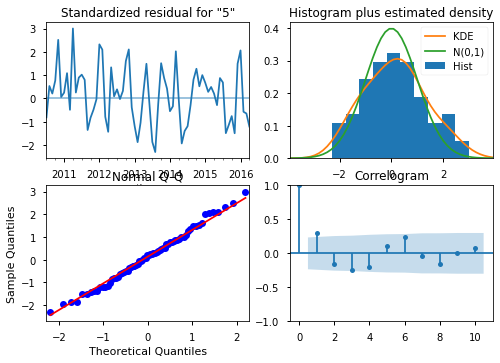

In [48]:
#Create SARIMAX model using determined parameters
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

The above model performed well as shown by significant p values and an AIC of 1176.157. The diagnostics plots also look improved.

In [49]:
#Create function to retrieve forecast and create data frame
def retrieve_forecast(model, steps):
    
    forecast = model.get_forecast(steps=len(test))
    forecast_df = forecast.conf_int()
    forecast_df.columns = ['Lower CI','Upper CI']
    forecast_df['Forecast'] = forecast.predicted_mean
    
    return forecast_df

In [50]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI    Upper CI    Forecast
2016-05-01 122366.0224 125303.7911 123834.9068
2016-06-01 122192.3948 128633.9697 125413.1822
2016-07-01 121042.9101 131830.7638 126436.8370
2016-08-01 118967.4475 134630.1568 126798.8021
2016-09-01 116229.0438 138856.2387 127542.6413
2016-10-01 112509.4265 143384.3302 127946.8784
2016-11-01 108058.4264 148335.6323 128197.0294
2016-12-01 103013.9731 153530.0009 128271.9870
2017-01-01  97795.8326 160433.7247 129114.7787
2017-02-01  91902.9881 168081.8221 129992.4051
2017-03-01  85256.3419 176353.5318 130804.9369
2017-04-01  77701.2871 184803.5695 131252.4283
2017-05-01  69554.1554 194543.9757 132049.0656
2017-06-01  60185.9768 204544.2263 132365.1016
2017-07-01  49657.4328 214807.5450 132232.4889
2017-08-01  38146.5188 225237.2050 131691.8619
2017-09-01  26317.7723 237266.6064 131792.1893
2017-10-01  13596.4415 249996.8799 131796.6607
2017-11-01     46.1310 263480.4269 131763.2789
2017-12-01 -14333.6121 277489.5381 131577.9630
2018-01-01 -29091.2597 293244.4604 132076.6004
2018-02-01 -45082.0660 309581.9345 132249.9342
2018-03-01 -62381.3956 326391.8514 132005.2279
2018-04-01 -81004.2278 343402.1816 131198.9769

In [51]:
#Create function to plot training data and forecast

def plot_train_test_forecast(train, test, forecast_df):
    ### Plot training data, test data, and forecast (with upper/,lower ci) 
    fig,ax = plt.subplots(figsize=(10,6))


    # Plotting Training and test data
    train.plot(label='Training Data')
    test.plot(label='Test Data')

    ## Plotting Forefcast and CI
    forecast = forecast_df['Forecast']
    LowerCI = forecast_df['Lower CI']
    UpperCI = forecast_df['Upper CI']
    forecast.plot(ax=ax,label='Forecast')
    ax.fill_between(forecast_df.index,
                        LowerCI, 
                        UpperCI,color='g',alpha=0.3)

    ax.set(ylabel='Value')
    ax.legend()
    
    return fig, ax

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

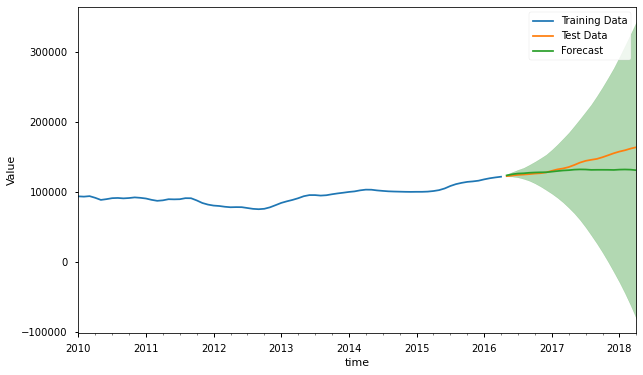

In [52]:
plot_train_test_forecast(train, test, forecast_df)

The forecast closely follows the test data and the test data falls within the confidence interval. We will train this model on the entire time series.

### Final model

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              55411   No. Observations:                  100
Model:             SARIMAX(3, 2, 3)x(4, 1, [], 4)   Log Likelihood                -786.582
Date:                            Thu, 01 Jul 2021   AIC                           1595.163
Time:                                    09:50:21   BIC                           1623.139
Sample:                                01-01-2010   HQIC                          1606.464
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0740      0.617      0.120      0.905      -1.136       1.284
ar.L2          0.9124      0.051     17.829      0.000       0.812       1.013
ar.L3          0.0073      0.557      0.013      0.989      -1.083       1.098
ma.L1         -0.0719      0.605     -0.119      0.905      -1.259       1.115
ma.L2         -0.8055      0.114     -7.050      0.000      -1.029      -0.582
ma.L3         -0.1059      0.469     -0.226      0.821      -1.026       0.814
ar.S.L4       -0.3888      0.035    -10.998      0.000      -0.458      -0.320
ar.S.L8       -0.3210      0.031    -10.209      0.000      -0.383      -0.259
ar.S.L12      -0.2332      0.027     -8.539      0.000      -0.287      -0.180
ar.S.L16      -0.1172      0.023     -5.082      0.000      -0.162      -0.072
sigma2      5.229e+05   4.98e+04     10.507      0.000    4.25e+05     6.2e+05
===================================================================================
Ljung-Box (L1) (Q):                  13.15   Jarque-Bera (JB):                 2.62
Prob(Q):                              0.00   Prob(JB):                         0.27
Heteroskedasticity (H):               0.43   Skew:                             0.40
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.7e+14. Standard errors may be unstable.
"""

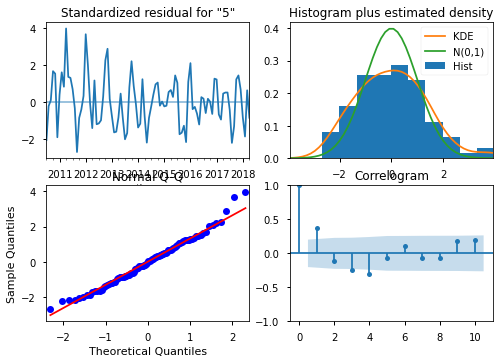

In [53]:
#Create and train SARIMAX model on the full time series
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

The above model performed well as shown by significant p values and an AIC of 4478.830. The diagnostics plots also look improved.

In [54]:
#Retrieve forecast for the next three years
forecast_df = retrieve_forecast(sarimax_model_full, steps=36)
forecast_df

Lower CI    Upper CI    Forecast
2018-05-01 164615.7715 167451.3182 166033.5448
2018-06-01 164518.1249 170865.7475 167691.9362
2018-07-01 164217.0746 175090.4261 169653.7504
2018-08-01 163326.7079 179319.5651 171323.1365
2018-09-01 161818.1683 184883.8386 173351.0035
2018-10-01 159555.6057 190960.2521 175257.9289
2018-11-01 156842.4461 197876.8232 177359.6347
2018-12-01 153418.5568 204959.8666 179189.2117
2019-01-01 149525.4600 213301.8027 181413.6314
2019-02-01 145006.2413 222303.4114 183654.8264
2019-03-01 140043.3415 232219.1090 186131.2253
2019-04-01 134223.8829 242299.6149 188261.7489
2019-05-01 127843.0457 253516.1181 190679.5819
2019-06-01 120831.4590 265458.8022 193145.1306
2019-07-01 113483.2644 278497.4603 195990.3624
2019-08-01 105266.7883 291813.7696 198540.2790
2019-09-01  96410.5297 306295.5764 201353.0531
2019-10-01  86741.0770 321474.4950 204107.7860
2019-11-01  76717.3849 337880.1707 207298.7778
2019-12-01  65734.9726 354639.8432 210187.4079
2020-01-01  54078.5253 372738.2116 213408.3684
2020-02-01  41500.9623 391648.2690 216574.6157
2020-03-01  28461.2507 411897.8385 220179.5446
2020-04-01  14380.8256 432637.8299 223509.3277

In [55]:
#Create function to plot whole time series data and forecast

def plot_time_series_forecast(ts, forecast_df, save=True):
    ### Plot training data, test data, and forecast (with upper/,lower ci) 
    fig,ax = plt.subplots(figsize=(10,6))


    # Plotting time series data
    ts.plot(label='Training Data')
    ax.axvline(ts.index[-1],ls=':')

    ## Plotting Forefcast and CI
    forecast = forecast_df['Forecast']
    LowerCI = forecast_df['Lower CI']
    UpperCI = forecast_df['Upper CI']
    forecast.plot(ax=ax,label='Forecast')
    ax.fill_between(forecast_df.index,
                        LowerCI, 
                        UpperCI,color='g',alpha=0.3)

    ax.set(ylabel='Value')
    ax.legend()
    
    ax.set_title(f'Zip Code {ts.name} Forecast')
    
    if save:
        file_name = f'images/{ts.name}_forecast.png'
        fig.savefig(file_name, dpi=300)
        print(f'Figure save as {file_name}')
    
    return fig, ax

Figure save as images/55411_forecast.png


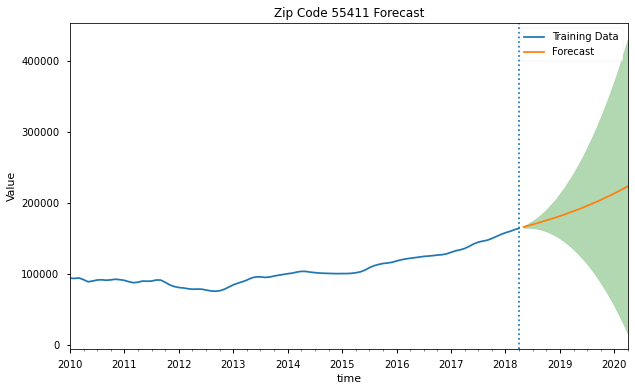

In [56]:
fig, ax = plot_time_series_forecast(ts, forecast_df)

In [57]:
#Create function to calculate and plot ROI of forecast and create dataframe
def calculate_roi(forecast):
    
    investment = forecast_df['Forecast'].iloc[0]
    roi = (forecast_df - investment)/investment
    LowerCI = roi['Lower CI']
    UpperCI = roi['Upper CI']
    roi['Forecast'].plot()
    plt.fill_between(roi.index,
                        LowerCI, 
                        UpperCI,color='g',alpha=0.3)
    plt.title('Forecasted ROI for next 2 Years')
    plt.xlabel('Time')
    plt.ylabel('ROI Percentage')
    plt.tight_layout()
    
    return roi


Lower CI  Upper CI  Forecast
2018-05-01   -0.0085    0.0085    0.0000
2018-06-01   -0.0091    0.0291    0.0100
2018-07-01   -0.0109    0.0545    0.0218
2018-08-01   -0.0163    0.0800    0.0319
2018-09-01   -0.0254    0.1135    0.0441
2018-10-01   -0.0390    0.1501    0.0556
2018-11-01   -0.0554    0.1918    0.0682
2018-12-01   -0.0760    0.2344    0.0792
2019-01-01   -0.0994    0.2847    0.0926
2019-02-01   -0.1266    0.3389    0.1061
2019-03-01   -0.1565    0.3986    0.1210
2019-04-01   -0.1916    0.4593    0.1339
2019-05-01   -0.2300    0.5269    0.1484
2019-06-01   -0.2722    0.5988    0.1633
2019-07-01   -0.3165    0.6774    0.1804
2019-08-01   -0.3660    0.7576    0.1958
2019-09-01   -0.4193    0.8448    0.2127
2019-10-01   -0.4776    0.9362    0.2293
2019-11-01   -0.5379    1.0350    0.2485
2019-12-01   -0.6041    1.1360    0.2659
2020-01-01   -0.6743    1.2450    0.2853
2020-02-01   -0.7500    1.3589    0.3044
2020-03-01   -0.8286    1.4808    0.3261
2020-04-01   -0.9134    1.6057    0.3462

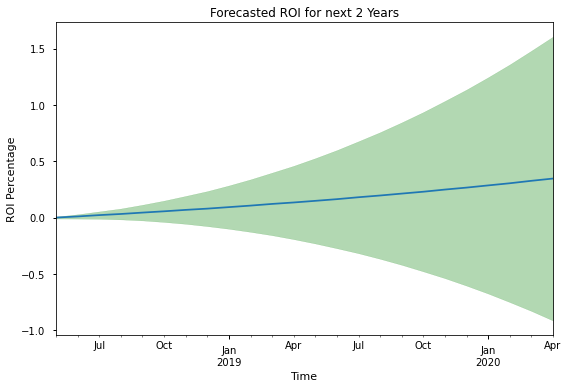

In [58]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 55411 has a predicted ROI of 34.6% after three years. However, the confidence interval ranges from -91% to 160%.

## Zipcode 55412

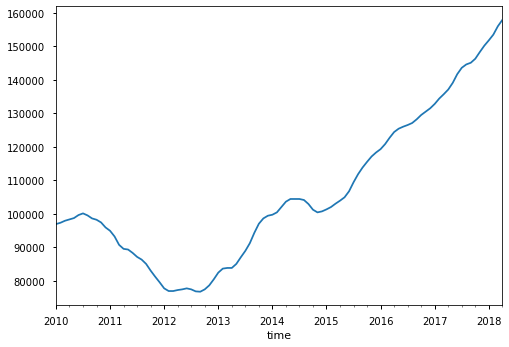

In [59]:
ts = all_time_series_df['55412']
ts.plot();

In [60]:
train, test = train_test_split(ts)

-24

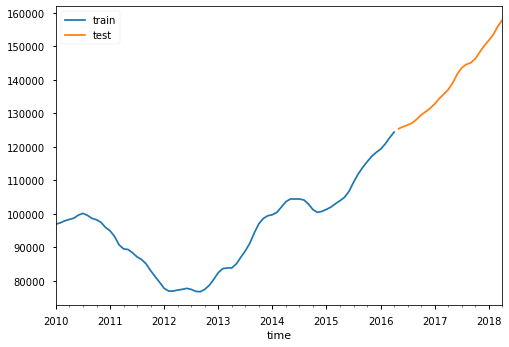

In [61]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -0.9903           5  ...  False        False

[1 rows x 6 columns]

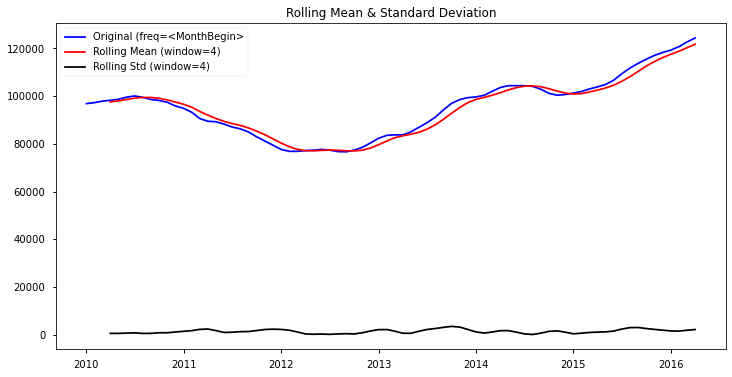

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -0.9903           5  ...  False        False

[1 rows x 6 columns]

In [62]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.1742           9  ...  False        False

[1 rows x 6 columns]

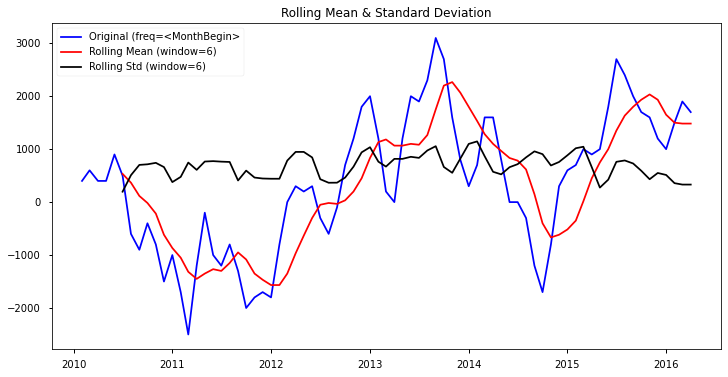

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.1742           9  ...  False        False

[1 rows x 6 columns]

In [63]:
stationarity_check(train.diff().dropna(), window=6)

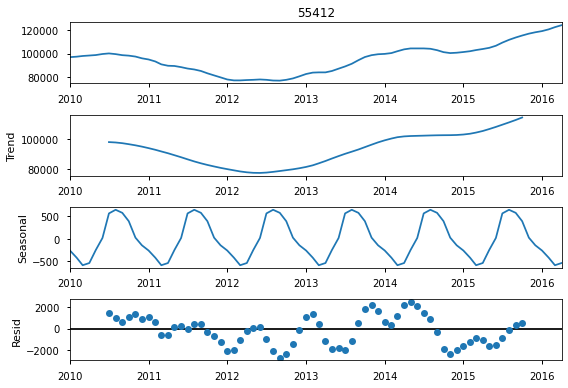

In [64]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

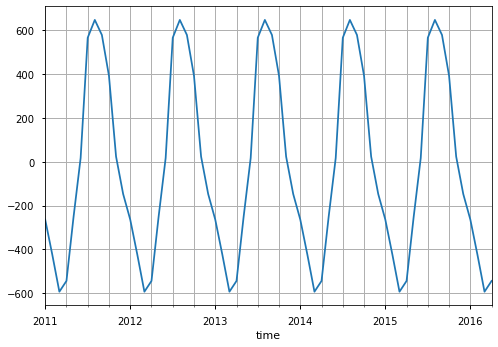

In [65]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1159.879, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1163.912, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1163.572, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1161.681, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1161.740, Time=0.02 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1161.780, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1161.779, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1161.816, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.400 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -578.939
Date:                Thu, 01 Jul 2021   AIC                           1159.879
Time:                        09:50:24   BIC                           1162.183
Sample:                             0   HQIC                          1160.798
                                 - 76                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.653e+05    7.9e+04      4.625      0.000     2.1e+05     5.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   7.54   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.01   Prob(JB):                         0.28
Heteroskedasticity (H):               0.71   Skew:                             0.14
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

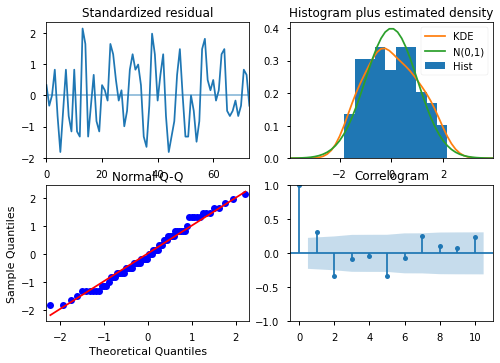

In [66]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

The model has an AIC of 1159.879 and acceptable diagnostics. The optimal order was (0,2,0)(0,0,0)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=1043.756, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=1047.557, Time=0.12 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=1047.543, Time=0.14 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=1045.606, Time=0.07 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=1046.718, Time=0.03 sec
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=1045.706, Time=0.05 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=1045.709, Time=0.05 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,1,0)[12] intercept   : AIC=1045.638, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,1,0)[12]          
Total fit time: 0.685 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   76
Model:             SARIMAX(0, 2, 0)x(0, 1, 0, 12)   Log Likelihood                -520.878
Date:                            Thu, 01 Jul 2021   AIC                           1043.756
Time:                                    09:50:26   BIC                           1045.883
Sample:                                         0   HQIC                          1044.591
                                             - 76                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.154e+06   2.88e+05      4.012      0.000     5.9e+05    1.72e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.65   Jarque-Bera (JB):                 2.46
Prob(Q):                              0.01   Prob(JB):                         0.29
Heteroskedasticity (H):               0.86   Skew:                            -0.07
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

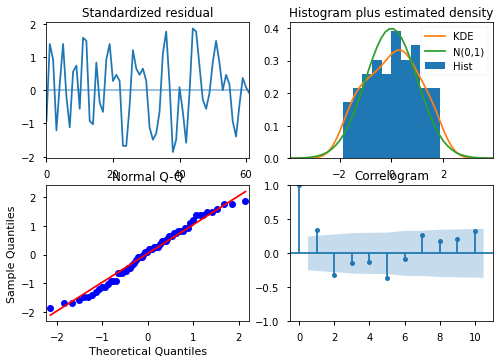

In [67]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=2, D=1,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

The model has an AIC of 1043.756 and acceptable diagnostics. The optimal order was (0,2,0)(0,1,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              55412   No. Observations:                   76
Model:             SARIMAX(0, 2, 0)x(0, 1, 0, 12)   Log Likelihood                -520.878
Date:                            Thu, 01 Jul 2021   AIC                           1043.756
Time:                                    09:50:26   BIC                           1045.883
Sample:                                01-01-2010   HQIC                          1044.591
                                     - 04-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.154e+06   2.88e+05      4.012      0.000     5.9e+05    1.72e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.65   Jarque-Bera (JB):                 2.46
Prob(Q):                              0.01   Prob(JB):                         0.29
Heteroskedasticity (H):               0.86   Skew:                            -0.07
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

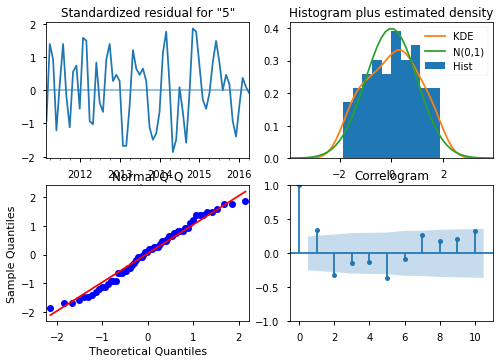

In [68]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

The model has an AIC of 1043.756 and acceptable diagnostics. The optimal order was (0,2,0)(0,1,0)

In [69]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI    Upper CI    Forecast
2016-05-01 124094.6903 128305.3097 126200.0000
2016-06-01 124092.3843 133507.6157 128800.0000
2016-07-01 124422.6523 140177.3477 132300.0000
2016-08-01 123968.7437 147031.2563 135500.0000
2016-09-01 122686.6052 153913.3948 138300.0000
2016-10-01 120716.6252 160883.3748 140800.0000
2016-11-01 118289.6394 168110.3606 143200.0000
2016-12-01 115130.1625 175269.8375 145200.0000
2017-01-01 111458.2812 182541.7188 147000.0000
2017-02-01 107990.8402 190609.1598 149300.0000
2017-03-01 104642.2288 199357.7712 152000.0000
2017-04-01 100824.9231 208175.0769 154500.0000
2017-05-01  95864.7947 218335.2053 157100.0000
2017-06-01  90611.3271 230388.6729 160500.0000
2017-07-01  85298.4200 244301.5800 164800.0000
2017-08-01  78836.4917 258763.5083 168800.0000
2017-09-01  71213.6368 273586.3632 172400.0000
2017-10-01  62599.5950 288800.4050 175700.0000
2017-11-01  53249.8665 304550.1335 178900.0000
2017-12-01  42909.1429 320490.8571 181700.0000
2018-01-01  31813.9411 336786.0589 184300.0000
2018-02-01  20694.5619 354105.4381 187400.0000
2018-03-01   9476.5300 372323.4700 190900.0000
2018-04-01  -2418.3458 390818.3458 194200.0000

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

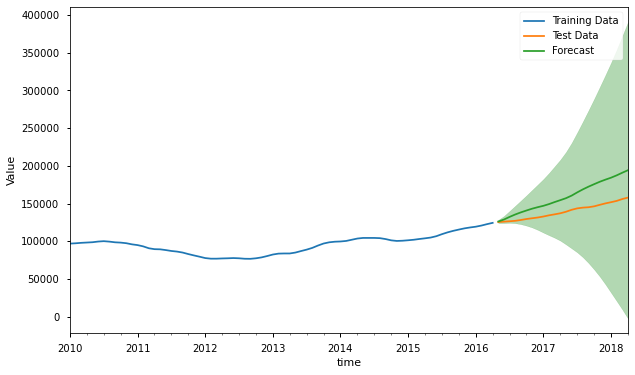

In [70]:
plot_train_test_forecast(train, test, forecast_df)

The forecast closely follows the test data and the test data falls within the confidence interval. We will train this model on the entire time series.

### Final model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              55412   No. Observations:                  100
Model:             SARIMAX(0, 2, 0)x(0, 1, 0, 12)   Log Likelihood                -716.076
Date:                            Thu, 01 Jul 2021   AIC                           1434.152
Time:                                    09:50:27   BIC                           1436.606
Sample:                                01-01-2010   HQIC                          1435.139
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.974e+05   2.02e+05      4.943      0.000    6.02e+05    1.39e+06
===================================================================================
Ljung-Box (L1) (Q):                  10.17   Jarque-Bera (JB):                 2.70
Prob(Q):                              0.00   Prob(JB):                         0.26
Heteroskedasticity (H):               0.50   Skew:                            -0.03
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

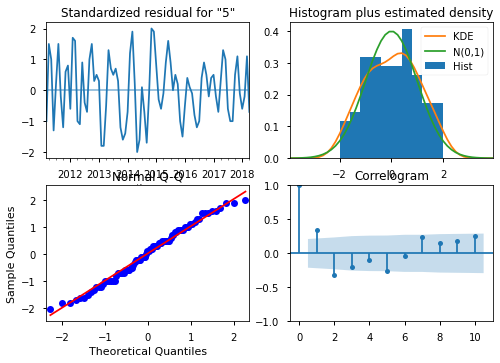

In [71]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [72]:
forecast_df = retrieve_forecast(sarimax_model_full, steps=36)
forecast_df

Lower CI    Upper CI    Forecast
2018-05-01 158442.5829 162357.4171 160400.0000
2018-06-01 159123.0823 167876.9177 163500.0000
2018-07-01 158576.0159 173223.9841 165900.0000
2018-08-01 156678.7851 178121.2149 167400.0000
2018-09-01 153883.4064 182916.5936 168400.0000
2018-10-01 151427.4311 188772.5689 170100.0000
2018-11-01 149439.5288 195760.4712 172600.0000
2018-12-01 147042.4920 202957.5080 175000.0000
2019-01-01 144054.9964 210145.0036 177100.0000
2019-02-01 140892.7035 217707.2965 179300.0000
2019-03-01 138268.9916 226331.0084 182300.0000
2019-04-01 134795.4605 234604.5395 184700.0000
2019-05-01 130766.4119 244633.5881 187700.0000
2019-06-01 126320.8283 256279.1717 191300.0000
2019-07-01 120283.2035 268116.7965 194200.0000
2019-08-01 112556.1989 279843.8011 196200.0000
2019-09-01 103621.7211 291778.2789 197700.0000
2019-10-01  94744.6103 305055.3897 199900.0000
2019-11-01  86076.4683 319723.5317 202900.0000
2019-12-01  76758.8470 334841.1530 205800.0000
2020-01-01  66625.6983 350174.3017 208400.0000
2020-02-01  56105.1942 366094.8058 211100.0000
2020-03-01  45921.0666 383278.9334 214600.0000
2020-04-01  34693.5921 400306.4079 217500.0000

Figure save as images/55412_forecast.png


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Zip Code 55412 Forecast'}, xlabel='time', ylabel='Value'>)

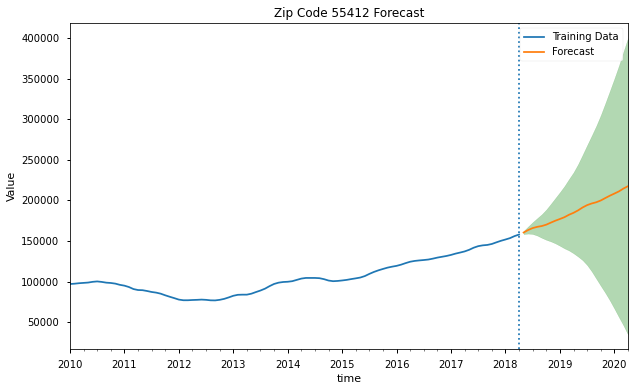

In [73]:
plot_time_series_forecast(ts,forecast_df)

Lower CI  Upper CI  Forecast
2018-05-01   -0.0122    0.0122    0.0000
2018-06-01   -0.0080    0.0466    0.0193
2018-07-01   -0.0114    0.0800    0.0343
2018-08-01   -0.0232    0.1105    0.0436
2018-09-01   -0.0406    0.1404    0.0499
2018-10-01   -0.0559    0.1769    0.0605
2018-11-01   -0.0683    0.2205    0.0761
2018-12-01   -0.0833    0.2653    0.0910
2019-01-01   -0.1019    0.3101    0.1041
2019-02-01   -0.1216    0.3573    0.1178
2019-03-01   -0.1380    0.4110    0.1365
2019-04-01   -0.1596    0.4626    0.1515
2019-05-01   -0.1847    0.5251    0.1702
2019-06-01   -0.2125    0.5978    0.1926
2019-07-01   -0.2501    0.6716    0.2107
2019-08-01   -0.2983    0.7447    0.2232
2019-09-01   -0.3540    0.8191    0.2325
2019-10-01   -0.4093    0.9018    0.2463
2019-11-01   -0.4634    0.9933    0.2650
2019-12-01   -0.5215    1.0875    0.2830
2020-01-01   -0.5846    1.1831    0.2993
2020-02-01   -0.6502    1.2824    0.3161
2020-03-01   -0.7137    1.3895    0.3379
2020-04-01   -0.7837    1.4957    0.3560

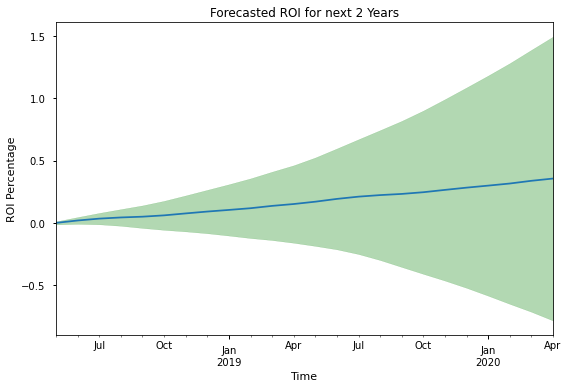

In [74]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 55412 has a predicted ROI of 35.6% after 2 years

## Zipcode 55430

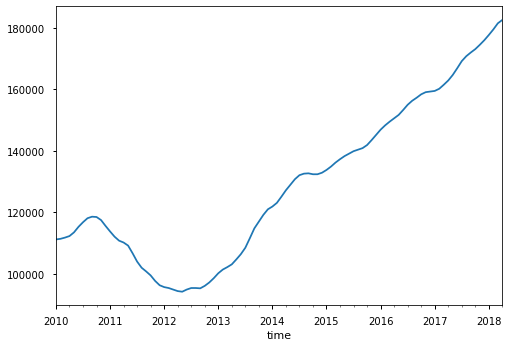

In [75]:
ts = all_time_series_df['55430']
ts.plot();

In [76]:
train, test = train_test_split(ts)

-24

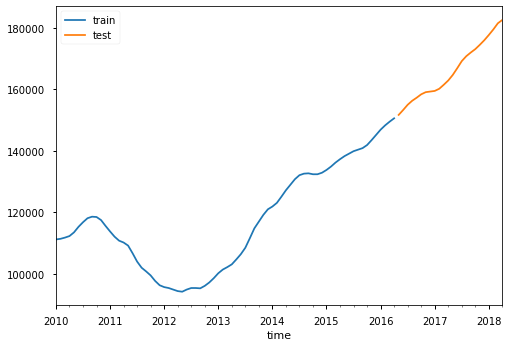

In [77]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results          0.4374          11  ...  False        False

[1 rows x 6 columns]

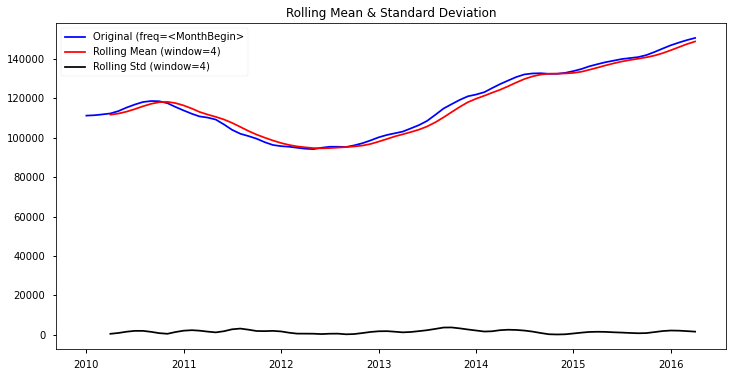

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results          0.4374          11  ...  False        False

[1 rows x 6 columns]

In [78]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.5602          10  ...  False        False

[1 rows x 6 columns]

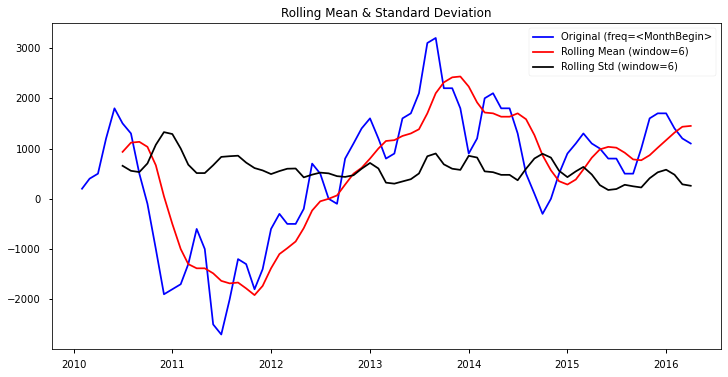

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.5602          10  ...  False        False

[1 rows x 6 columns]

In [79]:
stationarity_check(train.diff().dropna(), window=6)

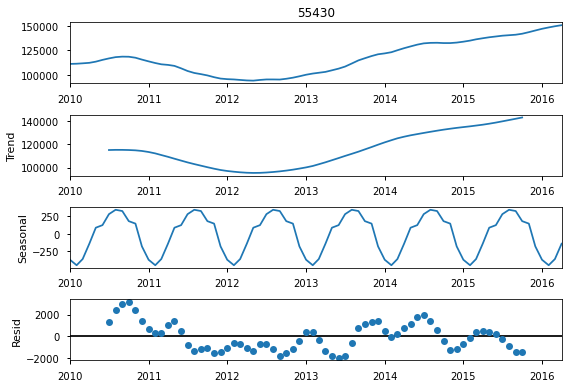

In [80]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

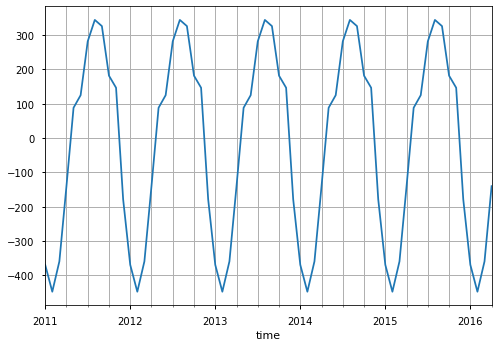

In [81]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1133.152, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1136.437, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1136.421, Time=0.07 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1134.542, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1134.528, Time=0.04 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1135.779, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1135.039, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1135.109, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.484 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -565.576
Date:                Thu, 01 Jul 2021   AIC                           1133.152
Time:                        09:50:30   BIC                           1135.456
Sample:                             0   HQIC                          1134.071
                                 - 76                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.545e+05   4.18e+04      6.088      0.000    1.73e+05    3.36e+05
===================================================================================
Ljung-Box (L1) (Q):                  11.13   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.00   Prob(JB):                         0.56
Heteroskedasticity (H):               0.31   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

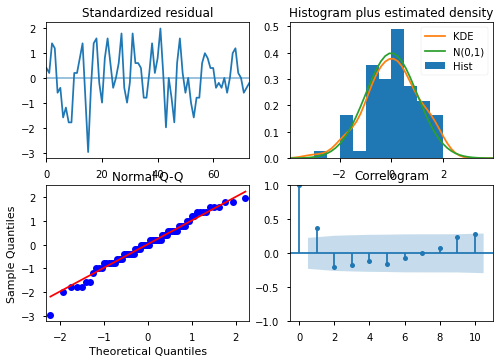

In [82]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1133.152, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1136.437, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1136.421, Time=0.07 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1134.542, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1134.528, Time=0.05 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1135.779, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1135.039, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1135.109, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.470 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -565.576
Date:                Thu, 01 Jul 2021   AIC                           1133.152
Time:                        09:50:31   BIC                           1135.456
Sample:                             0   HQIC                          1134.071
                                 - 76                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.545e+05   4.18e+04      6.088      0.000    1.73e+05    3.36e+05
===================================================================================
Ljung-Box (L1) (Q):                  11.13   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.00   Prob(JB):                         0.56
Heteroskedasticity (H):               0.31   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

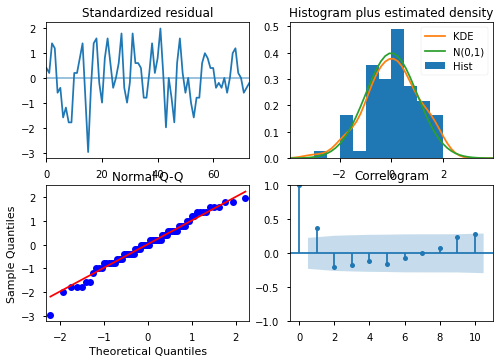

In [83]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=2, D=0,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  55430   No. Observations:                   76
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -565.576
Date:                Thu, 01 Jul 2021   AIC                           1133.152
Time:                        09:50:31   BIC                           1135.456
Sample:                    01-01-2010   HQIC                          1134.071
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.545e+05   4.18e+04      6.088      0.000    1.73e+05    3.36e+05
===================================================================================
Ljung-Box (L1) (Q):                  11.13   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.00   Prob(JB):                         0.56
Heteroskedasticity (H):               0.31   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

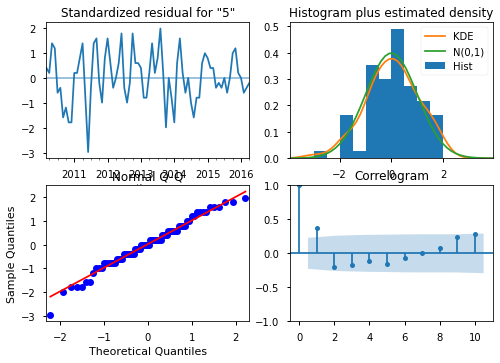

In [84]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [85]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI    Upper CI    Forecast
2016-05-01 150711.1536 152688.8464 151700.0000
2016-06-01 150588.8721 155011.1279 152800.0000
2016-07-01 150200.0754 157599.9246 153900.0000
2016-08-01 149583.8650 160416.1350 155000.0000
2016-09-01 148766.5185 163433.4815 156100.0000
2016-10-01 147767.0062 166632.9938 157200.0000
2016-11-01 146599.8111 170000.1889 158300.0000
2016-12-01 145276.4479 173523.5521 159400.0000
2017-01-01 143806.3508 177193.6492 160500.0000
2017-02-01 142197.4318 181002.5682 161600.0000
2017-03-01 140456.4494 184943.5506 162700.0000
2017-04-01 138589.2636 189010.7364 163800.0000
2017-05-01 136601.0185 193198.9815 164900.0000
2017-06-01 134496.2774 197503.7226 166000.0000
2017-07-01 132279.1237 201920.8763 167100.0000
2017-08-01 129953.2400 206446.7600 168200.0000
2017-09-01 127521.9694 211078.0306 169300.0000
2017-10-01 124988.3644 215811.6356 170400.0000
2017-11-01 122355.2273 220644.7727 171500.0000
2017-12-01 119625.1419 225574.8581 172600.0000
2018-01-01 116800.5008 230599.4992 173700.0000
2018-02-01 113883.5279 235716.4721 174800.0000
2018-03-01 110876.2973 240923.7027 175900.0000
2018-04-01 107780.7493 246219.2507 177000.0000

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

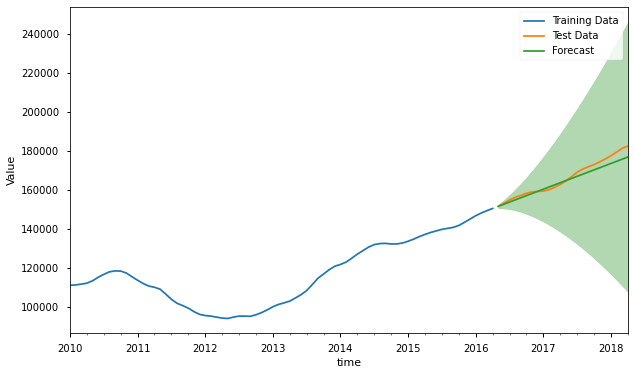

In [86]:
plot_train_test_forecast(train, test, forecast_df)

The forecast closely follows the test data and the test data falls within the confidence interval. We will train this model on the entire time series.

### Final model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  55430   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -743.675
Date:                Thu, 01 Jul 2021   AIC                           1489.349
Time:                        09:50:32   BIC                           1491.934
Sample:                    01-01-2010   HQIC                          1490.395
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.284e+05    3.2e+04      7.146      0.000    1.66e+05    2.91e+05
===================================================================================
Ljung-Box (L1) (Q):                  13.38   Jarque-Bera (JB):                 1.91
Prob(Q):                              0.00   Prob(JB):                         0.38
Heteroskedasticity (H):               0.39   Skew:                            -0.34
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

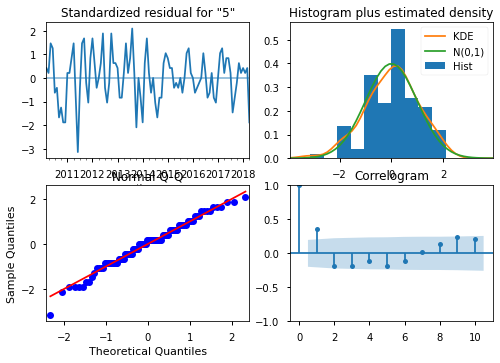

In [87]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [88]:
forecast_df = retrieve_forecast(sarimax_model_full, steps=36)
forecast_df

Lower CI    Upper CI    Forecast
2018-05-01 182763.3523 184636.6477 183700.0000
2018-06-01 182705.5920 186894.4080 184800.0000
2018-07-01 182395.3851 189404.6149 185900.0000
2018-08-01 181869.7691 192130.2309 187000.0000
2018-09-01 181153.6345 195046.3655 188100.0000
2018-10-01 180264.9501 198135.0499 189200.0000
2018-11-01 179217.4346 201382.5654 190300.0000
2018-12-01 178021.9945 204778.0055 191400.0000
2019-01-01 176687.5664 208312.4336 192500.0000
2019-02-01 175221.6444 211978.3556 193600.0000
2019-03-01 173630.6303 215769.3697 194700.0000
2019-04-01 171920.0747 219679.9253 195800.0000
2019-05-01 170094.8503 223705.1497 196900.0000
2019-06-01 168159.2793 227840.7207 198000.0000
2019-07-01 166117.2298 232082.7702 199100.0000
2019-08-01 163972.1899 236427.8101 200200.0000
2019-09-01 161727.3261 240872.6739 201300.0000
2019-10-01 159385.5300 245414.4700 202400.0000
2019-11-01 156949.4558 250050.5442 203500.0000
2019-12-01 154421.5509 254778.4491 204600.0000
2020-01-01 151804.0816 259595.9184 205700.0000
2020-02-01 149099.1546 264500.8454 206800.0000
2020-03-01 146308.7343 269491.2657 207900.0000
2020-04-01 143434.6587 274565.3413 209000.0000

Figure save as images/55430_forecast.png


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Zip Code 55430 Forecast'}, xlabel='time', ylabel='Value'>)

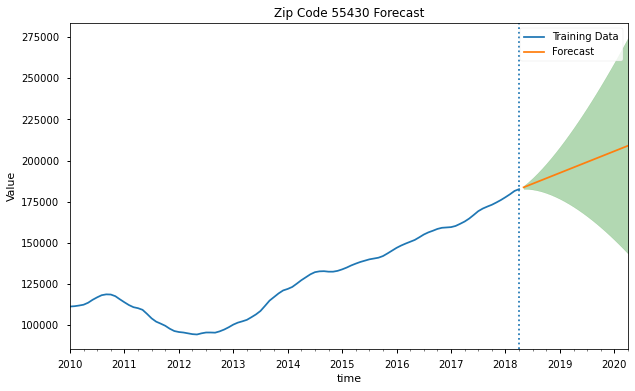

In [89]:
plot_time_series_forecast(ts, forecast_df)

Lower CI  Upper CI  Forecast
2018-05-01   -0.0051    0.0051    0.0000
2018-06-01   -0.0054    0.0174    0.0060
2018-07-01   -0.0071    0.0311    0.0120
2018-08-01   -0.0100    0.0459    0.0180
2018-09-01   -0.0139    0.0618    0.0240
2018-10-01   -0.0187    0.0786    0.0299
2018-11-01   -0.0244    0.0963    0.0359
2018-12-01   -0.0309    0.1147    0.0419
2019-01-01   -0.0382    0.1340    0.0479
2019-02-01   -0.0462    0.1539    0.0539
2019-03-01   -0.0548    0.1746    0.0599
2019-04-01   -0.0641    0.1959    0.0659
2019-05-01   -0.0741    0.2178    0.0719
2019-06-01   -0.0846    0.2403    0.0778
2019-07-01   -0.0957    0.2634    0.0838
2019-08-01   -0.1074    0.2870    0.0898
2019-09-01   -0.1196    0.3112    0.0958
2019-10-01   -0.1324    0.3360    0.1018
2019-11-01   -0.1456    0.3612    0.1078
2019-12-01   -0.1594    0.3869    0.1138
2020-01-01   -0.1736    0.4132    0.1198
2020-02-01   -0.1884    0.4399    0.1257
2020-03-01   -0.2035    0.4670    0.1317
2020-04-01   -0.2192    0.4946    0.1377

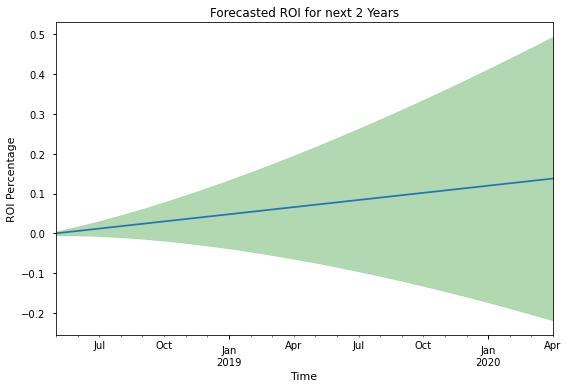

In [90]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56466 has a predicted ROI of 13.7% after three years. However, the confidence interval ranges from -3.7% to 31.5%

## Zipcode 55413

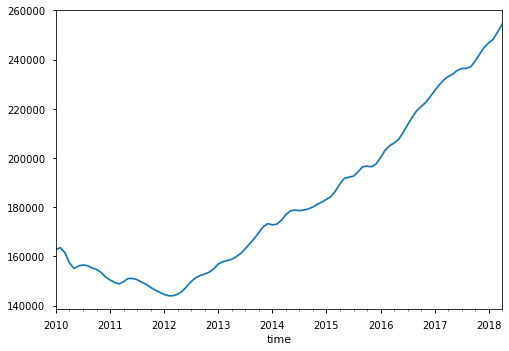

In [91]:
ts = all_time_series_df['55413']
ts.plot();

In [92]:
train, test = train_test_split(ts)

-24

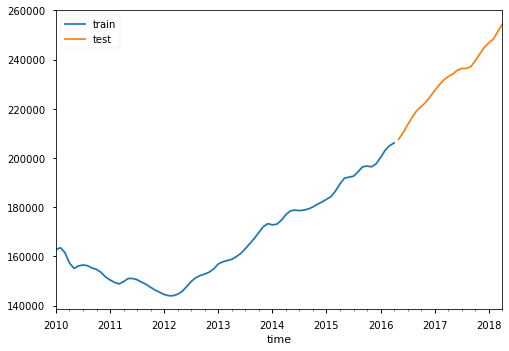

In [93]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results          1.0692           3  ...  False        False

[1 rows x 6 columns]

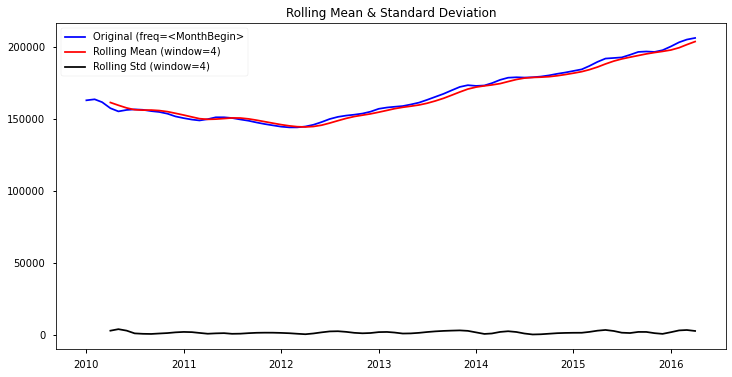

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results          1.0692           3  ...  False        False

[1 rows x 6 columns]

In [94]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.9922           2  ...   True         True

[1 rows x 6 columns]

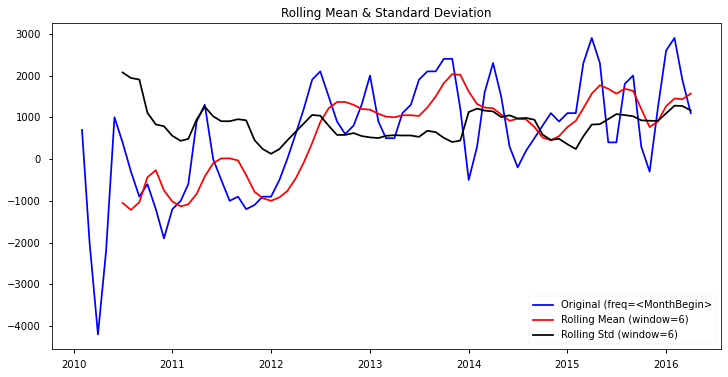

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.9922           2  ...   True         True

[1 rows x 6 columns]

In [95]:
stationarity_check(train.diff().dropna(), window=6)

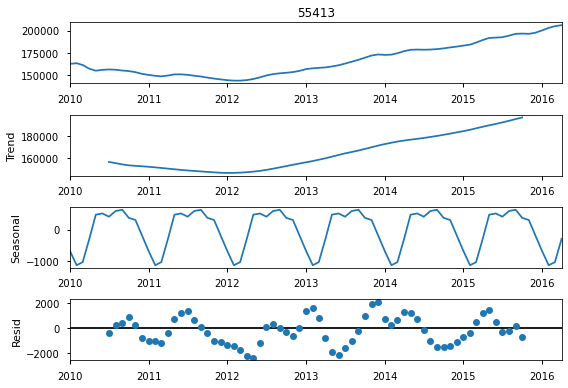

In [96]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

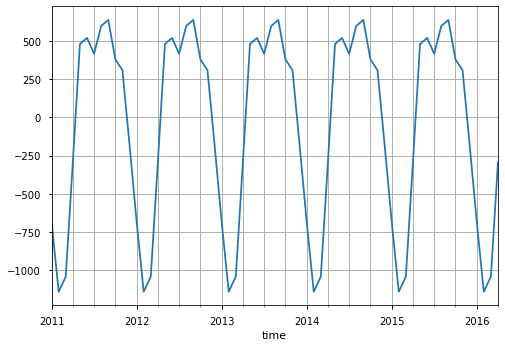

In [97]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1226.354, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1219.588, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1224.853, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1217.589, Time=0.01 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=1219.588, Time=0.02 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=1221.588, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=1216.598, Time=0.06 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=1218.597, Time=0.09 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=1218.597, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=1206.677, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[12]             : AIC=1208.677, Time=0.12 sec
 ARIMA(3,2,0)(0,0,1)[12]             : AIC=1208.677, Time=0.10 sec
 ARIMA(3,2,0)(1,0,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(4,2,0)(0,0,0)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(4, 2, 0)   Log Likelihood                -592.124
Date:                Thu, 01 Jul 2021   AIC                           1194.247
Time:                        09:50:37   BIC                           1205.768
Sample:                             0   HQIC                          1198.843
                                 - 76                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0586      0.080      0.731      0.465      -0.099       0.216
ar.L2          0.0094      0.027      0.343      0.731      -0.044       0.063
ar.L3         -0.0763      0.033     -2.331      0.020      -0.140      -0.012
ar.L4         -0.0613      0.072     -0.851      0.395      -0.202       0.080
sigma2      5.361e+05   9.07e+04      5.912      0.000    3.58e+05    7.14e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.14   Jarque-Bera (JB):                 1.11
Prob(Q):                              0.02   Prob(JB):                         0.57
Heteroskedasticity (H):               2.08   Skew:                            -0.28
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

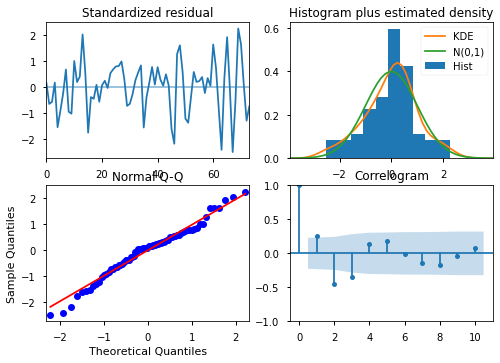

In [98]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1226.354, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1219.588, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1224.853, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1217.589, Time=0.01 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=1219.588, Time=0.02 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=1221.588, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=1216.598, Time=0.06 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=1218.597, Time=0.09 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=1218.597, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=1206.677, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[12]             : AIC=1208.677, Time=0.12 sec
 ARIMA(3,2,0)(0,0,1)[12]             : AIC=1208.677, Time=0.10 sec
 ARIMA(3,2,0)(1,0,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(4,2,0)(0,0,0)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(4, 2, 0)   Log Likelihood                -592.124
Date:                Thu, 01 Jul 2021   AIC                           1194.247
Time:                        09:50:40   BIC                           1205.768
Sample:                             0   HQIC                          1198.843
                                 - 76                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0586      0.080      0.731      0.465      -0.099       0.216
ar.L2          0.0094      0.027      0.343      0.731      -0.044       0.063
ar.L3         -0.0763      0.033     -2.331      0.020      -0.140      -0.012
ar.L4         -0.0613      0.072     -0.851      0.395      -0.202       0.080
sigma2      5.361e+05   9.07e+04      5.912      0.000    3.58e+05    7.14e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.14   Jarque-Bera (JB):                 1.11
Prob(Q):                              0.02   Prob(JB):                         0.57
Heteroskedasticity (H):               2.08   Skew:                            -0.28
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

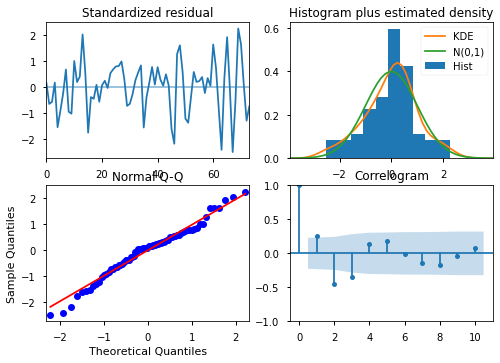

In [99]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=2, D=0,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  55413   No. Observations:                   76
Model:               SARIMAX(4, 2, 0)   Log Likelihood                -592.124
Date:                Thu, 01 Jul 2021   AIC                           1194.247
Time:                        09:50:40   BIC                           1205.768
Sample:                    01-01-2010   HQIC                          1198.843
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0586      0.080      0.731      0.465      -0.099       0.216
ar.L2          0.0094      0.027      0.343      0.731      -0.044       0.063
ar.L3         -0.0763      0.033     -2.331      0.020      -0.140      -0.012
ar.L4         -0.0613      0.072     -0.851      0.395      -0.202       0.080
sigma2      5.361e+05   9.07e+04      5.912      0.000    3.58e+05    7.14e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.14   Jarque-Bera (JB):                 1.11
Prob(Q):                              0.02   Prob(JB):                         0.57
Heteroskedasticity (H):               2.08   Skew:                            -0.28
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

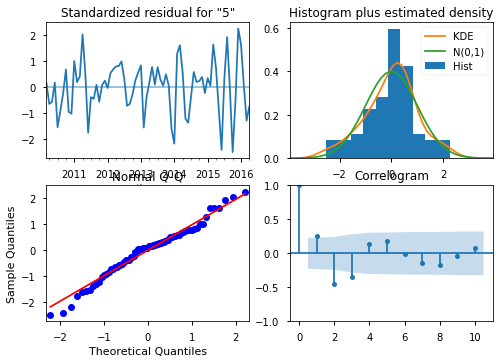

In [100]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [101]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI    Upper CI    Forecast
2016-05-01 205599.9354 208470.0178 207034.9766
2016-06-01 204726.3869 211294.9836 208010.6852
2016-07-01 203545.1962 214674.0007 209109.5984
2016-08-01 202151.9412 218403.5819 210277.7615
2016-09-01 200567.4718 222348.8306 211458.1512
2016-10-01 198771.6036 226484.4129 212628.0083
2016-11-01 196761.6813 230807.3661 213784.5237
2016-12-01 194544.9224 235325.0357 214934.9790
2017-01-01 192132.9038 240037.1120 216085.0079
2017-02-01 189537.0871 244936.1507 217236.6189
2017-03-01 186766.5951 250012.6031 218389.5991
2017-04-01 183828.7628 255257.3942 219543.0785
2017-05-01 180729.8270 260663.1840 220696.5055
2017-06-01 177475.4050 266224.0601 221849.7326
2017-07-01 174070.6788 271934.9720 223002.8254
2017-08-01 170520.4128 277791.3509 224155.8819
2017-09-01 166828.9645 283788.9423 225308.9534
2017-10-01 163000.3158 289923.7802 226462.0480
2017-11-01 159038.1216 296192.1885 227615.1551
2017-12-01 154945.7575 302590.7710 228768.2642
2018-01-01 150726.3574 309116.3844 229921.3709
2018-02-01 146382.8429 315766.1072 231074.4751
2018-03-01 141917.9452 322537.2111 232227.5782
2018-04-01 137334.2238 329427.1386 233380.6812

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

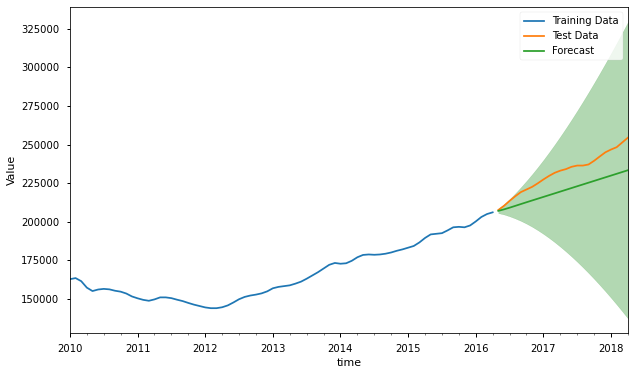

In [102]:
plot_train_test_forecast(train, test, forecast_df)

The forecast closely follows the test data and the test data falls within the confidence interval. We will train this model on the entire time series.

### Final model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  55413   No. Observations:                  100
Model:               SARIMAX(4, 2, 0)   Log Likelihood                -783.248
Date:                Thu, 01 Jul 2021   AIC                           1576.496
Time:                        09:50:41   BIC                           1589.421
Sample:                    01-01-2010   HQIC                          1581.724
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0586      0.069      0.850      0.395      -0.076       0.194
ar.L2          0.0062      0.022      0.276      0.783      -0.038       0.050
ar.L3         -0.0796      0.028     -2.847      0.004      -0.134      -0.025
ar.L4         -0.0622      0.072     -0.861      0.389      -0.204       0.079
sigma2      5.225e+05    7.6e+04      6.874      0.000    3.74e+05    6.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.63   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.02   Prob(JB):                         0.88
Heteroskedasticity (H):               2.01   Skew:                            -0.05
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

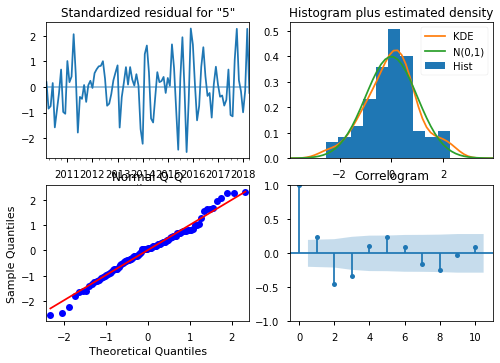

In [103]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [104]:
forecast_df = retrieve_forecast(sarimax_model_full, steps=36)
forecast_df

Lower CI    Upper CI    Forecast
2018-05-01 256272.9467 259106.5474 257689.7470
2018-06-01 257533.4559 264018.5444 260776.0001
2018-07-01 258267.2682 269247.2261 263757.2472
2018-08-01 258715.0156 274734.0915 266724.5535
2018-09-01 258967.8462 280418.2620 269693.0541
2018-10-01 259040.3816 286312.2904 272676.3360
2018-11-01 258925.1658 292411.0969 275668.1313
2018-12-01 258614.2941 298708.2836 278661.2889
2019-01-01 258111.0300 305195.6250 281653.3275
2019-02-01 257424.2645 311863.1594 284643.7120
2019-03-01 256564.2196 318702.4897 287633.3546
2019-04-01 255539.6984 325706.1976 290622.9480
2019-05-01 254357.5931 332867.8772 293612.7352
2019-06-01 253023.5038 340181.8869 296602.6954
2019-07-01 251542.3086 347643.1252 299592.7169
2019-08-01 249918.5008 355246.9608 302582.7308
2019-09-01 248156.2797 362989.1579 305572.7188
2019-10-01 246259.5488 370865.8302 308562.6895
2019-11-01 244231.9130 378873.3989 311552.6559
2019-12-01 242076.6955 387008.5535 314542.6245
2020-01-01 239796.9711 395268.2211 317532.5961
2020-02-01 237395.5996 403649.5392 320522.5694
2020-03-01 234875.2530 412149.8327 323512.5429
2020-04-01 232238.4371 420766.5948 326502.5160

Figure save as images/55413_forecast.png


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Zip Code 55413 Forecast'}, xlabel='time', ylabel='Value'>)

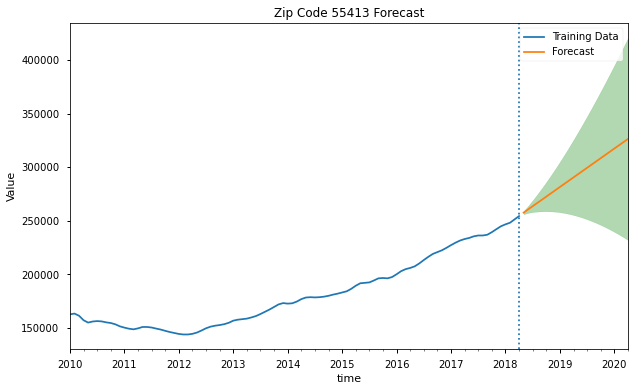

In [105]:
plot_time_series_forecast(ts, forecast_df)

Lower CI  Upper CI  Forecast
2018-05-01   -0.0055    0.0055    0.0000
2018-06-01   -0.0006    0.0246    0.0120
2018-07-01    0.0022    0.0449    0.0235
2018-08-01    0.0040    0.0661    0.0351
2018-09-01    0.0050    0.0882    0.0466
2018-10-01    0.0052    0.1111    0.0582
2018-11-01    0.0048    0.1347    0.0698
2018-12-01    0.0036    0.1592    0.0814
2019-01-01    0.0016    0.1844    0.0930
2019-02-01   -0.0010    0.2102    0.1046
2019-03-01   -0.0044    0.2368    0.1162
2019-04-01   -0.0083    0.2639    0.1278
2019-05-01   -0.0129    0.2917    0.1394
2019-06-01   -0.0181    0.3201    0.1510
2019-07-01   -0.0239    0.3491    0.1626
2019-08-01   -0.0302    0.3786    0.1742
2019-09-01   -0.0370    0.4086    0.1858
2019-10-01   -0.0444    0.4392    0.1974
2019-11-01   -0.0522    0.4703    0.2090
2019-12-01   -0.0606    0.5018    0.2206
2020-01-01   -0.0694    0.5339    0.2322
2020-02-01   -0.0788    0.5664    0.2438
2020-03-01   -0.0885    0.5994    0.2554
2020-04-01   -0.0988    0.6328    0.2670

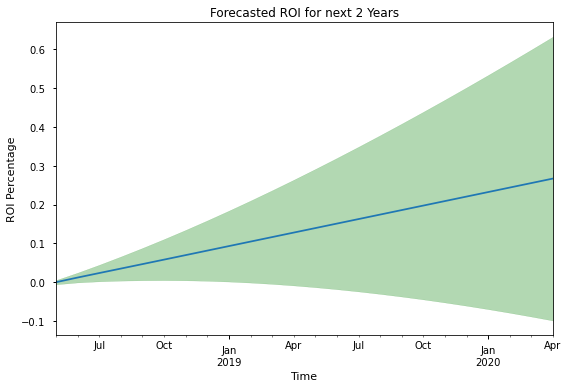

In [106]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56554 has a predicted ROI of 18.6% after three years. However, the confidence interval ranges from -5.5% to 42.8%

## Zipcode 55130

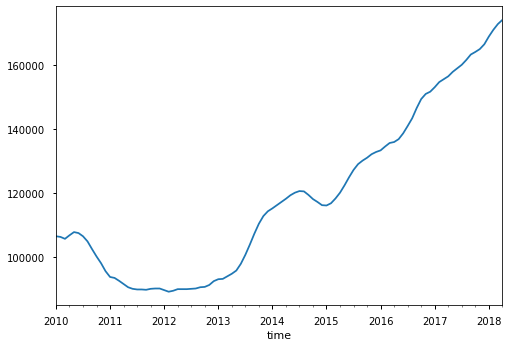

In [107]:
ts = all_time_series_df['55130']
ts.plot();

In [108]:
train, test = train_test_split(ts)

-24

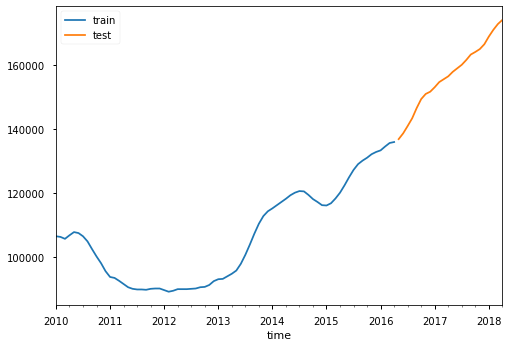

In [109]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -0.2584          12  ...  False        False

[1 rows x 6 columns]

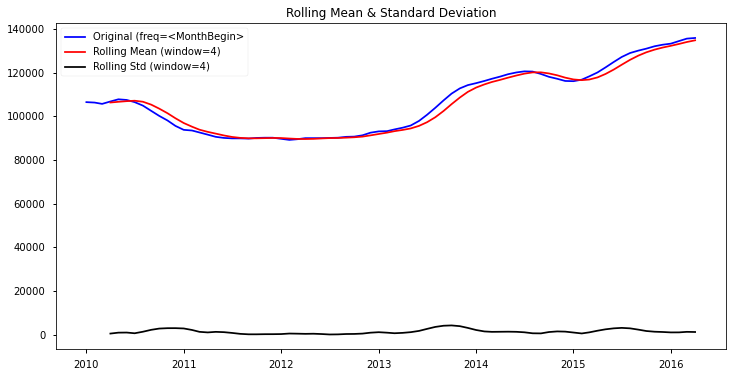

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -0.2584          12  ...  False        False

[1 rows x 6 columns]

In [110]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.3882           8  ...  False        False

[1 rows x 6 columns]

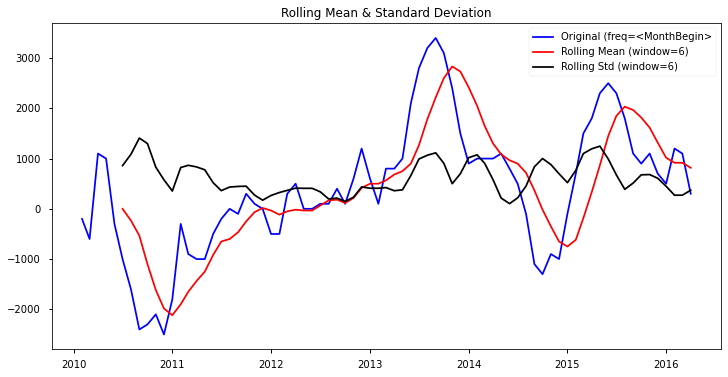

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.3882           8  ...  False        False

[1 rows x 6 columns]

In [111]:
stationarity_check(train.diff().dropna(), window=6)

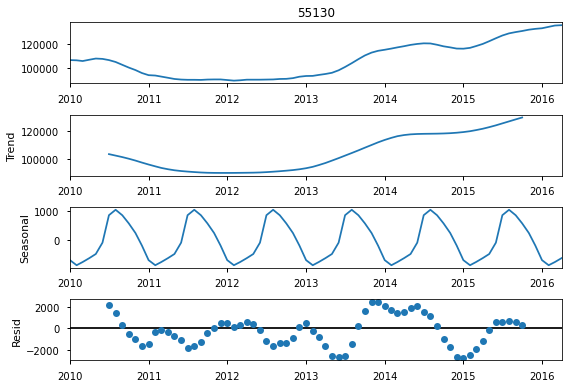

In [112]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

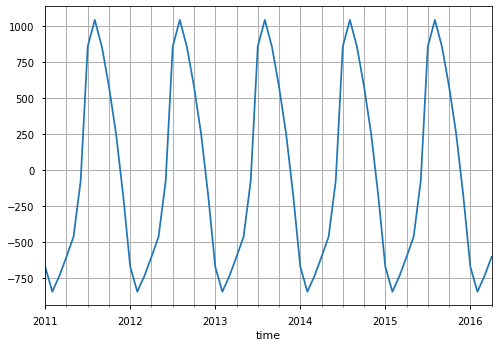

In [113]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1149.057, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1145.075, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1144.310, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1149.263, Time=0.03 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1147.542, Time=0.06 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1146.267, Time=0.16 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1145.755, Time=0.02 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1144.785, Time=0.02 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1141.727, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1147.278, Time=0.06 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1143.412, Time=0.19 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=1143.693, Time=0.13 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1141.909, Time=0.05 sec
 ARIMA(1,2,1)(1,0,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   76
Model:             SARIMAX(4, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -561.307
Date:                              Thu, 01 Jul 2021   AIC                           1134.614
Time:                                      09:50:50   BIC                           1148.439
Sample:                                           0   HQIC                          1140.129
                                               - 76                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0465      0.031      1.494      0.135      -0.015       0.108
ar.L2         -0.0908      0.068     -1.330      0.183      -0.225       0.043
ar.L3          0.0302      0.064      0.475      0.635      -0.095       0.155
ar.L4          0.0553      0.045      1.215      0.225      -0.034       0.144
ma.S.L12      -0.0894      0.077     -1.155      0.248      -0.241       0.062
sigma2      2.021e+05   3.95e+04      5.111      0.000    1.25e+05     2.8e+05
===================================================================================
Ljung-Box (L1) (Q):                  11.49   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.00   Prob(JB):                         0.63
Heteroskedasticity (H):               1.41   Skew:                             0.10
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

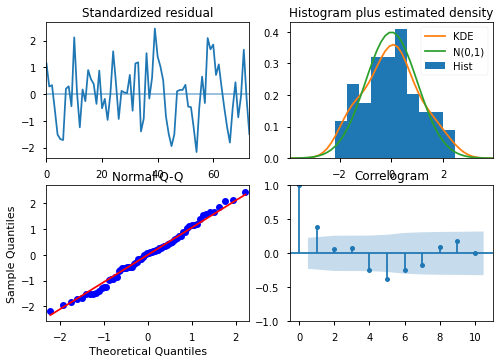

In [114]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1149.057, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1145.075, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1144.310, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1149.263, Time=0.03 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1147.542, Time=0.07 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1146.267, Time=0.16 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1145.755, Time=0.02 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1144.785, Time=0.02 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1141.727, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1147.278, Time=0.06 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1143.412, Time=0.18 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=1143.693, Time=0.12 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1141.909, Time=0.05 sec
 ARIMA(1,2,1)(1,0,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   76
Model:             SARIMAX(4, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -561.307
Date:                              Thu, 01 Jul 2021   AIC                           1134.614
Time:                                      09:50:56   BIC                           1148.439
Sample:                                           0   HQIC                          1140.129
                                               - 76                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0465      0.031      1.494      0.135      -0.015       0.108
ar.L2         -0.0908      0.068     -1.330      0.183      -0.225       0.043
ar.L3          0.0302      0.064      0.475      0.635      -0.095       0.155
ar.L4          0.0553      0.045      1.215      0.225      -0.034       0.144
ma.S.L12      -0.0894      0.077     -1.155      0.248      -0.241       0.062
sigma2      2.021e+05   3.95e+04      5.111      0.000    1.25e+05     2.8e+05
===================================================================================
Ljung-Box (L1) (Q):                  11.49   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.00   Prob(JB):                         0.63
Heteroskedasticity (H):               1.41   Skew:                             0.10
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

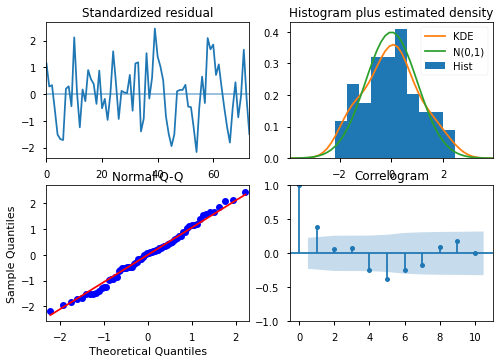

In [115]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=4,
                       start_P=0, max_P=4,
                       start_q=0, max_q=4,
                       start_Q=0, max_Q=4,
                       d=2, D=0,
                       m=12,
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                55130   No. Observations:                   76
Model:             SARIMAX(4, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -561.307
Date:                              Thu, 01 Jul 2021   AIC                           1134.614
Time:                                      09:50:56   BIC                           1148.439
Sample:                                  01-01-2010   HQIC                          1140.129
                                       - 04-01-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0465      0.031      1.494      0.135      -0.015       0.108
ar.L2         -0.0908      0.068     -1.330      0.183      -0.225       0.043
ar.L3          0.0302      0.064      0.475      0.635      -0.095       0.155
ar.L4          0.0553      0.045      1.215      0.225      -0.034       0.144
ma.S.L12      -0.0894      0.077     -1.155      0.248      -0.241       0.062
sigma2      2.021e+05   3.95e+04      5.111      0.000    1.25e+05     2.8e+05
===================================================================================
Ljung-Box (L1) (Q):                  11.49   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.00   Prob(JB):                         0.63
Heteroskedasticity (H):               1.41   Skew:                             0.10
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

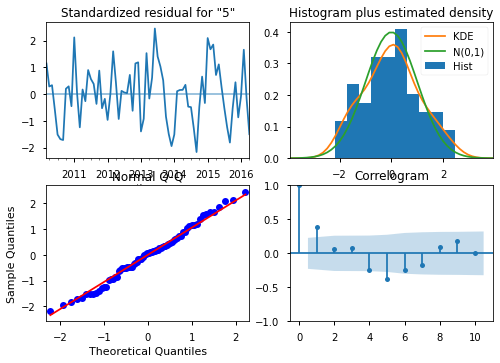

In [116]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [117]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI    Upper CI    Forecast
2016-05-01 135256.1829 137018.6002 136137.3915
2016-06-01 134462.5760 138476.9537 136469.7648
2016-07-01 133481.3834 140126.0394 136803.7114
2016-08-01 132299.1079 141966.2986 137132.7033
2016-09-01 130975.7309 144091.6785 137533.7047
2016-10-01 129498.9382 146431.0998 137965.0190
2016-11-01 127839.9309 148906.9100 138373.4205
2016-12-01 126065.5672 151564.4120 138814.9896
2017-01-01 124161.9194 154374.3719 139268.1457
2017-02-01 122057.9146 157248.3895 139653.1521
2017-03-01 119831.3732 160249.4437 140040.4084
2017-04-01 117554.6551 163438.3776 140496.5163
2017-05-01 115201.3527 166707.0506 140954.2017
2017-06-01 112759.9943 170044.0220 141402.0081
2017-07-01 110238.4283 173464.4084 141851.4184
2017-08-01 107641.0831 176970.2226 142305.6528
2017-09-01 104965.8311 180553.6778 142759.7544
2017-10-01 102212.6303 184213.1982 143212.9142
2017-11-01  99383.2477 187949.3060 143666.2768
2017-12-01  96478.9857 191761.0082 144119.9970
2018-01-01  93500.7001 195646.6588 144573.6795
2018-02-01  90449.4683 199605.0954 145027.2818
2018-03-01  87326.5001 203635.3117 145480.9059
2018-04-01  84132.9335 207736.1803 145934.5569

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

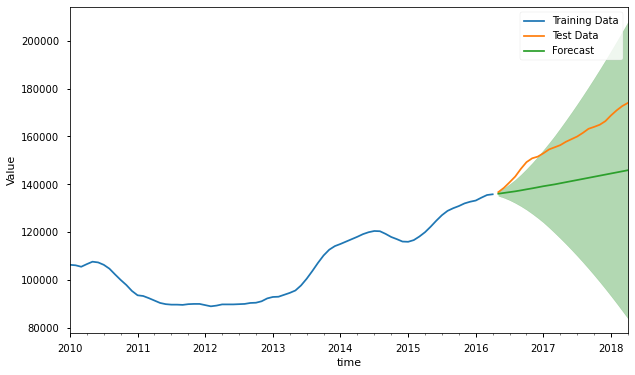

In [118]:
plot_train_test_forecast(train, test, forecast_df)

The forecast closely follows the test data and the test data falls within the confidence interval. We will train this model on the entire time series.

### Final model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                55130   No. Observations:                  100
Model:             SARIMAX(4, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -748.386
Date:                              Thu, 01 Jul 2021   AIC                           1508.773
Time:                                      09:50:57   BIC                           1524.282
Sample:                                  01-01-2010   HQIC                          1515.046
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0411      0.030      1.365      0.172      -0.018       0.100
ar.L2         -0.0884      0.086     -1.033      0.302      -0.256       0.079
ar.L3          0.0239      0.077      0.309      0.757      -0.128       0.176
ar.L4          0.0558      0.063      0.889      0.374      -0.067       0.179
ma.S.L12      -0.0762      0.060     -1.261      0.207      -0.195       0.042
sigma2      2.323e+05   4.06e+04      5.718      0.000    1.53e+05    3.12e+05
===================================================================================
Ljung-Box (L1) (Q):                  10.60   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.00   Prob(JB):                         0.48
Heteroskedasticity (H):               1.89   Skew:                            -0.06
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

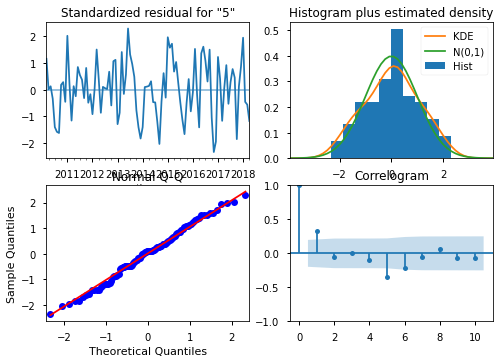

In [119]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [120]:
forecast_df = retrieve_forecast(sarimax_model_full, steps=36)
forecast_df

Lower CI    Upper CI    Forecast
2018-05-01 174370.5231 176259.7573 175315.1402
2018-06-01 174523.6415 178817.7169 176670.6792
2018-07-01 174435.5631 181539.5315 177987.5473
2018-08-01 174080.3587 184406.3128 179243.3358
2018-09-01 173485.9905 187484.4854 180485.2379
2018-10-01 172771.0677 190831.8028 181801.4353
2018-11-01 171883.2915 194344.2918 183113.7916
2018-12-01 170795.9586 197971.7927 184383.8756
2019-01-01 169487.3803 201676.6012 185581.9908
2019-02-01 168060.2423 205543.2987 186801.7705
2019-03-01 166527.3984 209569.0445 188048.2215
2019-04-01 164906.5891 213759.3447 189332.9669
2019-05-01 163193.2495 218033.6169 190613.4332
2019-06-01 161390.4256 222393.9432 191892.1844
2019-07-01 159499.9001 226847.3916 193173.6459
2019-08-01 157522.7403 231392.0676 194457.4039
2019-09-01 155459.2888 236022.1855 195740.7372
2019-10-01 153310.8834 240736.7548 197023.8191
2019-11-01 151078.9865 245535.2820 198307.1342
2019-12-01 148764.9188 250416.2795 199590.5991
2020-01-01 146369.9738 255378.0659 200874.0199
2020-02-01 143895.5194 260419.3149 202157.4171
2020-03-01 141342.9081 265538.7597 203440.8339
2020-04-01 138713.4412 270735.0805 204724.2608

Figure save as images/55130_forecast.png


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Zip Code 55130 Forecast'}, xlabel='time', ylabel='Value'>)

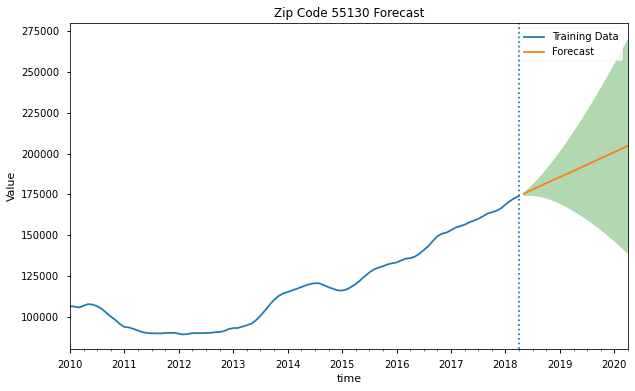

In [121]:
plot_time_series_forecast(ts, forecast_df)

Lower CI  Upper CI  Forecast
2018-05-01   -0.0054    0.0054    0.0000
2018-06-01   -0.0045    0.0200    0.0077
2018-07-01   -0.0050    0.0355    0.0152
2018-08-01   -0.0070    0.0519    0.0224
2018-09-01   -0.0104    0.0694    0.0295
2018-10-01   -0.0145    0.0885    0.0370
2018-11-01   -0.0196    0.1085    0.0445
2018-12-01   -0.0258    0.1292    0.0517
2019-01-01   -0.0332    0.1504    0.0586
2019-02-01   -0.0414    0.1724    0.0655
2019-03-01   -0.0501    0.1954    0.0726
2019-04-01   -0.0594    0.2193    0.0800
2019-05-01   -0.0691    0.2437    0.0873
2019-06-01   -0.0794    0.2685    0.0946
2019-07-01   -0.0902    0.2939    0.1019
2019-08-01   -0.1015    0.3199    0.1092
2019-09-01   -0.1133    0.3463    0.1165
2019-10-01   -0.1255    0.3732    0.1238
2019-11-01   -0.1382    0.4005    0.1311
2019-12-01   -0.1514    0.4284    0.1385
2020-01-01   -0.1651    0.4567    0.1458
2020-02-01   -0.1792    0.4854    0.1531
2020-03-01   -0.1938    0.5146    0.1604
2020-04-01   -0.2088    0.5443    0.1678

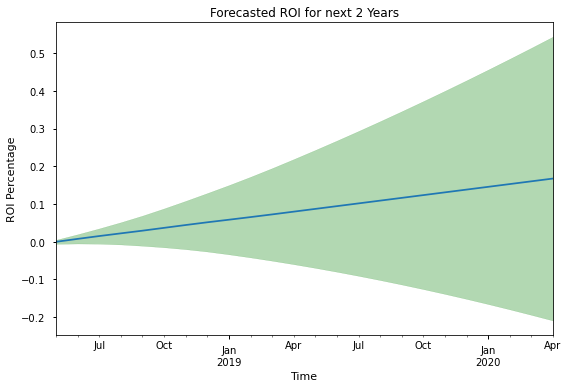

In [122]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56511 has a predicted ROI of 18.4% after three years. However, the confidence interval ranges from -3.7% to 40.6%

## Zipcode 55319

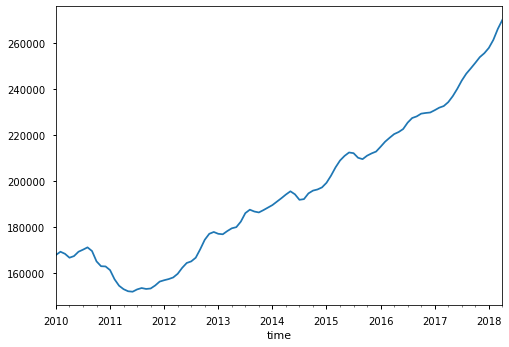

In [123]:
ts = all_time_series_df['55319']
ts.plot();

In [124]:
train, test = train_test_split(ts)

-24

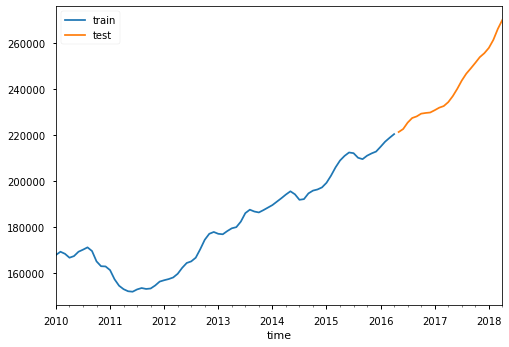

In [125]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -0.1842           8  ...  False        False

[1 rows x 6 columns]

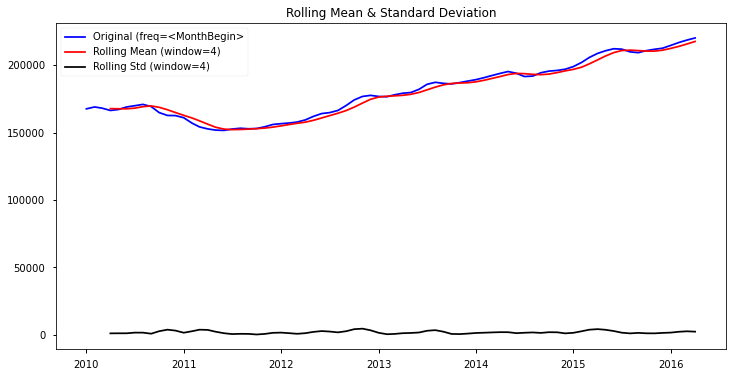

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -0.1842           8  ...  False        False

[1 rows x 6 columns]

In [126]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.0348           8  ...  False        False

[1 rows x 6 columns]

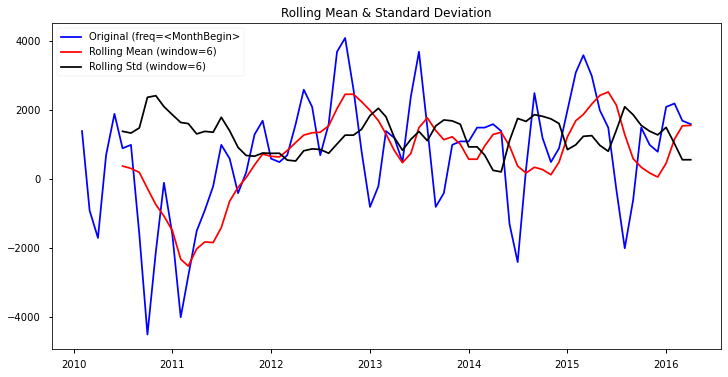

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.0348           8  ...  False        False

[1 rows x 6 columns]

In [127]:
stationarity_check(train.diff().dropna(), window=6)

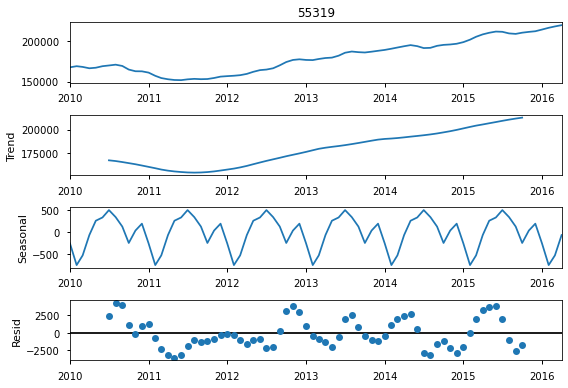

In [128]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

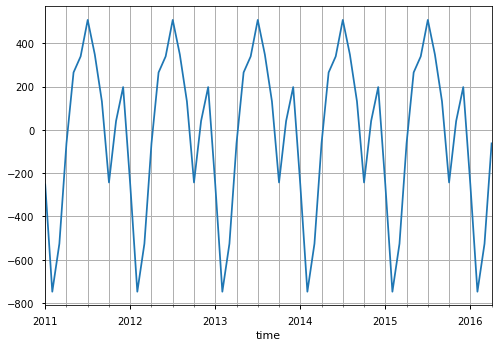

In [129]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1280.101, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1279.794, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1280.265, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1278.316, Time=0.01 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=1279.789, Time=0.03 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=1281.763, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=1295.597, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1280.304, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1278.314, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1280.271, Time=0.02 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1282.238, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1291.335, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1294.293, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=1280.279, Time=0.05 sec

Best model:  ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -637.157
Date:                Thu, 01 Jul 2021   AIC                           1278.314
Time:                        09:51:00   BIC                           1282.922
Sample:                             0   HQIC                          1280.152
                                 - 76                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0300      0.057      0.522      0.602      -0.083       0.143
sigma2      1.754e+06   3.51e+05      4.995      0.000    1.07e+06    2.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.93   Jarque-Bera (JB):                 1.45
Prob(Q):                              0.09   Prob(JB):                         0.49
Heteroskedasticity (H):               0.81   Skew:                            -0.17
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

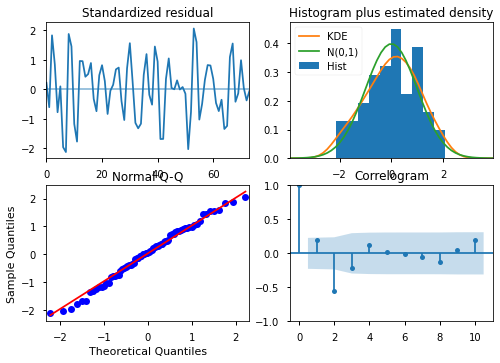

In [130]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1280.101, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1279.794, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1280.265, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1278.316, Time=0.01 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=1279.789, Time=0.03 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=1281.763, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=1295.597, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1280.304, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1278.314, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1280.271, Time=0.02 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1282.238, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1291.335, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1294.293, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=1280.279, Time=0.05 sec

Best model:  ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -637.157
Date:                Thu, 01 Jul 2021   AIC                           1278.314
Time:                        09:51:01   BIC                           1282.922
Sample:                             0   HQIC                          1280.152
                                 - 76                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0300      0.057      0.522      0.602      -0.083       0.143
sigma2      1.754e+06   3.51e+05      4.995      0.000    1.07e+06    2.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.93   Jarque-Bera (JB):                 1.45
Prob(Q):                              0.09   Prob(JB):                         0.49
Heteroskedasticity (H):               0.81   Skew:                            -0.17
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

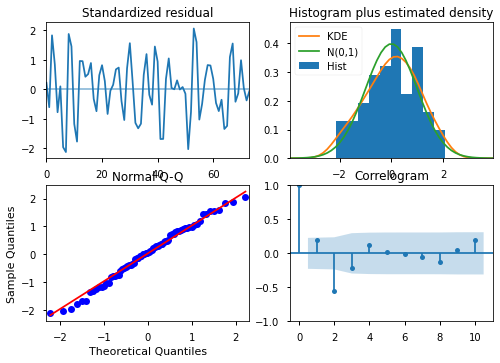

In [131]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=2, D=0,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  55319   No. Observations:                   76
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -637.157
Date:                Thu, 01 Jul 2021   AIC                           1278.314
Time:                        09:51:02   BIC                           1282.922
Sample:                    01-01-2010   HQIC                          1280.152
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0300      0.057      0.522      0.602      -0.083       0.143
sigma2      1.754e+06   3.51e+05      4.995      0.000    1.07e+06    2.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.93   Jarque-Bera (JB):                 1.45
Prob(Q):                              0.09   Prob(JB):                         0.49
Heteroskedasticity (H):               0.81   Skew:                            -0.17
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

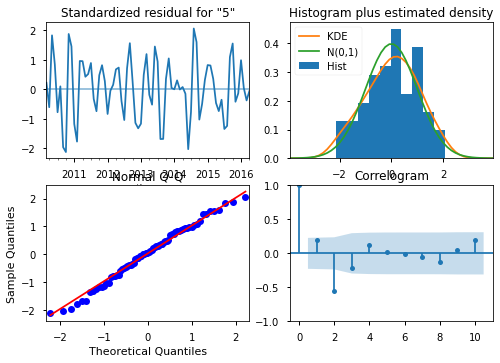

In [132]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [133]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI    Upper CI    Forecast
2016-05-01 219301.9889 224492.9169 221897.4529
2016-06-01 217621.5657 229368.2458 223494.9057
2016-07-01 215214.5071 234970.2101 225092.3586
2016-08-01 212189.5773 241190.0456 226689.8115
2016-09-01 208618.9262 247955.6025 228287.2643
2016-10-01 204554.3987 255215.0357 229884.7172
2016-11-01 200035.4819 262928.8582 231482.1700
2016-12-01 195093.5216 271065.7242 233079.6229
2017-01-01 189754.1752 279599.9763 234677.0758
2017-02-01 184038.9432 288510.1141 236274.5286
2017-03-01 177966.1809 297777.7821 237871.9815
2017-04-01 171551.7963 307387.0724 239469.4344
2017-05-01 164809.7492 317324.0253 241066.8872
2017-06-01 157752.4184 327576.2618 242664.3401
2017-07-01 150390.8791 338132.7069 244261.7930
2017-08-01 142735.1164 348983.3753 245859.2458
2017-09-01 134794.1933 360119.2040 247456.6987
2017-10-01 126576.3843 371531.9188 249054.1516
2017-11-01 118089.2831 383213.9258 250651.6044
2017-12-01 109339.8914 395158.2231 252249.0573
2018-01-01 100334.6921 407358.3282 253846.5101
2018-02-01  91079.7098 419808.2162 255443.9630
2018-03-01  81580.5630 432502.2688 257041.4159
2018-04-01  71842.5073 445435.2302 258638.8687

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

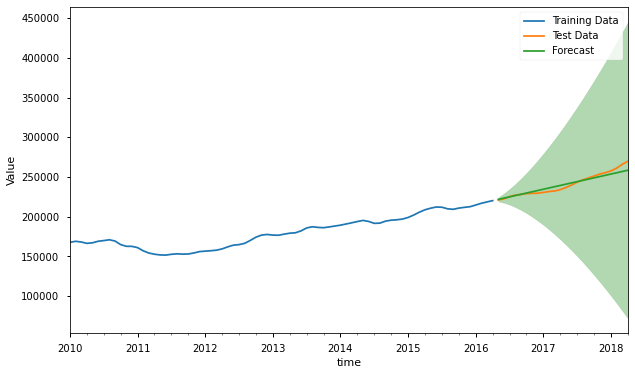

In [134]:
plot_train_test_forecast(train, test, forecast_df)

The forecast closely follows the test data and the test data falls within the confidence interval. We will train this model on the entire time series.

### Final model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  55319   No. Observations:                  100
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -835.680
Date:                Thu, 01 Jul 2021   AIC                           1675.359
Time:                        09:51:02   BIC                           1680.529
Sample:                    01-01-2010   HQIC                          1677.450
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0346      0.042      0.821      0.412      -0.048       0.117
sigma2      1.326e+06   1.91e+05      6.939      0.000    9.51e+05     1.7e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.17   Jarque-Bera (JB):                 1.05
Prob(Q):                              0.07   Prob(JB):                         0.59
Heteroskedasticity (H):               0.42   Skew:                            -0.18
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

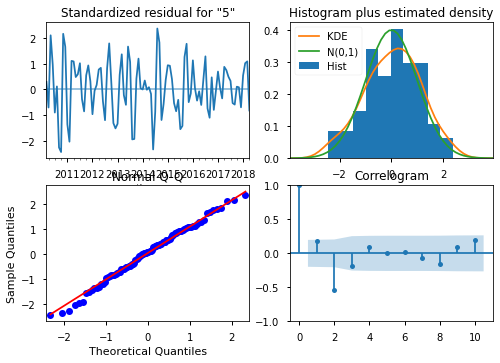

In [135]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [136]:
forecast_df = retrieve_forecast(sarimax_model_full, steps=36)
forecast_df

Lower CI    Upper CI    Forecast
2018-05-01 271610.7704 276123.8869 273867.3286
2018-06-01 272618.8373 282850.4772 277734.6573
2018-07-01 272991.5139 290212.4579 281601.9859
2018-08-01 272824.1790 298114.4501 285469.3145
2018-09-01 272179.9873 306493.2990 289336.6432
2018-10-01 271104.2899 315303.6537 293203.9718
2018-11-01 269631.6155 324510.9854 297071.3004
2018-12-01 267789.3681 334087.8900 300938.6291
2019-01-01 265599.9752 344011.9402 304805.9577
2019-02-01 263082.2285 354264.3442 308673.2863
2019-03-01 260252.1696 364829.0604 312540.6150
2019-04-01 257123.7001 375692.1871 316407.9436
2019-05-01 253709.0187 386841.5258 320275.2722
2019-06-01 250018.9418 398266.2599 324142.6009
2019-07-01 246063.1465 409956.7125 328009.9295
2019-08-01 241850.3571 421904.1592 331877.2581
2019-09-01 237388.4921 434100.6815 335744.5868
2019-10-01 232684.7805 446539.0503 339611.9154
2019-11-01 227745.8570 459212.6311 343479.2440
2019-12-01 222577.8384 472115.3069 347346.5727
2020-01-01 217186.3884 485241.4142 351213.9013
2020-02-01 211576.7703 498585.6896 355081.2299
2020-03-01 205753.8922 512143.2249 358948.5586
2020-04-01 199722.3456 525909.4288 362815.8872

Figure save as images/55319_forecast.png


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Zip Code 55319 Forecast'}, xlabel='time', ylabel='Value'>)

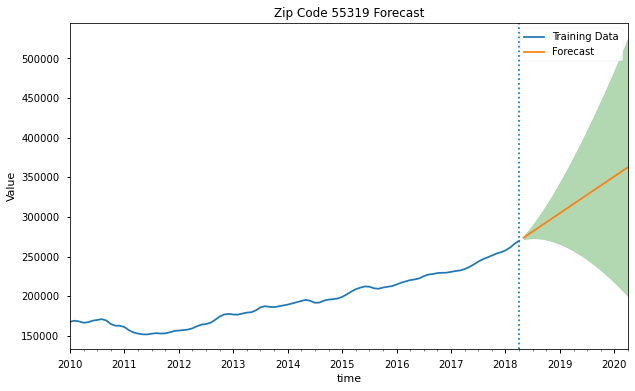

In [137]:
plot_time_series_forecast(ts, forecast_df)

Lower CI  Upper CI  Forecast
2018-05-01   -0.0082    0.0082    0.0000
2018-06-01   -0.0046    0.0328    0.0141
2018-07-01   -0.0032    0.0597    0.0282
2018-08-01   -0.0038    0.0885    0.0424
2018-09-01   -0.0062    0.1191    0.0565
2018-10-01   -0.0101    0.1513    0.0706
2018-11-01   -0.0155    0.1849    0.0847
2018-12-01   -0.0222    0.2199    0.0988
2019-01-01   -0.0302    0.2561    0.1130
2019-02-01   -0.0394    0.2936    0.1271
2019-03-01   -0.0497    0.3321    0.1412
2019-04-01   -0.0611    0.3718    0.1553
2019-05-01   -0.0736    0.4125    0.1695
2019-06-01   -0.0871    0.4542    0.1836
2019-07-01   -0.1015    0.4969    0.1977
2019-08-01   -0.1169    0.5405    0.2118
2019-09-01   -0.1332    0.5851    0.2259
2019-10-01   -0.1504    0.6305    0.2401
2019-11-01   -0.1684    0.6768    0.2542
2019-12-01   -0.1873    0.7239    0.2683
2020-01-01   -0.2070    0.7718    0.2824
2020-02-01   -0.2274    0.8205    0.2965
2020-03-01   -0.2487    0.8700    0.3107
2020-04-01   -0.2707    0.9203    0.3248

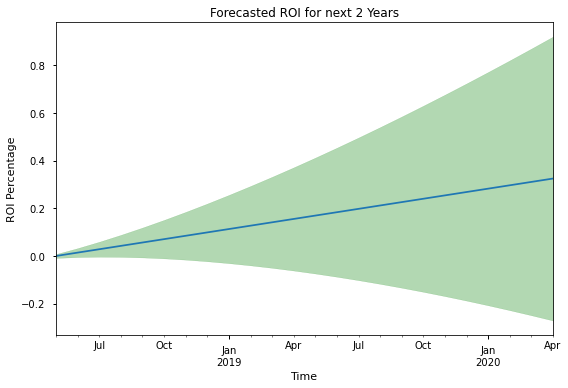

In [138]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56443 has a predicted ROI of 14.1% after three years. However, the confidence interval ranges from -23.4% to 51.7%

## Zipcode 56672

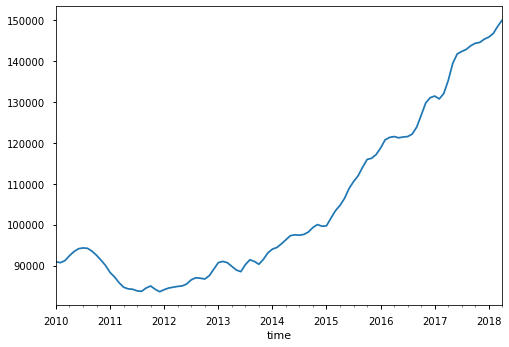

In [139]:
ts = all_time_series_df['56672']
ts.plot();

In [140]:
train, test = train_test_split(ts)

-24

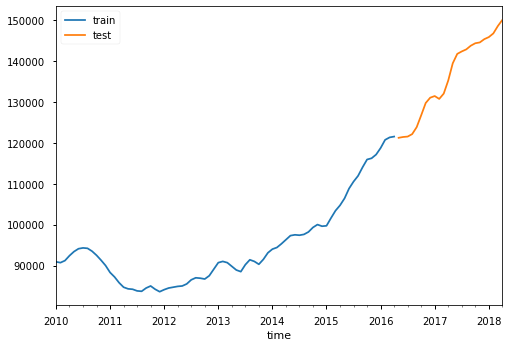

In [141]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results          0.8746           7  ...  False        False

[1 rows x 6 columns]

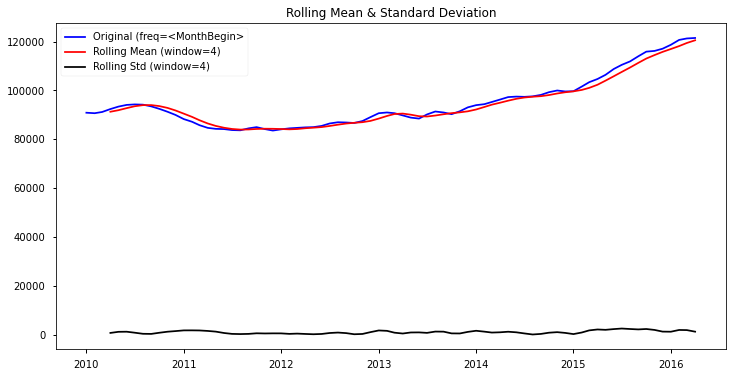

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results          0.8746           7  ...  False        False

[1 rows x 6 columns]

In [142]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.1746           6  ...  False        False

[1 rows x 6 columns]

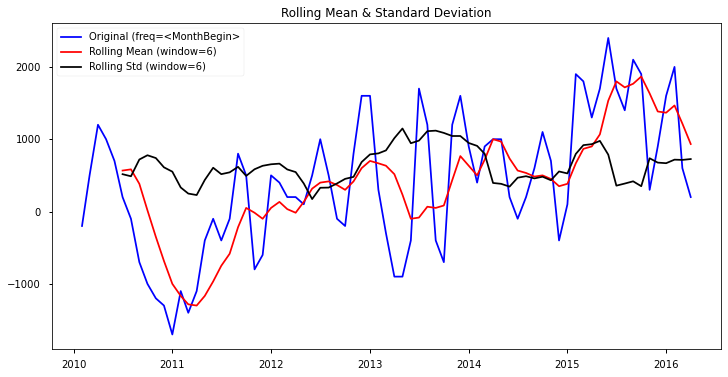

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.1746           6  ...  False        False

[1 rows x 6 columns]

In [143]:
stationarity_check(train.diff().dropna(), window=6)

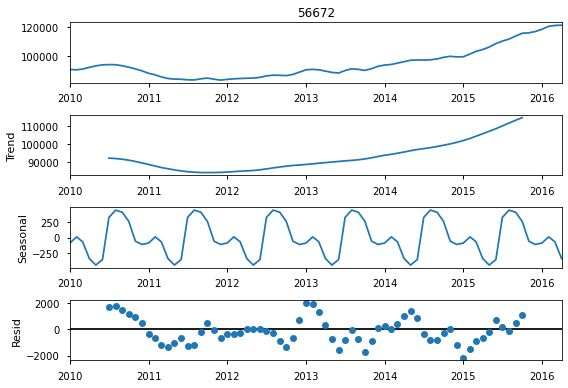

In [144]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

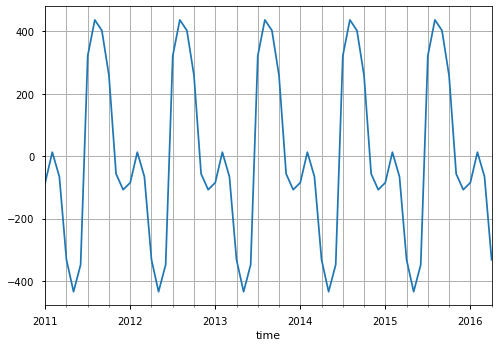

In [145]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1186.037, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1188.621, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1188.593, Time=0.02 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1187.059, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1187.047, Time=0.05 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1189.042, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1187.586, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1187.536, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1187.951, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1188.033, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.442 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -592.019
Date:                Thu, 01 Jul 2021   AIC                           1186.037
Time:                        09:51:06   BIC                           1188.341
Sample:                             0   HQIC                          1186.956
                                 - 76                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.201e+05   7.32e+04      7.105      0.000    3.77e+05    6.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):                 2.77
Prob(Q):                              0.25   Prob(JB):                         0.25
Heteroskedasticity (H):               1.89   Skew:                             0.31
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

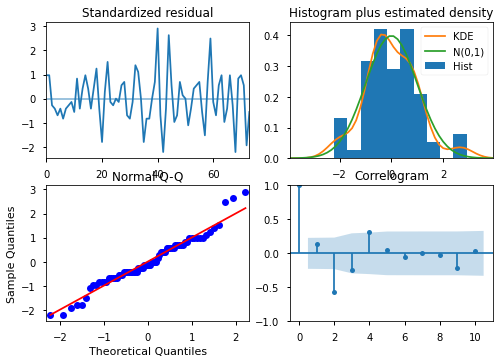

In [146]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1186.037, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1188.621, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1188.593, Time=0.02 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1187.059, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1187.047, Time=0.04 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1189.042, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1187.586, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1187.536, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1187.951, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1188.033, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.364 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -592.019
Date:                Thu, 01 Jul 2021   AIC                           1186.037
Time:                        09:51:06   BIC                           1188.341
Sample:                             0   HQIC                          1186.956
                                 - 76                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.201e+05   7.32e+04      7.105      0.000    3.77e+05    6.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):                 2.77
Prob(Q):                              0.25   Prob(JB):                         0.25
Heteroskedasticity (H):               1.89   Skew:                             0.31
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

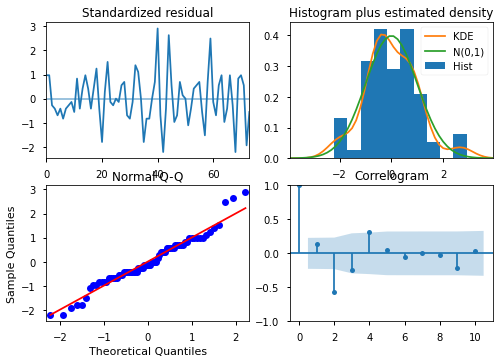

In [147]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=2, D=0,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  56672   No. Observations:                   76
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -592.019
Date:                Thu, 01 Jul 2021   AIC                           1186.037
Time:                        09:51:07   BIC                           1188.341
Sample:                    01-01-2010   HQIC                          1186.956
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.201e+05   7.32e+04      7.105      0.000    3.77e+05    6.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):                 2.77
Prob(Q):                              0.25   Prob(JB):                         0.25
Heteroskedasticity (H):               1.89   Skew:                             0.31
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

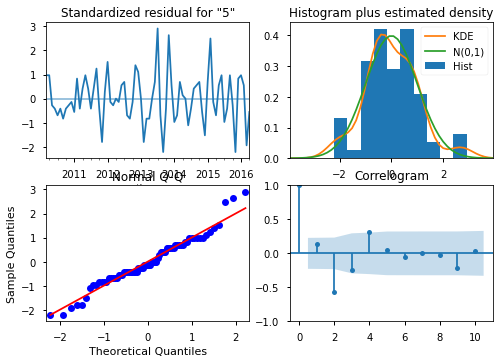

In [148]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [149]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI    Upper CI    Forecast
2016-05-01 120286.4616 123113.5384 121700.0000
2016-06-01 118739.2320 125060.7680 121900.0000
2016-07-01 116811.0235 127388.9765 122100.0000
2016-08-01 114557.7312 130042.2688 122300.0000
2016-09-01 112016.9185 132983.0815 122500.0000
2016-10-01 109215.7029 136184.2971 122700.0000
2016-11-01 106174.7879 139625.2121 122900.0000
2016-12-01 102910.6331 143289.3669 123100.0000
2017-01-01  99436.7249 147163.2751 123300.0000
2017-02-01  95764.3734 151235.6266 123500.0000
2017-03-01  91903.2395 155496.7605 123700.0000
2017-04-01  87861.7000 159938.3000 123900.0000
2017-05-01  83647.1086 164552.8914 124100.0000
2017-06-01  79265.9881 169334.0119 124300.0000
2017-07-01  74724.1758 174275.8242 124500.0000
2017-08-01  70026.9359 179373.0641 124700.0000
2017-09-01  65179.0472 184620.9528 124900.0000
2017-10-01  60184.8736 190015.1264 125100.0000
2017-11-01  55048.4204 195551.5796 125300.0000
2017-12-01  49773.3812 201226.6188 125500.0000
2018-01-01  44363.1765 207036.8235 125700.0000
2018-02-01  38820.9851 212979.0149 125900.0000
2018-03-01  33149.7719 219050.2281 126100.0000
2018-04-01  27352.3105 225247.6895 126300.0000

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

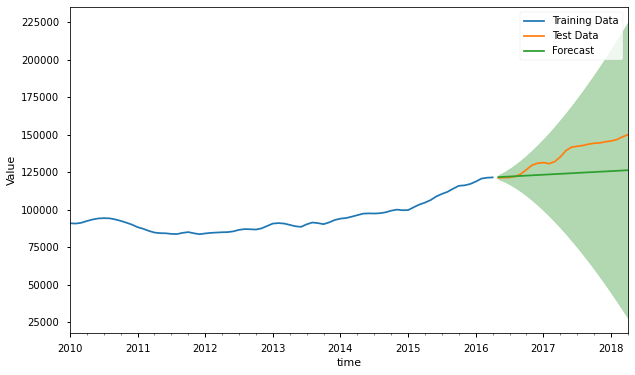

In [150]:
plot_train_test_forecast(train, test, forecast_df)

The forecast closely follows the test data and the test data falls within the confidence interval. We will train this model on the entire time series.

### Final model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  56672   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -795.054
Date:                Thu, 01 Jul 2021   AIC                           1592.107
Time:                        09:51:08   BIC                           1594.692
Sample:                    01-01-2010   HQIC                          1593.153
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.517e+05   8.51e+04      7.655      0.000    4.85e+05    8.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.68   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.03   Prob(JB):                         0.64
Heteroskedasticity (H):               3.39   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

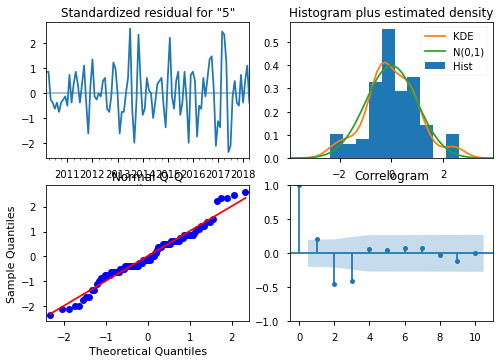

In [151]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [152]:
forecast_df = retrieve_forecast(sarimax_model_full, steps=36)
forecast_df

Lower CI    Upper CI    Forecast
2018-05-01 149917.8175 153082.1825 151500.0000
2018-06-01 149462.1324 156537.8676 153000.0000
2018-07-01 148580.0152 160419.9848 154500.0000
2018-08-01 147334.0296 164665.9704 156000.0000
2018-09-01 145766.2206 169233.7794 157500.0000
2018-10-01 143906.9409 174093.0591 159000.0000
2018-11-01 141779.3642 179220.6358 160500.0000
2018-12-01 139401.9139 184598.0861 162000.0000
2019-01-01 136789.6852 190210.3148 163500.0000
2019-02-01 133955.3377 196044.6623 165000.0000
2019-03-01 130909.6848 202090.3152 166500.0000
2019-04-01 127662.1029 208337.8971 168000.0000
2019-05-01 124220.8228 214779.1772 169500.0000
2019-06-01 120593.1455 221406.8545 171000.0000
2019-07-01 116785.6050 228214.3950 172500.0000
2019-08-01 112804.0935 235195.9065 174000.0000
2019-09-01 108653.9597 242346.0403 175500.0000
2019-10-01 104340.0883 249659.9117 177000.0000
2019-11-01  99866.9624 257133.0376 178500.0000
2019-12-01  95238.7165 264761.2835 180000.0000
2020-01-01  90459.1788 272540.8212 181500.0000
2020-02-01  85531.9077 280468.0923 183000.0000
2020-03-01  80460.2216 288539.7784 184500.0000
2020-04-01  75247.2252 296752.7748 186000.0000

Figure save as images/56672_forecast.png


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Zip Code 56672 Forecast'}, xlabel='time', ylabel='Value'>)

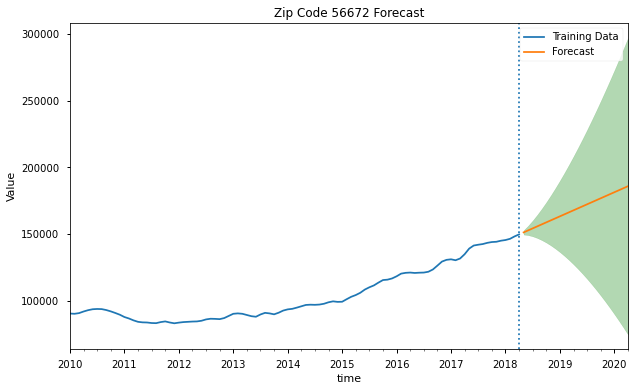

In [153]:
plot_time_series_forecast(ts, forecast_df)

Lower CI  Upper CI  Forecast
2018-05-01   -0.0104    0.0104    0.0000
2018-06-01   -0.0135    0.0333    0.0099
2018-07-01   -0.0193    0.0589    0.0198
2018-08-01   -0.0275    0.0869    0.0297
2018-09-01   -0.0378    0.1171    0.0396
2018-10-01   -0.0501    0.1491    0.0495
2018-11-01   -0.0642    0.1830    0.0594
2018-12-01   -0.0799    0.2185    0.0693
2019-01-01   -0.0971    0.2555    0.0792
2019-02-01   -0.1158    0.2940    0.0891
2019-03-01   -0.1359    0.3339    0.0990
2019-04-01   -0.1573    0.3752    0.1089
2019-05-01   -0.1801    0.4177    0.1188
2019-06-01   -0.2040    0.4614    0.1287
2019-07-01   -0.2291    0.5064    0.1386
2019-08-01   -0.2554    0.5524    0.1485
2019-09-01   -0.2828    0.5996    0.1584
2019-10-01   -0.3113    0.6479    0.1683
2019-11-01   -0.3408    0.6972    0.1782
2019-12-01   -0.3714    0.7476    0.1881
2020-01-01   -0.4029    0.7989    0.1980
2020-02-01   -0.4354    0.8513    0.2079
2020-03-01   -0.4689    0.9046    0.2178
2020-04-01   -0.5033    0.9588    0.2277

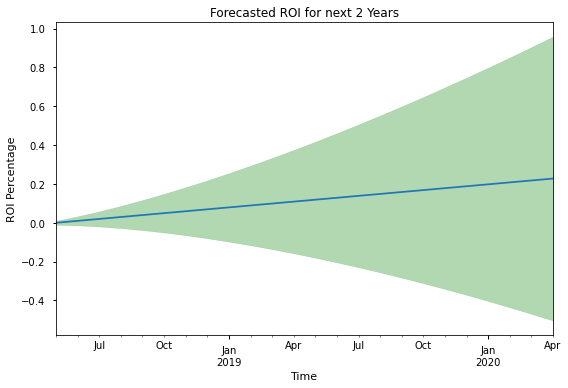

In [154]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56570 has a predicted ROI of 23.4% after three years. However, the confidence interval ranges from -24.8% to 71.6%

## Zipcode 56050

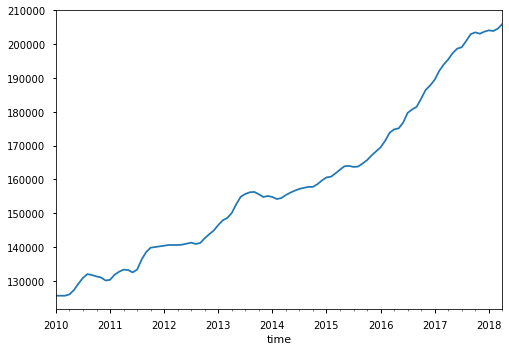

In [155]:
ts = all_time_series_df['56050']
ts.plot();

In [156]:
train, test = train_test_split(ts)

-24

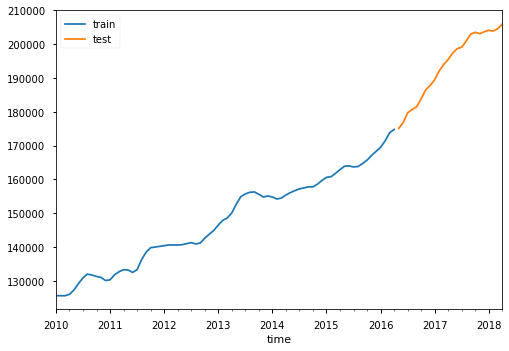

In [157]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results          0.4675           9  ...  False        False

[1 rows x 6 columns]

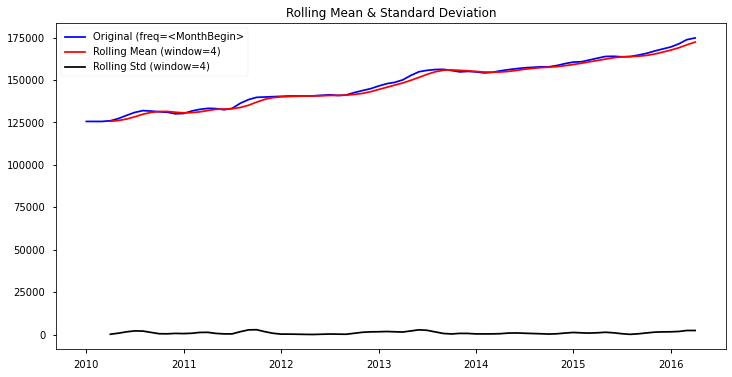

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results          0.4675           9  ...  False        False

[1 rows x 6 columns]

In [158]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.3584          12  ...  False        False

[1 rows x 6 columns]

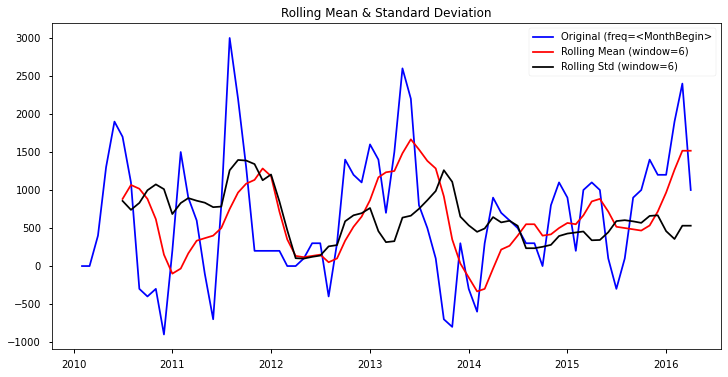

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.3584          12  ...  False        False

[1 rows x 6 columns]

In [159]:
stationarity_check(train.diff().dropna(), window=6)

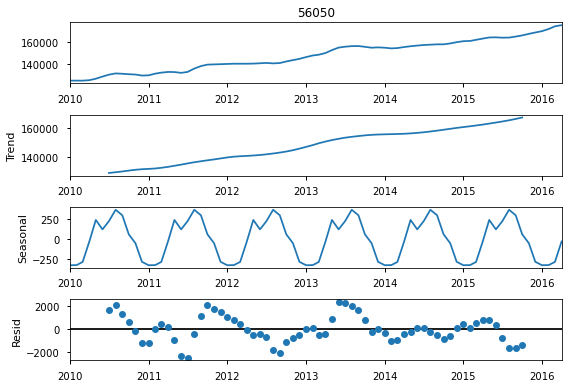

In [160]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

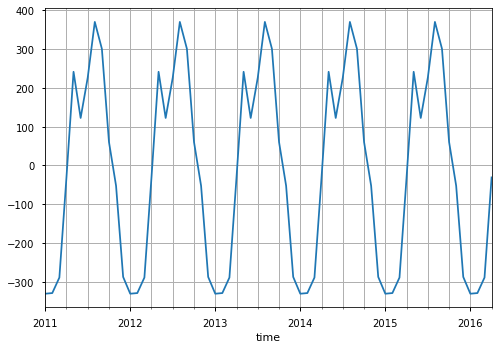

In [161]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1223.229, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1233.916, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1227.861, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1258.334, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1224.638, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1224.600, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1226.569, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1231.923, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1226.409, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1227.205, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 0.605 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -609.614
Date:                Thu, 01 Jul 2021   AIC                           1223.229
Time:                        09:51:11   BIC                           1227.864
Sample:                             0   HQIC                          1225.079
                                 - 76                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    656.0000    100.488      6.528      0.000     459.046     852.954
sigma2      6.723e+05   1.16e+05      5.785      0.000    4.45e+05       9e+05
===================================================================================
Ljung-Box (L1) (Q):                  32.10   Jarque-Bera (JB):                 2.82
Prob(Q):                              0.00   Prob(JB):                         0.24
Heteroskedasticity (H):               0.42   Skew:                             0.48
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

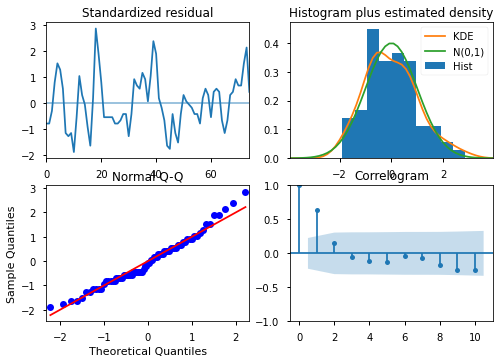

In [162]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1081.890, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1085.463, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1085.439, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1087.620, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1083.550, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1083.780, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1083.778, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=1083.381, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.712 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   76
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -539.945
Date:                            Thu, 01 Jul 2021   AIC                           1081.890
Time:                                    09:51:12   BIC                           1084.033
Sample:                                         0   HQIC                          1082.732
                                             - 76                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.62e+06   3.16e+05      5.130      0.000       1e+06    2.24e+06
===================================================================================
Ljung-Box (L1) (Q):                  28.51   Jarque-Bera (JB):                 2.82
Prob(Q):                              0.00   Prob(JB):                         0.24
Heteroskedasticity (H):               0.30   Skew:                            -0.51
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

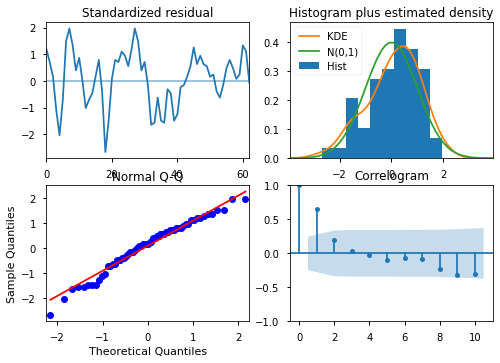

In [163]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=1, D=1,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              56050   No. Observations:                   76
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -539.945
Date:                            Thu, 01 Jul 2021   AIC                           1081.890
Time:                                    09:51:13   BIC                           1084.033
Sample:                                01-01-2010   HQIC                          1082.732
                                     - 04-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.62e+06   3.16e+05      5.130      0.000       1e+06    2.24e+06
===================================================================================
Ljung-Box (L1) (Q):                  28.51   Jarque-Bera (JB):                 2.82
Prob(Q):                              0.00   Prob(JB):                         0.24
Heteroskedasticity (H):               0.30   Skew:                            -0.51
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

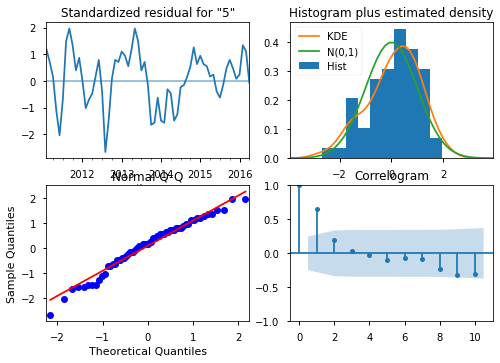

In [164]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [165]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI    Upper CI    Forecast
2016-05-01 173305.0920 178294.9080 175800.0000
2016-06-01 172371.6673 179428.3327 175900.0000
2016-07-01 171278.6927 179921.3073 175600.0000
2016-08-01 170710.1841 180689.8159 175700.0000
2016-09-01 171021.2162 182178.7838 176600.0000
2016-10-01 171488.7486 183711.2514 177600.0000
2016-11-01 172399.0940 185600.9060 179000.0000
2016-12-01 173143.3347 187256.6653 180200.0000
2017-01-01 173915.2761 188884.7239 181400.0000
2017-02-01 175410.4083 191189.5917 183300.0000
2017-03-01 177425.3264 193974.6736 185700.0000
2017-04-01 178057.3853 195342.6147 186700.0000
2017-05-01 177720.3682 197679.6318 187700.0000
2017-06-01 176642.4324 198957.5676 187800.0000
2017-07-01 175277.4971 199722.5029 187500.0000
2017-08-01 174398.1880 200801.8120 187600.0000
2017-09-01 174386.6693 202613.3307 188500.0000
2017-10-01 174530.5523 204469.4477 189500.0000
2017-11-01 175120.8166 206679.1834 190900.0000
2017-12-01 175550.6529 208649.3471 192100.0000
2018-01-01 176014.7707 210585.2293 193300.0000
2018-02-01 177208.9629 213191.0371 195200.0000
2018-03-01 178929.8185 216270.1815 197600.0000
2018-04-01 179274.5261 217925.4739 198600.0000

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

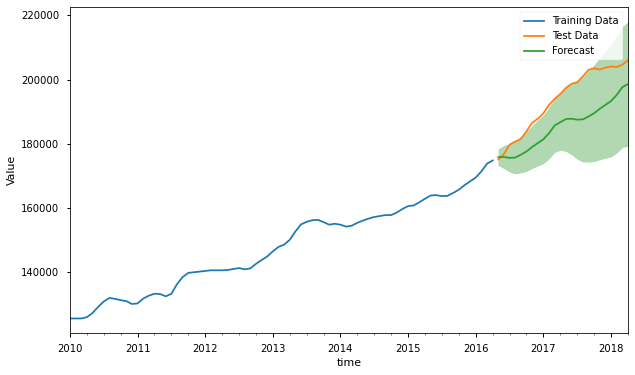

In [166]:
plot_train_test_forecast(train, test, forecast_df)

The forecast closely follows the test data and the test data falls within the confidence interval. We will train this model on the entire time series.

### Final model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              56050   No. Observations:                  100
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -750.008
Date:                            Thu, 01 Jul 2021   AIC                           1502.016
Time:                                    09:51:13   BIC                           1504.482
Sample:                                01-01-2010   HQIC                          1503.009
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.797e+06   2.92e+05      6.153      0.000    1.22e+06    2.37e+06
===================================================================================
Ljung-Box (L1) (Q):                  29.27   Jarque-Bera (JB):                 2.76
Prob(Q):                              0.00   Prob(JB):                         0.25
Heteroskedasticity (H):               0.92   Skew:                            -0.43
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

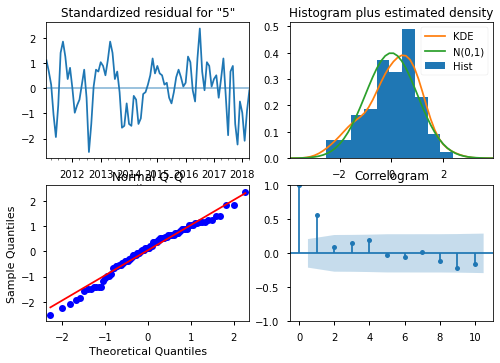

In [167]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [168]:
forecast_df = retrieve_forecast(sarimax_model_full, steps=36)
forecast_df

Lower CI    Upper CI    Forecast
2018-05-01 205272.5363 210527.4637 207900.0000
2018-06-01 205484.2053 212915.7947 209200.0000
2018-07-01 205049.0995 214150.9005 209600.0000
2018-08-01 206245.0727 216754.9273 211500.0000
2018-09-01 207624.8127 219375.1873 213500.0000
2018-10-01 207564.0547 220435.9453 214000.0000
2018-11-01 206648.3846 220551.6154 213600.0000
2018-12-01 206768.4105 221631.5895 214200.0000
2019-01-01 206717.6090 222482.3910 214600.0000
2019-02-01 206091.2304 222708.7696 214400.0000
2019-03-01 206385.6889 223814.3111 215100.0000
2019-04-01 207398.1989 225601.8011 216500.0000
2019-05-01 207890.1454 228909.8546 218400.0000
2019-06-01 207949.6253 231450.3747 219700.0000
2019-07-01 207228.1095 232971.8905 220100.0000
2019-08-01 208096.7692 235903.2308 222000.0000
2019-09-01 209136.8211 238863.1789 224000.0000
2019-10-01 208735.2181 240264.7819 224500.0000
2019-11-01 207482.4608 240717.5392 224100.0000
2019-12-01 207271.3778 242128.6222 224700.0000
2020-01-01 206896.3978 243303.6022 225100.0000
2020-02-01 205953.0901 243846.9099 224900.0000
2020-03-01 205937.8624 245262.1376 225600.0000
2020-04-01 206647.7540 247352.2460 227000.0000

Figure save as images/56050_forecast.png


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Zip Code 56050 Forecast'}, xlabel='time', ylabel='Value'>)

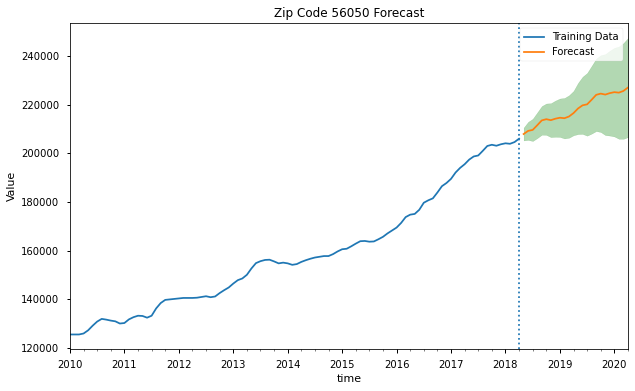

In [169]:
plot_time_series_forecast(ts, forecast_df)

Lower CI  Upper CI  Forecast
2018-05-01   -0.0126    0.0126    0.0000
2018-06-01   -0.0116    0.0241    0.0063
2018-07-01   -0.0137    0.0301    0.0082
2018-08-01   -0.0080    0.0426    0.0173
2018-09-01   -0.0013    0.0552    0.0269
2018-10-01   -0.0016    0.0603    0.0293
2018-11-01   -0.0060    0.0609    0.0274
2018-12-01   -0.0054    0.0660    0.0303
2019-01-01   -0.0057    0.0701    0.0322
2019-02-01   -0.0087    0.0712    0.0313
2019-03-01   -0.0073    0.0765    0.0346
2019-04-01   -0.0024    0.0851    0.0414
2019-05-01   -0.0000    0.1011    0.0505
2019-06-01    0.0002    0.1133    0.0568
2019-07-01   -0.0032    0.1206    0.0587
2019-08-01    0.0009    0.1347    0.0678
2019-09-01    0.0059    0.1489    0.0774
2019-10-01    0.0040    0.1557    0.0798
2019-11-01   -0.0020    0.1579    0.0779
2019-12-01   -0.0030    0.1646    0.0808
2020-01-01   -0.0048    0.1703    0.0827
2020-02-01   -0.0094    0.1729    0.0818
2020-03-01   -0.0094    0.1797    0.0851
2020-04-01   -0.0060    0.1898    0.0919

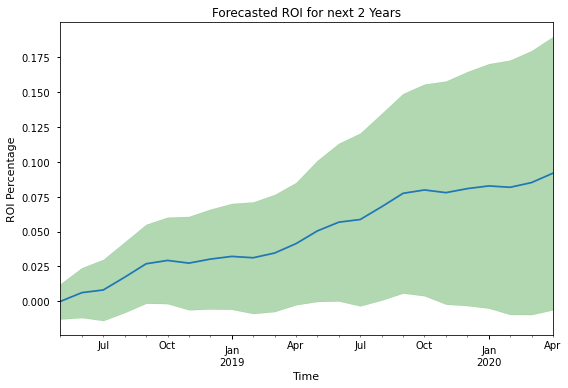

In [170]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56314 has a predicted ROI of 29.5% after three years. However, the confidence interval ranges from -1.7% to 60.6%

## Zipcode 56081

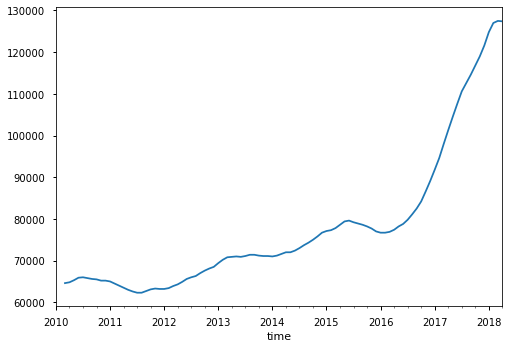

In [171]:
ts = all_time_series_df['56081']
ts.plot();

In [172]:
ts.isna().sum()

2

In [173]:
ts = ts.bfill()
ts.isna().sum()

0

In [174]:
train, test = train_test_split(ts, steps=48)

-48

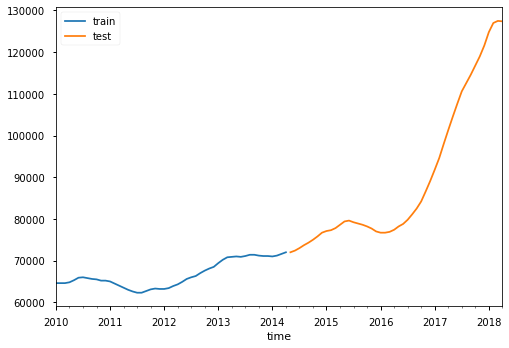

In [175]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -0.5781           1  ...  False        False

[1 rows x 6 columns]

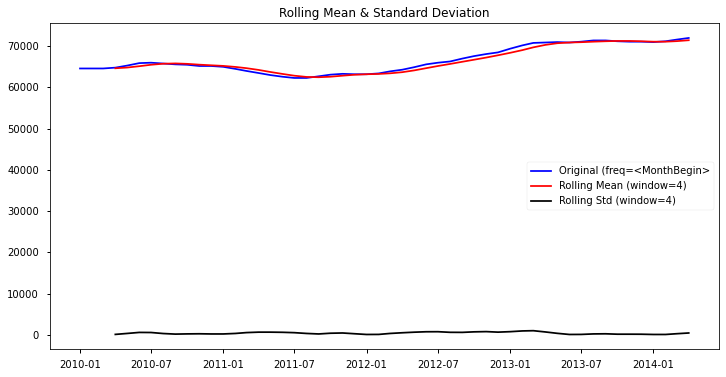

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -0.5781           1  ...  False        False

[1 rows x 6 columns]

In [176]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.7232           1  ...  False        False

[1 rows x 6 columns]

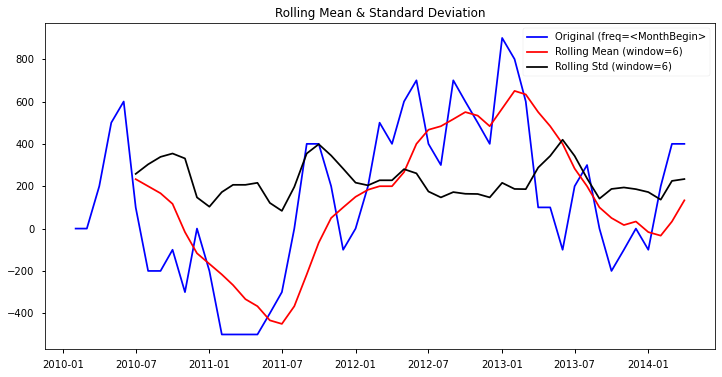

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -2.7232           1  ...  False        False

[1 rows x 6 columns]

In [177]:
stationarity_check(train.diff().dropna(), window=6)

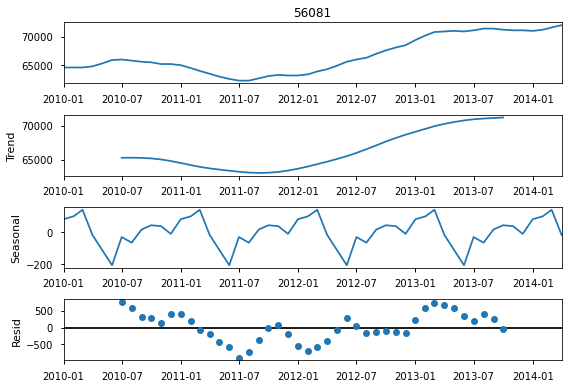

In [178]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

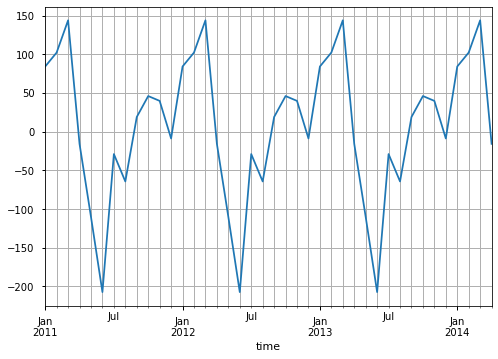

In [179]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=749.243, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=748.053, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=748.132, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=754.902, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=748.291, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=748.975, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=749.863, Time=0.20 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=747.848, Time=0.11 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=749.452, Time=0.21 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=751.791, Time=0.31 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=748.535, Time=0.05 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=749.205, Time=0.14 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=746.306, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=746.206, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   52
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -358.223
Date:                Thu, 01 Jul 2021   AIC                            730.446
Time:                        09:51:23   BIC                            743.969
Sample:                             0   HQIC                           735.613
                                 - 52                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.1535      1.620      3.182      0.001       1.979       8.328
ar.L1          1.9732      0.057     34.821      0.000       1.862       2.084
ar.L2         -1.0171      0.099    -10.287      0.000      -1.211      -0.823
ar.L3          0.0143      0.044      0.327      0.743      -0.071       0.100
ma.L1         -1.9308      0.054    -35.623      0.000      -2.037      -1.825
ma.L2          0.9567      0.054     17.779      0.000       0.851       1.062
sigma2      5.994e+04   3.34e-05    1.8e+09      0.000    5.99e+04    5.99e+04
===================================================================================
Ljung-Box (L1) (Q):                  17.06   Jarque-Bera (JB):                 1.74
Prob(Q):                              0.00   Prob(JB):                         0.42
Heteroskedasticity (H):               0.90   Skew:                             0.26
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+25. Standard errors may be unstable.
"""

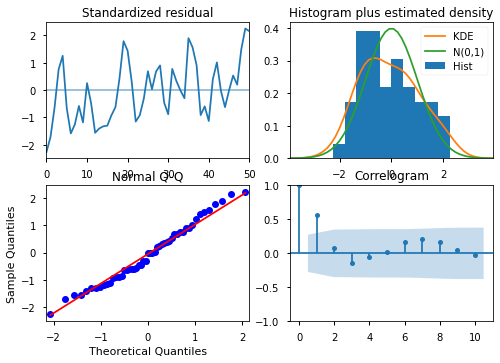

In [180]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=614.759, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=612.408, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=613.525, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=611.516, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=612.227, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=613.844, Time=0.30 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=610.282, Time=0.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=611.358, Time=0.12 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=611.198, Time=0.11 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=612.607, Time=0.22 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=609.409, Time=0.07 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=610.582, Time=0.13 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=610.430, Time=0.15 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=611.836, Time=0.24 sec
 ARIMA(4,1,0)(0,1,0)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   52
Model:             SARIMAX(5, 1, 2)x(0, 1, [], 12)   Log Likelihood                -283.926
Date:                             Thu, 01 Jul 2021   AIC                            583.852
Time:                                     09:51:35   BIC                            597.161
Sample:                                          0   HQIC                           588.627
                                              - 52                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9124      0.085     22.388      0.000       1.745       2.080
ar.L2         -1.0190      0.165     -6.190      0.000      -1.342      -0.696
ar.L3          0.0898      0.178      0.505      0.614      -0.259       0.439
ar.L4          0.0584      0.130      0.450      0.653      -0.196       0.313
ar.L5         -0.0777      0.062     -1.261      0.207      -0.199       0.043
ma.L1         -1.8550      0.057    -32.360      0.000      -1.967      -1.743
ma.L2          0.8759      0.058     15.228      0.000       0.763       0.989
sigma2      9.235e+04   2.44e+04      3.784      0.000    4.45e+04     1.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.69   Jarque-Bera (JB):                 1.80
Prob(Q):                              0.00   Prob(JB):                         0.41
Heteroskedasticity (H):               0.87   Skew:                             0.16
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.49e+14. Standard errors may be unstable.
"""

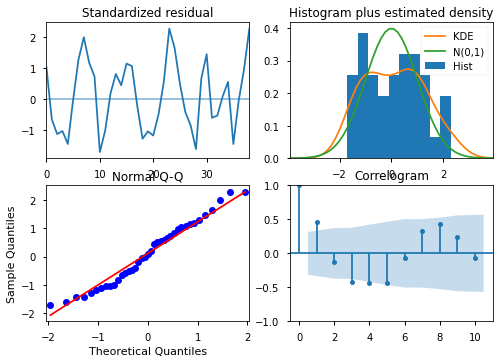

In [181]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=1, D=1,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               56081   No. Observations:                   52
Model:             SARIMAX(5, 1, 2)x(0, 1, [], 12)   Log Likelihood                -283.926
Date:                             Thu, 01 Jul 2021   AIC                            583.852
Time:                                     09:51:35   BIC                            597.161
Sample:                                 01-01-2010   HQIC                           588.627
                                      - 04-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9124      0.085     22.388      0.000       1.745       2.080
ar.L2         -1.0190      0.165     -6.190      0.000      -1.342      -0.696
ar.L3          0.0898      0.178      0.505      0.614      -0.259       0.439
ar.L4          0.0584      0.130      0.450      0.653      -0.196       0.313
ar.L5         -0.0777      0.062     -1.261      0.207      -0.199       0.043
ma.L1         -1.8550      0.057    -32.360      0.000      -1.967      -1.743
ma.L2          0.8759      0.058     15.228      0.000       0.763       0.989
sigma2      9.235e+04   2.44e+04      3.784      0.000    4.45e+04     1.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.69   Jarque-Bera (JB):                 1.80
Prob(Q):                              0.00   Prob(JB):                         0.41
Heteroskedasticity (H):               0.87   Skew:                             0.16
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.49e+14. Standard errors may be unstable.
"""

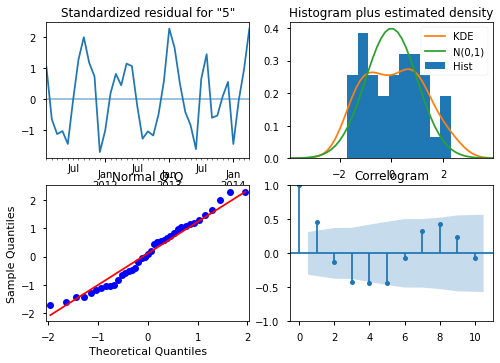

In [182]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [183]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI   Upper CI   Forecast
2014-05-01 71166.6606 72358.6046 71762.6326
2014-06-01 70477.8761 72213.4306 71345.6534
2014-07-01 70283.6586 72406.6437 71345.1511
2014-08-01 70371.9405 72803.0397 71587.4901
2014-09-01 70248.3639 72971.6769 71610.0204
2014-10-01 70002.1294 73000.9695 71501.5494
2014-11-01 69935.8988 73186.8388 71561.3688
2014-12-01 70050.0236 73525.9225 71787.9731
2015-01-01 70135.4051 73809.5722 71972.4886
2015-02-01 70580.3085 74426.9558 72503.6321
2015-03-01 71272.4294 75266.6928 73269.5611
2015-04-01 71999.1758 76117.4169 74058.2963
2015-05-01 71904.4080 76536.0195 74220.2137
2015-06-01 71657.2116 76744.3942 74200.8029
2015-07-01 71855.0933 77313.4955 74584.2944
2015-08-01 72303.5555 78068.4296 75185.9925
2015-09-01 72511.3378 78555.2513 75533.2946
2015-10-01 72557.9134 78854.9143 75706.4138
2015-11-01 72736.6040 79258.6289 75997.6164
2015-12-01 73040.6532 79759.5466 76400.0999
2016-01-01 73256.3676 80146.6842 76701.5259
2016-02-01 73769.4006 80808.6452 77289.0229
2016-03-01 74466.8101 81635.2374 78051.0237
2016-04-01 75137.3671 82417.8706 78777.6188
2016-05-01 74991.0146 82654.8424 78822.9285
2016-06-01 74623.2158 82652.1742 78637.6950
2016-07-01 74637.4110 82987.9964 78812.7037
2016-08-01 74851.9813 83489.7750 79170.8782
2016-09-01 74789.2764 83706.7959 79248.0361
2016-10-01 74538.2730 83728.3976 79133.3353
2016-11-01 74401.9351 83854.5158 79128.2255
2016-12-01 74383.4892 84086.5994 79235.0443
2017-01-01 74279.1477 84221.4087 79250.2782
2017-02-01 74483.9192 84654.7037 79569.3114
2017-03-01 74893.4097 85282.6595 80088.0346
2017-04-01 75303.9197 85902.0822 80603.0010
2017-05-01 74929.0056 86018.2694 80473.6375
2017-06-01 74368.6504 85940.7809 80154.7156
2017-07-01 74230.3813 86249.0050 80239.6931
2017-08-01 74335.8783 86769.6684 80552.7733
2017-09-01 74208.8327 87050.5030 80629.6678
2017-10-01 73937.9453 87178.2355 80558.0904
2017-11-01 73824.5327 87449.0582 80636.7955
2017-12-01 73868.8798 87859.7110 80864.2954
2018-01-01 73863.0907 88201.4535 81032.2721
2018-02-01 74197.0803 88863.9229 81530.5016
2018-03-01 74760.5759 89736.7375 82248.6567
2018-04-01 75343.4269 90609.9102 82976.6686

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

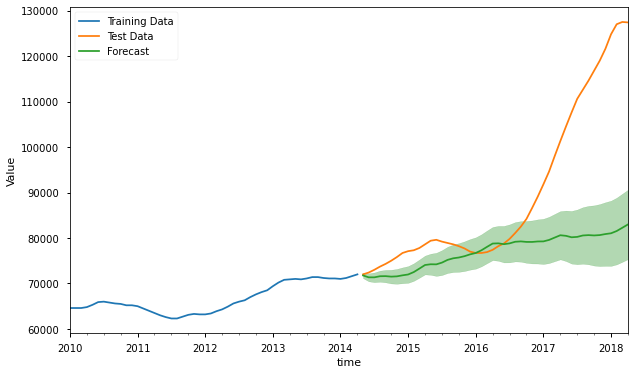

In [184]:
plot_train_test_forecast(train, test, forecast_df)

The forecast does not follow the test data and the test data is outside of the confidence interval. I believe this is due to the drastic difference between the training set and test set. However, it is the best fit model and we will train it on the entire time series.

### Final model

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               56081   No. Observations:                  100
Model:             SARIMAX(5, 1, 2)x(0, 1, [], 12)   Log Likelihood                -741.229
Date:                             Thu, 01 Jul 2021   AIC                           1498.459
Time:                                     09:51:36   BIC                           1518.186
Sample:                                 01-01-2010   HQIC                          1506.402
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5714      0.018     88.737      0.000       1.537       1.606
ar.L2         -1.0311      0.026    -40.253      0.000      -1.081      -0.981
ar.L3          0.1737      0.026      6.689      0.000       0.123       0.225
ar.L4         -0.0043      0.029     -0.150      0.881      -0.060       0.052
ar.L5          0.0480      0.022      2.149      0.032       0.004       0.092
ma.L1         -1.4671      0.049    -29.647      0.000      -1.564      -1.370
ma.L2          1.0000      0.060     16.698      0.000       0.883       1.117
sigma2      3.163e+05   3.03e-07   1.04e+12      0.000    3.16e+05    3.16e+05
===================================================================================
Ljung-Box (L1) (Q):                  43.54   Jarque-Bera (JB):                19.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                            -0.22
Prob(H) (two-sided):                  0.16   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.08e+26. Standard errors may be unstable.
"""

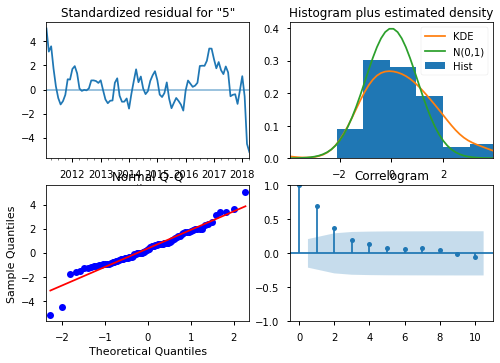

In [185]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [186]:
forecast_df = retrieve_forecast(sarimax_model_full, steps=36)
forecast_df

Lower CI    Upper CI    Forecast
2018-05-01 128806.3281 131032.8945 129919.6113
2018-06-01 130412.2654 133752.9262 132082.5958
2018-07-01 131527.7428 135881.8164 133704.7796
2018-08-01 131506.3729 137019.7529 134263.0629
2018-09-01 131679.5656 138510.9019 135095.2338
2018-10-01 132558.8497 140798.5245 136678.6871
2018-11-01 134018.2795 143630.7637 138824.5216
2018-12-01 136289.2390 147135.5095 141712.3743
2019-01-01 139296.2374 151202.4154 145249.3264
2019-02-01 141210.7792 154027.6879 147619.2336
2019-03-01 141243.8923 154875.0125 148059.4524
2019-04-01 140544.8589 154945.1620 147745.0104
2019-05-01 142034.6163 158027.6929 150031.1546
2019-06-01 143256.2574 160850.5904 152053.4239
2019-07-01 144060.7588 163271.9848 153666.3718
2019-08-01 143844.6061 164780.8627 154312.7344
2019-09-01 143876.5832 166641.6428 155259.1130
2019-10-01 144592.8909 169245.1440 156919.0174
2019-11-01 145818.5608 172333.0749 159075.8178
2019-12-01 147783.3356 176058.8438 161921.0897
2020-01-01 150446.3279 180347.3442 165396.8361
2020-02-01 152021.3576 183421.6880 167721.5228
2020-03-01 151746.1274 184553.9020 168150.0147
2020-04-01 150773.5117 184934.1866 167853.8491
2020-05-01 152096.1281 188246.2139 170171.1710
2020-06-01 153143.9646 191293.6553 172218.8100
2020-07-01 153759.0346 193922.0312 173840.5329
2020-08-01 153347.5511 195611.0498 174479.3005
2020-09-01 153183.5317 197636.1590 175409.8454
2020-10-01 153706.8382 200404.3827 177055.6104
2020-11-01 154741.0043 203671.7518 179206.3781
2020-12-01 156511.9343 207596.9704 182054.4523
2021-01-01 158975.6016 212100.5395 185538.0706
2021-02-01 160344.3740 215396.6084 187870.4912
2021-03-01 159856.3924 216749.3155 188302.8540
2021-04-01 158666.7030 217345.0226 188005.8628
2021-05-01 159818.7986 220819.8809 190319.3398
2021-06-01 160695.0991 224030.5108 192362.8050
2021-07-01 161140.2923 226823.9968 193982.1445
2021-08-01 160567.0750 228674.9084 194620.9917
2021-09-01 160248.5497 230858.1928 195553.3712
2021-10-01 160620.4842 233782.2291 197201.3567
2021-11-01 161500.3798 237206.7114 199353.5456
2021-12-01 163109.6901 241293.8458 202201.7679
2022-01-01 165403.5629 245965.5069 205684.5349
2022-02-01 166596.4455 249435.1356 208015.7905
2022-03-01 165929.5704 250965.0825 208447.3265
2022-04-01 164560.5211 251739.7925 208150.1568

Figure save as images/56081_forecast.png


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Zip Code 56081 Forecast'}, xlabel='time', ylabel='Value'>)

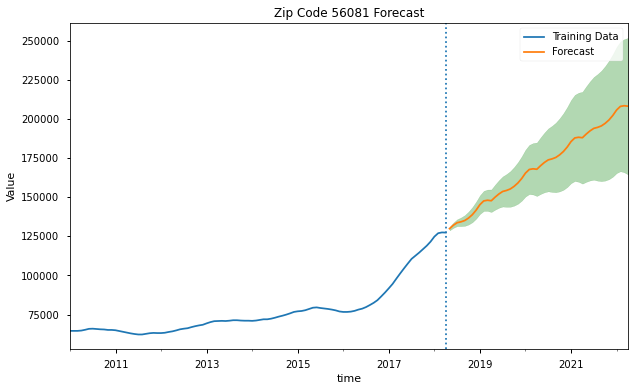

In [187]:
plot_time_series_forecast(ts, forecast_df)

Lower CI  Upper CI  Forecast
2018-05-01   -0.0086    0.0086    0.0000
2018-06-01    0.0038    0.0295    0.0166
2018-07-01    0.0124    0.0459    0.0291
2018-08-01    0.0122    0.0547    0.0334
2018-09-01    0.0135    0.0661    0.0398
2018-10-01    0.0203    0.0837    0.0520
2018-11-01    0.0315    0.1055    0.0685
2018-12-01    0.0490    0.1325    0.0908
2019-01-01    0.0722    0.1638    0.1180
2019-02-01    0.0869    0.1856    0.1362
2019-03-01    0.0872    0.1921    0.1396
2019-04-01    0.0818    0.1926    0.1372
2019-05-01    0.0933    0.2163    0.1548
2019-06-01    0.1027    0.2381    0.1704
2019-07-01    0.1088    0.2567    0.1828
2019-08-01    0.1072    0.2683    0.1878
2019-09-01    0.1074    0.2827    0.1950
2019-10-01    0.1129    0.3027    0.2078
2019-11-01    0.1224    0.3265    0.2244
2019-12-01    0.1375    0.3551    0.2463
2020-01-01    0.1580    0.3881    0.2731
2020-02-01    0.1701    0.4118    0.2910
2020-03-01    0.1680    0.4205    0.2943
2020-04-01    0.1605    0.4235    0.2920
2020-05-01    0.1707    0.4489    0.3098
2020-06-01    0.1788    0.4724    0.3256
2020-07-01    0.1835    0.4926    0.3381
2020-08-01    0.1803    0.5056    0.3430
2020-09-01    0.1791    0.5212    0.3501
2020-10-01    0.1831    0.5425    0.3628
2020-11-01    0.1911    0.5677    0.3794
2020-12-01    0.2047    0.5979    0.4013
2021-01-01    0.2236    0.6326    0.4281
2021-02-01    0.2342    0.6579    0.4461
2021-03-01    0.2304    0.6683    0.4494
2021-04-01    0.2213    0.6729    0.4471
2021-05-01    0.2301    0.6997    0.4649
2021-06-01    0.2369    0.7244    0.4806
2021-07-01    0.2403    0.7459    0.4931
2021-08-01    0.2359    0.7601    0.4980
2021-09-01    0.2334    0.7769    0.5052
2021-10-01    0.2363    0.7994    0.5179
2021-11-01    0.2431    0.8258    0.5344
2021-12-01    0.2555    0.8573    0.5564
2022-01-01    0.2731    0.8932    0.5832
2022-02-01    0.2823    0.9199    0.6011
2022-03-01    0.2772    0.9317    0.6044
2022-04-01    0.2666    0.9377    0.6021

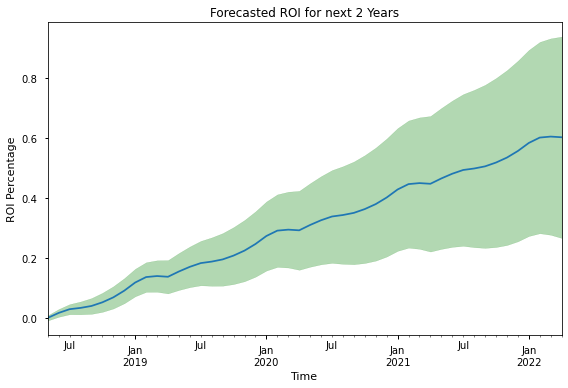

In [188]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56578 has a predicted ROI of 21.7% after three years. However, the confidence interval ranges from -9.3% to 52.7%

## Zipcode 56062

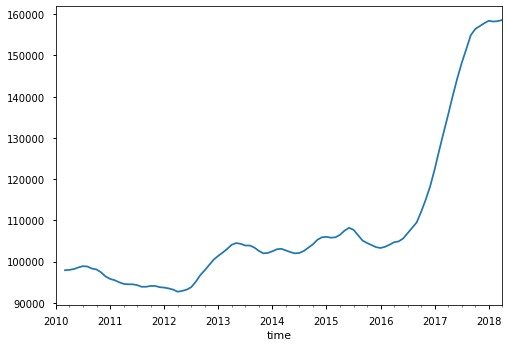

In [189]:
ts = all_time_series_df['56062']
ts.plot();

In [190]:
ts.isna().sum()

2

In [191]:
ts = ts.bfill()
ts.isna().sum()

0

In [192]:
train, test = train_test_split(ts, steps=48)

-48

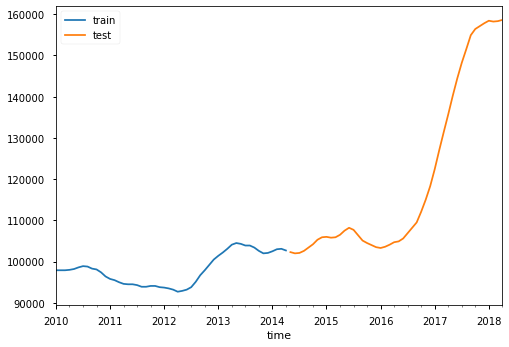

In [193]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.7809           6  ...  False        False

[1 rows x 6 columns]

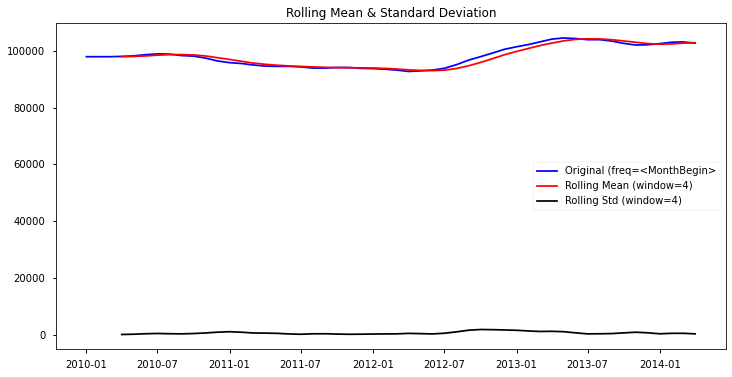

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.7809           6  ...  False        False

[1 rows x 6 columns]

In [194]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.6711           5  ...  False        False

[1 rows x 6 columns]

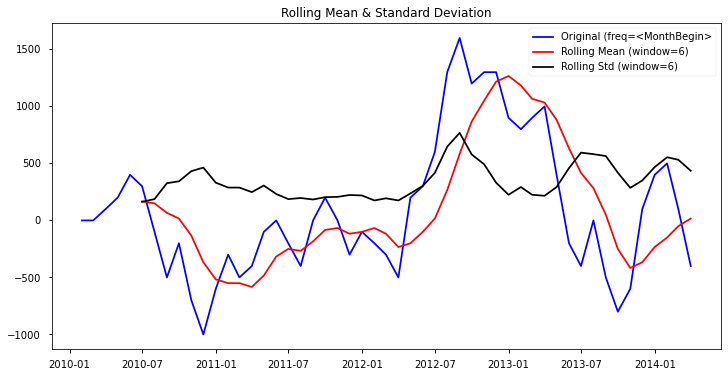

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.6711           5  ...  False        False

[1 rows x 6 columns]

In [195]:
stationarity_check(train.diff().dropna(), window=6)

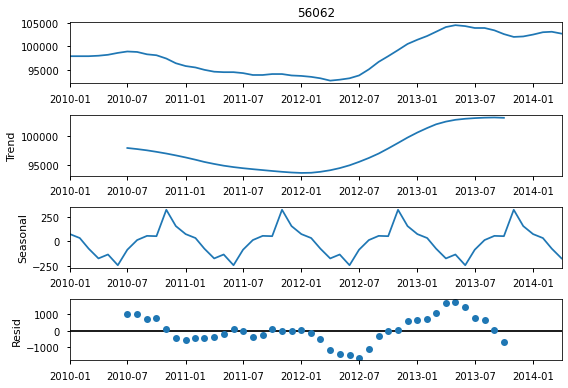

In [196]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

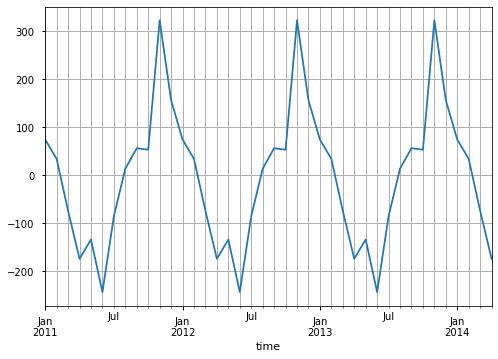

In [197]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=800.907, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=802.524, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=802.039, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=800.154, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=800.787, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=800.840, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=802.672, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=802.542, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=804.376, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=803.130, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.515 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   52
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -399.077
Date:                Thu, 01 Jul 2021   AIC                            800.154
Time:                        09:51:40   BIC                            802.086
Sample:                             0   HQIC                           800.893
                                 - 52                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.665e+05   6.79e+04      5.395      0.000    2.33e+05       5e+05
===================================================================================
Ljung-Box (L1) (Q):                  38.21   Jarque-Bera (JB):                 4.21
Prob(Q):                              0.00   Prob(JB):                         0.12
Heteroskedasticity (H):               2.42   Skew:                             0.70
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

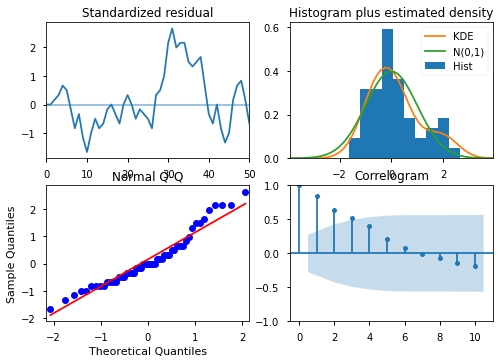

In [198]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=800.907, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=802.524, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=802.039, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=800.154, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=800.787, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=800.840, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=802.672, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=802.542, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=804.376, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=803.130, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.523 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   52
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -399.077
Date:                Thu, 01 Jul 2021   AIC                            800.154
Time:                        09:51:41   BIC                            802.086
Sample:                             0   HQIC                           800.893
                                 - 52                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.665e+05   6.79e+04      5.395      0.000    2.33e+05       5e+05
===================================================================================
Ljung-Box (L1) (Q):                  38.21   Jarque-Bera (JB):                 4.21
Prob(Q):                              0.00   Prob(JB):                         0.12
Heteroskedasticity (H):               2.42   Skew:                             0.70
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

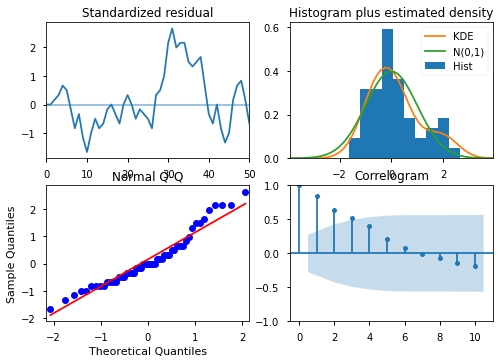

In [199]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=4,
                       start_P=0, max_P=4,
                       start_q=0, max_q=4,
                       start_Q=0, max_Q=4,
                       d=1, D=0,
                       m=12,
                       trace=True)
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  56062   No. Observations:                   52
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -399.077
Date:                Thu, 01 Jul 2021   AIC                            800.154
Time:                        09:51:41   BIC                            802.086
Sample:                    01-01-2010   HQIC                           800.893
                         - 04-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.665e+05   6.79e+04      5.395      0.000    2.33e+05       5e+05
===================================================================================
Ljung-Box (L1) (Q):                  38.21   Jarque-Bera (JB):                 4.21
Prob(Q):                              0.00   Prob(JB):                         0.12
Heteroskedasticity (H):               2.42   Skew:                             0.70
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

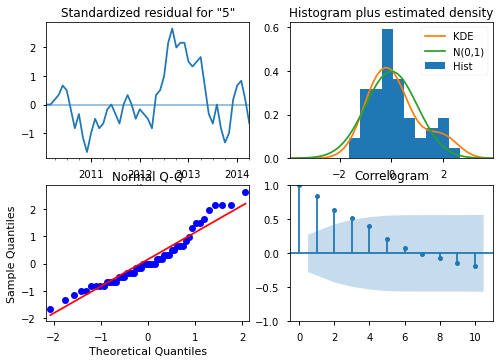

In [200]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [201]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI    Upper CI    Forecast
2014-05-01 101513.4093 103886.5907 102700.0000
2014-06-01 101021.9073 104378.0927 102700.0000
2014-07-01 100644.7646 104755.2354 102700.0000
2014-08-01 100326.8185 105073.1815 102700.0000
2014-09-01 100046.7025 105353.2975 102700.0000
2014-10-01  99793.4582 105606.5418 102700.0000
2014-11-01  99560.5760 105839.4240 102700.0000
2014-12-01  99343.8146 106056.1854 102700.0000
2015-01-01  99140.2278 106259.7722 102700.0000
2015-02-01  98947.6706 106452.3294 102700.0000
2015-03-01  98764.5237 106635.4763 102700.0000
2015-04-01  98589.5291 106810.4709 102700.0000
2015-05-01  98421.6863 106978.3137 102700.0000
2015-06-01  98260.1840 107139.8160 102700.0000
2015-07-01  98104.3538 107295.6462 102700.0000
2015-08-01  97953.6371 107446.3629 102700.0000
2015-09-01  97807.5611 107592.4389 102700.0000
2015-10-01  97665.7219 107734.2781 102700.0000
2015-11-01  97527.7709 107872.2291 102700.0000
2015-12-01  97393.4049 108006.5951 102700.0000
2016-01-01  97262.3581 108137.6419 102700.0000
2016-02-01  97134.3961 108265.6039 102700.0000
2016-03-01  97009.3107 108390.6893 102700.0000
2016-04-01  96886.9163 108513.0837 102700.0000
2016-05-01  96767.0463 108632.9537 102700.0000
2016-06-01  96649.5507 108750.4493 102700.0000
2016-07-01  96534.2937 108865.7063 102700.0000
2016-08-01  96421.1520 108978.8480 102700.0000
2016-09-01  96310.0133 109089.9867 102700.0000
2016-10-01  96200.7749 109199.2251 102700.0000
2016-11-01  96093.3424 109306.6576 102700.0000
2016-12-01  95987.6292 109412.3708 102700.0000
2017-01-01  95883.5552 109516.4448 102700.0000
2017-02-01  95781.0465 109618.9535 102700.0000
2017-03-01  95680.0345 109719.9655 102700.0000
2017-04-01  95580.4556 109819.5444 102700.0000
2017-05-01  95482.2503 109917.7497 102700.0000
2017-06-01  95385.3634 110014.6366 102700.0000
2017-07-01  95289.7432 110110.2568 102700.0000
2017-08-01  95195.3412 110204.6588 102700.0000
2017-09-01  95102.1121 110297.8879 102700.0000
2017-10-01  95010.0131 110389.9869 102700.0000
2017-11-01  94919.0042 110480.9958 102700.0000
2017-12-01  94829.0475 110570.9525 102700.0000
2018-01-01  94740.1074 110659.8926 102700.0000
2018-02-01  94652.1501 110747.8499 102700.0000
2018-03-01  94565.1438 110834.8562 102700.0000
2018-04-01  94479.0582 110920.9418 102700.0000

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

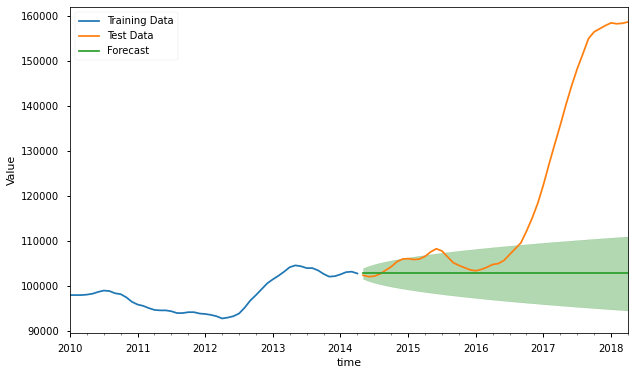

In [202]:
plot_train_test_forecast(train, test, forecast_df)

The forecast does not follow the test data and the test data is outside of the confidence interval. I believe this is due to the drastic difference between the training set and test set. However, it is the best fit model and we will train it on the entire time series.

### Final model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  56062   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -862.777
Date:                Thu, 01 Jul 2021   AIC                           1727.554
Time:                        09:51:42   BIC                           1730.149
Sample:                    01-01-2010   HQIC                          1728.604
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.152e+06   1.87e+05     11.485      0.000    1.78e+06    2.52e+06
===================================================================================
Ljung-Box (L1) (Q):                  90.93   Jarque-Bera (JB):                56.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              19.37   Skew:                             1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

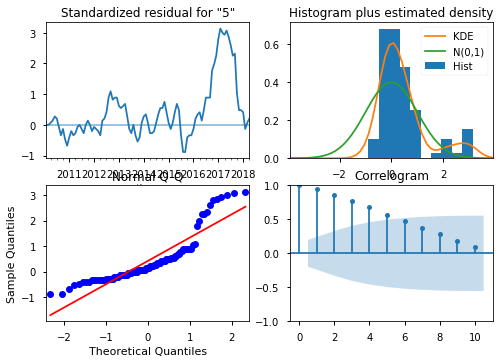

In [203]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [204]:
forecast_df = retrieve_forecast(sarimax_model_full, steps=36)
forecast_df

Lower CI    Upper CI    Forecast
2018-05-01 155724.8591 161475.1409 158600.0000
2018-06-01 154533.9367 162666.0633 158600.0000
2018-07-01 153620.1099 163579.8901 158600.0000
2018-08-01 152849.7182 164350.2818 158600.0000
2018-09-01 152170.9895 165029.0105 158600.0000
2018-10-01 151557.3718 165642.6282 158600.0000
2018-11-01 150993.0922 166206.9078 158600.0000
2018-12-01 150467.8735 166732.1265 158600.0000
2019-01-01 149974.5773 167225.4227 158600.0000
2019-02-01 149508.0061 167691.9939 158600.0000
2019-03-01 149064.2364 168135.7636 158600.0000
2019-04-01 148640.2197 168559.7803 158600.0000
2019-05-01 148233.5320 168966.4680 158600.0000
2019-06-01 147842.2078 169357.7922 158600.0000
2019-07-01 147464.6271 169735.3729 158600.0000
2019-08-01 147099.4364 170100.5636 158600.0000
2019-09-01 146745.4904 170454.5096 158600.0000
2019-10-01 146401.8102 170798.1898 158600.0000
2019-11-01 146067.5513 171132.4487 158600.0000
2019-12-01 145741.9790 171458.0210 158600.0000
2020-01-01 145424.4492 171775.5508 158600.0000
2020-02-01 145114.3938 172085.6062 158600.0000
2020-03-01 144811.3086 172388.6914 158600.0000
2020-04-01 144514.7437 172685.2563 158600.0000
2020-05-01 144224.2955 172975.7045 158600.0000
2020-06-01 143939.6004 173260.3996 158600.0000
2020-07-01 143660.3296 173539.6704 158600.0000
2020-08-01 143386.1844 173813.8156 158600.0000
2020-09-01 143116.8924 174083.1076 158600.0000
2020-10-01 142852.2047 174347.7953 158600.0000
2020-11-01 142591.8929 174608.1071 158600.0000
2020-12-01 142335.7469 174864.2531 158600.0000
2021-01-01 142083.5729 175116.4271 158600.0000
2021-02-01 141835.1917 175364.8083 158600.0000
2021-03-01 141590.4370 175609.5630 158600.0000
2021-04-01 141349.1546 175850.8454 158600.0000
2021-05-01 141111.2006 176088.7994 158600.0000
2021-06-01 140876.4411 176323.5589 158600.0000
2021-07-01 140644.7508 176555.2492 158600.0000
2021-08-01 140416.0123 176783.9877 158600.0000
2021-09-01 140190.1156 177009.8844 158600.0000
2021-10-01 139966.9573 177233.0427 158600.0000
2021-11-01 139746.4403 177453.5597 158600.0000
2021-12-01 139528.4728 177671.5272 158600.0000
2022-01-01 139312.9685 177887.0315 158600.0000
2022-02-01 139099.8456 178100.1544 158600.0000
2022-03-01 138889.0270 178310.9730 158600.0000
2022-04-01 138680.4395 178519.5605 158600.0000

Figure save as images/56062_forecast.png


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Zip Code 56062 Forecast'}, xlabel='time', ylabel='Value'>)

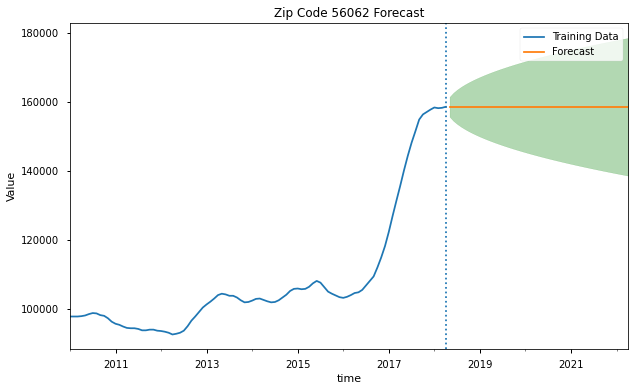

In [205]:
plot_time_series_forecast(ts, forecast_df)

Lower CI  Upper CI  Forecast
2018-05-01   -0.0181    0.0181    0.0000
2018-06-01   -0.0256    0.0256    0.0000
2018-07-01   -0.0314    0.0314    0.0000
2018-08-01   -0.0363    0.0363    0.0000
2018-09-01   -0.0405    0.0405    0.0000
2018-10-01   -0.0444    0.0444    0.0000
2018-11-01   -0.0480    0.0480    0.0000
2018-12-01   -0.0513    0.0513    0.0000
2019-01-01   -0.0544    0.0544    0.0000
2019-02-01   -0.0573    0.0573    0.0000
2019-03-01   -0.0601    0.0601    0.0000
2019-04-01   -0.0628    0.0628    0.0000
2019-05-01   -0.0654    0.0654    0.0000
2019-06-01   -0.0678    0.0678    0.0000
2019-07-01   -0.0702    0.0702    0.0000
2019-08-01   -0.0725    0.0725    0.0000
2019-09-01   -0.0747    0.0747    0.0000
2019-10-01   -0.0769    0.0769    0.0000
2019-11-01   -0.0790    0.0790    0.0000
2019-12-01   -0.0811    0.0811    0.0000
2020-01-01   -0.0831    0.0831    0.0000
2020-02-01   -0.0850    0.0850    0.0000
2020-03-01   -0.0869    0.0869    0.0000
2020-04-01   -0.0888    0.0888    0.0000
2020-05-01   -0.0906    0.0906    0.0000
2020-06-01   -0.0924    0.0924    0.0000
2020-07-01   -0.0942    0.0942    0.0000
2020-08-01   -0.0959    0.0959    0.0000
2020-09-01   -0.0976    0.0976    0.0000
2020-10-01   -0.0993    0.0993    0.0000
2020-11-01   -0.1009    0.1009    0.0000
2020-12-01   -0.1025    0.1025    0.0000
2021-01-01   -0.1041    0.1041    0.0000
2021-02-01   -0.1057    0.1057    0.0000
2021-03-01   -0.1072    0.1072    0.0000
2021-04-01   -0.1088    0.1088    0.0000
2021-05-01   -0.1103    0.1103    0.0000
2021-06-01   -0.1118    0.1118    0.0000
2021-07-01   -0.1132    0.1132    0.0000
2021-08-01   -0.1147    0.1147    0.0000
2021-09-01   -0.1161    0.1161    0.0000
2021-10-01   -0.1175    0.1175    0.0000
2021-11-01   -0.1189    0.1189    0.0000
2021-12-01   -0.1202    0.1202    0.0000
2022-01-01   -0.1216    0.1216    0.0000
2022-02-01   -0.1230    0.1230    0.0000
2022-03-01   -0.1243    0.1243    0.0000
2022-04-01   -0.1256    0.1256    0.0000

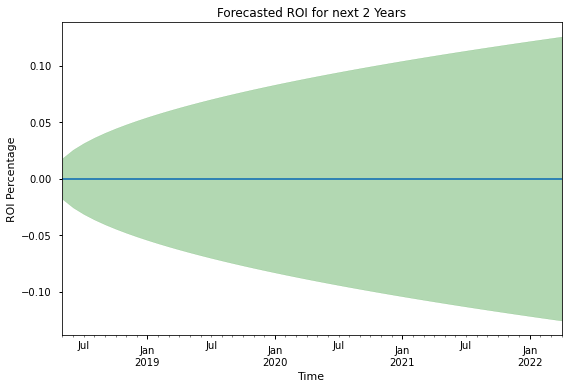

In [206]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56578 has a predicted ROI of 21.7% after three years. However, the confidence interval ranges from -9.3% to 52.7%

## Zipcode 56120

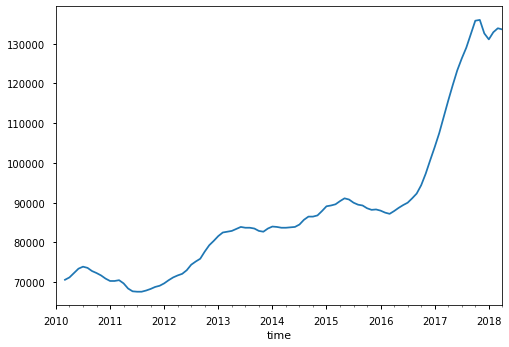

In [207]:
ts = all_time_series_df['56120']
ts.plot();

In [208]:
ts.isna().sum()

2

In [209]:
ts = ts.bfill()
ts.isna().sum()

0

In [210]:
train, test = train_test_split(ts)

-24

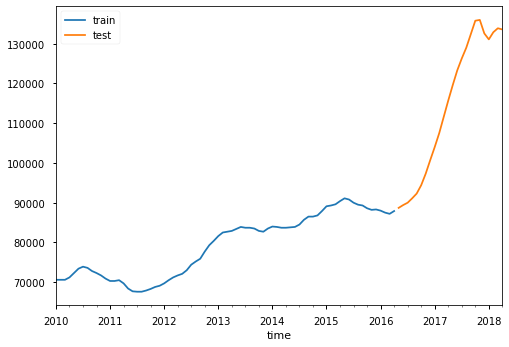

In [211]:
plot_train_test_split(train, test);

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.0087           3  ...  False        False

[1 rows x 6 columns]

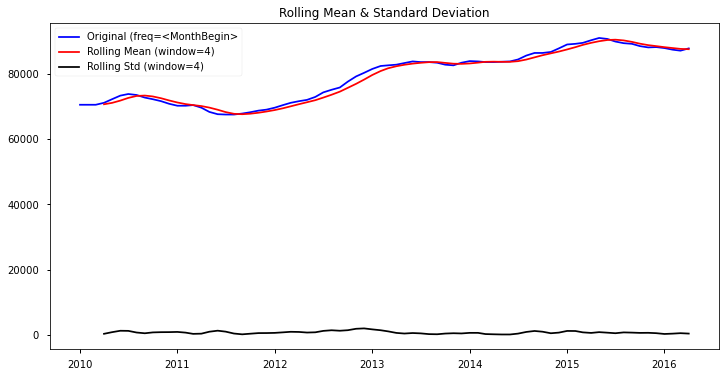

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -1.0087           3  ...  False        False

[1 rows x 6 columns]

In [212]:
stationarity_check(train)

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -3.0886           8  ...   True         True

[1 rows x 6 columns]

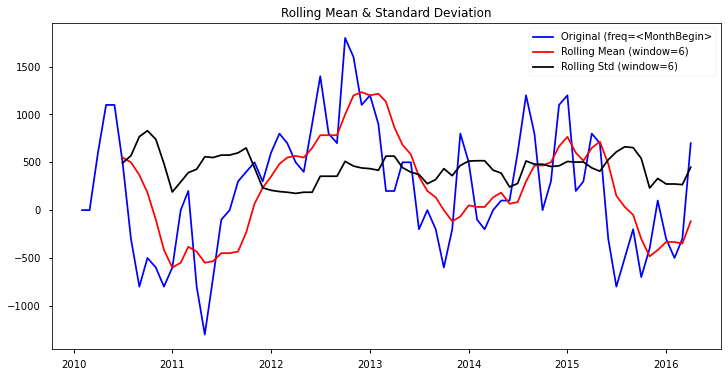

Test Statistic  #Lags Used  ...  p<.05  Stationary?
AD Fuller Results         -3.0886           8  ...   True         True

[1 rows x 6 columns]

In [213]:
stationarity_check(train.diff().dropna(), window=6)

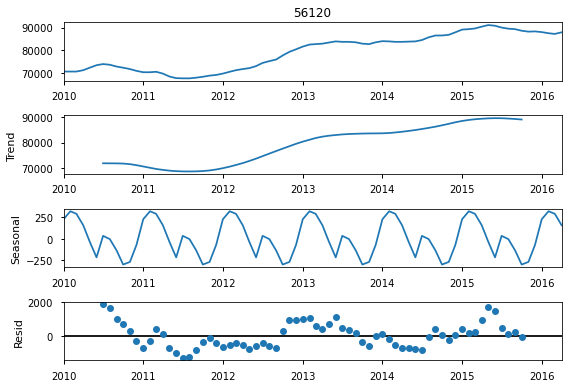

In [214]:
decompose = tsa.seasonal_decompose(train)
decompose.plot();

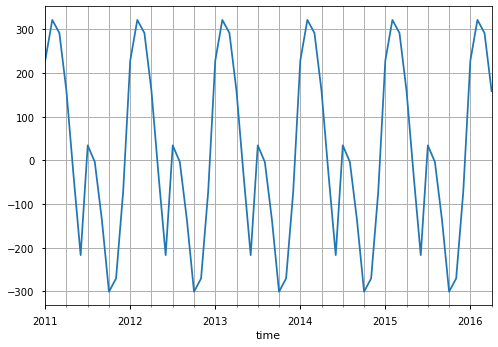

In [215]:
decompose.seasonal.loc['2011':].plot()
plt.grid(which='both')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1186.643, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1187.024, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1186.000, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1193.736, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1187.114, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1188.150, Time=0.15 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1187.590, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1186.069, Time=0.08 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1188.353, Time=0.31 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1185.606, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1187.603, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1187.201, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1185.337, Time=0.05 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1187.185, Time=0.12 sec
 ARIMA(0,1,0)(2,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   76
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -587.248
Date:                             Thu, 01 Jul 2021   AIC                           1184.495
Time:                                     09:51:49   BIC                           1196.083
Sample:                                          0   HQIC                          1189.122
                                              - 76                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     54.0405     58.730      0.920      0.357     -61.069     169.150
ar.L1          0.7366      0.210      3.506      0.000       0.325       1.149
ma.L1         -0.6878      0.216     -3.189      0.001      -1.111      -0.265
ar.S.L12      -0.0557      0.067     -0.837      0.403      -0.186       0.075
sigma2      3.334e+05   6.09e+04      5.474      0.000    2.14e+05    4.53e+05
===================================================================================
Ljung-Box (L1) (Q):                  30.61   Jarque-Bera (JB):                 0.61
Prob(Q):                              0.00   Prob(JB):                         0.74
Heteroskedasticity (H):               0.75   Skew:                             0.06
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

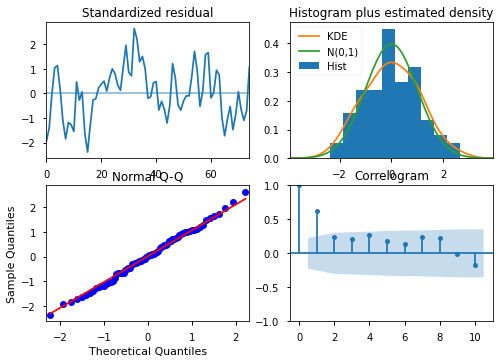

In [216]:
model = pmd.auto_arima(train, start_p=0, start_P=0, start_q=0, start_Q=0, m=12, trace=True)
display(model.summary())
model.plot_diagnostics();

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1186.643, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1187.024, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1186.000, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1193.736, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1187.114, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1188.150, Time=0.15 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1187.590, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1186.069, Time=0.08 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1188.353, Time=0.29 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1185.606, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1187.603, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1187.201, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1185.337, Time=0.06 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1187.185, Time=0.12 sec
 ARIMA(0,1,0)(2,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   76
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -587.248
Date:                             Thu, 01 Jul 2021   AIC                           1184.495
Time:                                     09:51:53   BIC                           1196.083
Sample:                                          0   HQIC                          1189.122
                                              - 76                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     54.0405     58.730      0.920      0.357     -61.069     169.150
ar.L1          0.7366      0.210      3.506      0.000       0.325       1.149
ma.L1         -0.6878      0.216     -3.189      0.001      -1.111      -0.265
ar.S.L12      -0.0557      0.067     -0.837      0.403      -0.186       0.075
sigma2      3.334e+05   6.09e+04      5.474      0.000    2.14e+05    4.53e+05
===================================================================================
Ljung-Box (L1) (Q):                  30.61   Jarque-Bera (JB):                 0.61
Prob(Q):                              0.00   Prob(JB):                         0.74
Heteroskedasticity (H):               0.75   Skew:                             0.06
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

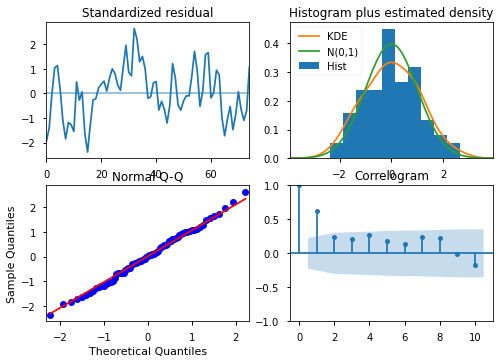

In [217]:
model = pmd.auto_arima(train, 
                       start_p=0, max_p=10,
                       start_P=0, max_P=10,
                       start_q=0, max_q=10,
                       start_Q=0, max_Q=10,
                       d=1, D=0,
                       m=12, 
                       trace=True)
display(model.summary())
model.plot_diagnostics();

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               56120   No. Observations:                   76
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -589.936
Date:                             Thu, 01 Jul 2021   AIC                           1187.873
Time:                                     09:51:54   BIC                           1197.143
Sample:                                 01-01-2010   HQIC                          1191.574
                                      - 04-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9957      0.017     59.218      0.000       0.963       1.029
ma.L1         -0.9876      0.030    -33.118      0.000      -1.046      -0.929
ar.S.L12      -0.0579      0.060     -0.966      0.334      -0.175       0.060
sigma2      3.915e+05   1.17e-08   3.34e+13      0.000    3.91e+05    3.91e+05
===================================================================================
Ljung-Box (L1) (Q):                  35.55   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.00   Prob(JB):                         0.72
Heteroskedasticity (H):               0.80   Skew:                             0.09
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+29. Standard errors may be unstable.
"""

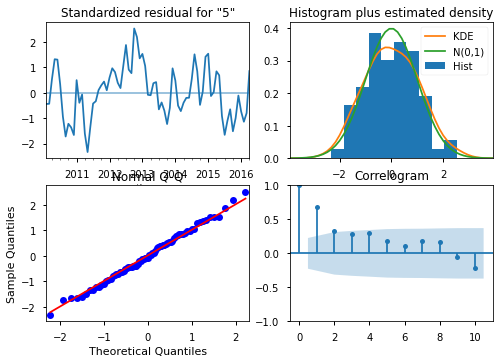

In [218]:
sarimax_model = tsa.SARIMAX(train, order=model.order,seasonal_order=model.seasonal_order).fit()
display(sarimax_model.summary())
sarimax_model.plot_diagnostics();

In [219]:
forecast_df = retrieve_forecast(sarimax_model, steps=len(test))
forecast_df

Lower CI   Upper CI   Forecast
2016-05-01 86849.4279 89303.2263 88076.3271
2016-06-01 86566.7154 90052.5690 88309.6422
2016-07-01 86426.7893 90715.1875 88570.9884
2016-08-01 86327.1225 91300.9422 88814.0323
2016-09-01 86246.0667 91831.4893 89038.7780
2016-10-01 86218.9155 92364.2179 89291.5667
2016-11-01 86192.8064 92859.3237 89526.0651
2016-12-01 86151.9266 93309.4586 89730.6926
2017-01-01 86145.4856 93769.6802 89957.5829
2017-02-01 86159.7849 94230.5259 90195.1554
2017-03-01 86170.0697 94670.4211 90420.2454
2017-04-01 86128.7777 95044.2608 90586.5192
2017-05-01 86143.3882 95421.0811 90782.2346
2017-06-01 86158.0596 95789.4655 90973.7626
2017-07-01 86174.0184 96151.5497 91162.7840
2017-08-01 86193.5673 96510.4058 91351.9866
2017-09-01 86216.3817 96866.3657 91541.3737
2017-10-01 86239.4983 97217.0318 91728.2651
2017-11-01 86265.3591 97565.3371 91915.3481
2017-12-01 86294.4241 97912.1705 92103.2973
2018-01-01 86323.4887 98254.7048 92289.0968
2018-02-01 86353.0606 98593.7812 92473.4209
2018-03-01 86384.3369 98930.8934 92657.6152
2018-04-01 86419.8727 99268.8613 92844.3670

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='Value'>)

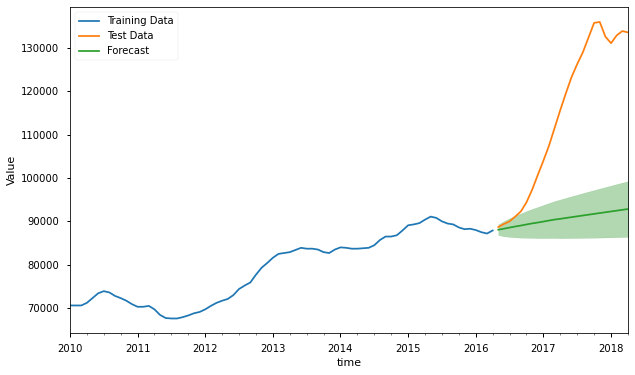

In [220]:
plot_train_test_forecast(train, test, forecast_df)

The forecast does not follow the test data and the test data is outside of the confidence interval. I believe this is due to the drastic difference between the training set and test set. However, it is the best fit model and we will train it on the entire time series.

### Final model

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               56120   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -849.740
Date:                             Thu, 01 Jul 2021   AIC                           1707.480
Time:                                     09:51:55   BIC                           1717.861
Sample:                                 01-01-2010   HQIC                          1711.680
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.009    106.868      0.000       0.981       1.018
ma.L1         -0.9971      0.051    -19.487      0.000      -1.097      -0.897
ar.S.L12      -0.0393      0.061     -0.646      0.518      -0.158       0.080
sigma2      1.669e+06   8.07e-09   2.07e+14      0.000    1.67e+06    1.67e+06
===================================================================================
Ljung-Box (L1) (Q):                  64.48   Jarque-Bera (JB):                16.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.99   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.99e+29. Standard errors may be unstable.
"""

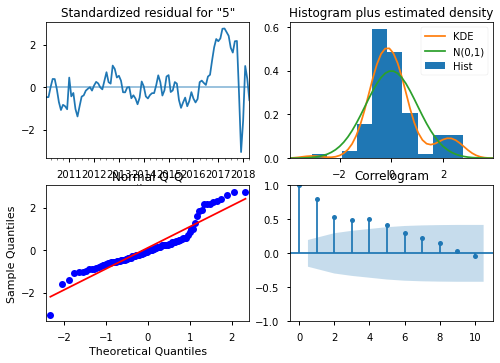

In [221]:
sarimax_model_full = tsa.SARIMAX(ts, order=model.order,seasonal_order=model.seasonal_order,
                            enforce_stationarity=True, enforce_invertibility=True).fit()
display(sarimax_model_full.summary())
sarimax_model_full.plot_diagnostics();

In [222]:
forecast_df = retrieve_forecast(sarimax_model_full, steps=36)
forecast_df

Lower CI    Upper CI    Forecast
2018-05-01 131570.4731 136643.4856 134106.9793
2018-06-01 131023.2199 138220.0471 134621.6335
2018-07-01 130742.7228 139584.4854 135163.6041
2018-08-01 130596.5590 140837.7969 135717.1780
2018-09-01 130500.4013 141985.7422 136243.0718
2018-10-01 130458.7276 143078.8401 136768.7839
2018-11-01 130583.6171 144256.4249 137420.0210
2018-12-01 130881.9351 145543.0581 138212.4966
2019-01-01 131131.4992 146728.8054 138930.1523
2019-02-01 131272.8695 147763.1135 139517.9915
2019-03-01 131463.7656 148810.3863 140137.0760
2019-04-01 131721.2420 149892.8528 140807.0474
2019-05-01 131988.6510 150901.6223 141445.1366
2019-06-01 132265.7431 151899.7431 142082.7431
2019-07-01 132550.6636 152887.5269 142719.0952
2019-08-01 132843.1169 153866.5038 143354.8104
2019-09-01 133143.8690 154838.9946 143991.4318
2019-10-01 133451.1714 155804.5870 144627.8792
2019-11-01 133759.5070 156758.9222 145259.2146
2019-12-01 134067.7530 157701.8884 145884.8207
2020-01-01 134383.9527 158642.4173 146513.1850
2020-02-01 134709.8737 159583.0624 147146.4681
2020-03-01 135038.8402 160517.8456 147778.3429
2020-04-01 135369.7685 161446.3073 148408.0379

Figure save as images/56120_forecast.png


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Zip Code 56120 Forecast'}, xlabel='time', ylabel='Value'>)

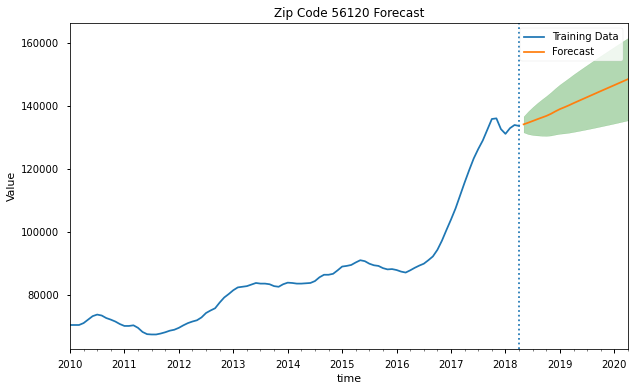

In [223]:
plot_time_series_forecast(ts, forecast_df)

Lower CI  Upper CI  Forecast
2018-05-01   -0.0189    0.0189    0.0000
2018-06-01   -0.0230    0.0307    0.0038
2018-07-01   -0.0251    0.0408    0.0079
2018-08-01   -0.0262    0.0502    0.0120
2018-09-01   -0.0269    0.0587    0.0159
2018-10-01   -0.0272    0.0669    0.0198
2018-11-01   -0.0263    0.0757    0.0247
2018-12-01   -0.0240    0.0853    0.0306
2019-01-01   -0.0222    0.0941    0.0360
2019-02-01   -0.0211    0.1018    0.0403
2019-03-01   -0.0197    0.1096    0.0450
2019-04-01   -0.0178    0.1177    0.0500
2019-05-01   -0.0158    0.1252    0.0547
2019-06-01   -0.0137    0.1327    0.0595
2019-07-01   -0.0116    0.1400    0.0642
2019-08-01   -0.0094    0.1473    0.0690
2019-09-01   -0.0072    0.1546    0.0737
2019-10-01   -0.0049    0.1618    0.0785
2019-11-01   -0.0026    0.1689    0.0832
2019-12-01   -0.0003    0.1759    0.0878
2020-01-01    0.0021    0.1830    0.0925
2020-02-01    0.0045    0.1900    0.0972
2020-03-01    0.0069    0.1969    0.1019
2020-04-01    0.0094    0.2039    0.1066

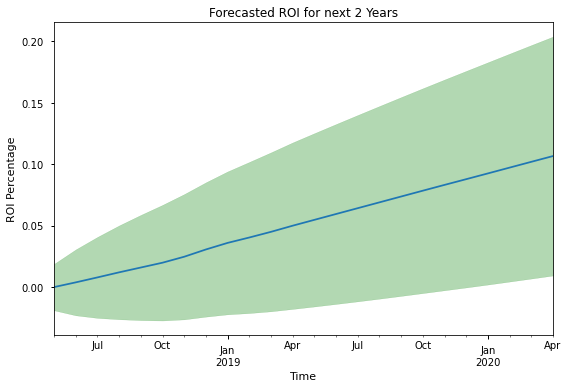

In [224]:
calculate_roi(forecast_df['Forecast'])

Based on the forecast of the best fit model, Zip Code 56578 has a predicted ROI of 21.7% after three years. However, the confidence interval ranges from -9.3% to 52.7%

# Interpreting Results

Based on the forecasted ROI percentages calculated from the SARIMA model forecasts, I would provide the following recommendations to the real estate investment firm as they look to invest in Minnesota:

- **Zip Code 55412** Zip code 55412 had a forecasted ROI of 35.6% after three years, with a lower confidence interval of -78% and an upper confidence interval of 149%. The firm should invest in this zip code.

- **Zip Code 55411** Zip code 55411 had a forecasted ROI of 34.6% after three years, with a lower confidence interval of -91% and an upper confidence interval of 160%. The firm should invest in this zip code.

- **Zip Code 55319** Zip code 55319 had a forecasted ROI of 32.4% after three years, with a lower confidence interval of -27.1% and an upper confidence interval of 92.1%. The firm should invest in this zip code.

- **Zip Code 55413** Zip code 55413 had a forecasted ROI of 26.7% after three years, with a lower confidence interval of -9.8% and an upper confidence interval of 63.3%. The firm should invest in this zip code.

- **Zip Code 55672** Zip code 55672 had a forecasted ROI of 22.8% after three years, with a lower confidence interval of -50% and an upper confidence interval of 96%. The firm should invest in this zip code.

However, the SARIMA models and analysis are not complete solutions, nor are they perfect. The time series struggle to perfectly meet the assumption of stationarity, and as such the models will not be completely accurate.

I could improve this analysis in the future by further transforming the data to achieve stationarity, further tweaking the hyperparameters of the models, or by experimenting with other models like recurrent neural networks, Prophet, and Greykite.